# Stage 1 analysis; Long wavelength Spectroscopy

In [365]:
import sys, os, time                                                            
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from importlib import reload                                                    
import eureka.S1_detector_processing.s1_process as s1                                 
from eureka.lib import readECF as rd                                            
from eureka.lib import logedit                                                  
from eureka.lib import readECF as rd                                            
from eureka.lib import manageevent as me                                        
#from eureka.S1_data_reduction import optspex                                    
from eureka.lib import astropytable                                             
from eureka.lib import util   

plt.rcParams['font.size'] = 15
plt.rcParams['lines.markersize'] = 2

In [366]:
# Starts timer to monitor how long data reduction takes
t0      = time.time()

# Names the event (has to match the event name used for the *.ecf files)
eventlabel = 'wasp39b'                                                           

In [367]:
!ls 'dc-roof'

ideal_one_over_f_nirspec_format.fits
ideal_one_over_f_nirspec_format_lin_corr.fits
ideal_one_over_f_nirspec_format_med_corr.fits
jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS.fits
jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp.fits
jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_SKIPJUMP.fits
jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS.fits
jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS_add_lin_corr.fits
jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS_add_med_corr.fits


In [368]:
hdul = fits.open("dc-roof/jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS.fits")
hdul.info()

Filename: dc-roof/jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     209   ()      
  1  SCI           1 ImageHDU        50   (512, 32, 3, 10)   float32   
  2  PIXELDQ       1 ImageHDU        11   (512, 32)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (512, 32, 3, 10)   uint8   
  4  ERR           1 ImageHDU        11   (512, 32, 3, 10)   float32   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [6414B]   


In [369]:
hdul[1].data

array([[[[ 4.80777588e+01,  7.61723633e+01,  7.25468750e+01, ...,
           6.44921875e+01,  6.65727539e+01,  1.22924805e+01],
         [ 9.70588379e+01,  5.52854004e+01,  7.47080078e+01, ...,
           4.26142578e+01,  4.30212402e+01,  8.54492188e-02],
         [ 1.02121826e+02,  1.10812256e+02,  1.18520508e+01, ...,
           9.89152832e+01,  2.12121582e+01,  4.37231445e+00],
         ...,
         [ 6.59252930e+01,  1.04605469e+02,  9.32697754e+01, ...,
           5.57208252e+01,  3.89252930e+01,  2.68052979e+01],
         [ 9.85385742e+01,  6.63381348e+01,  1.32535034e+02, ...,
           8.52294922e-01,  6.94245605e+01, -8.81164551e-01],
         [ 4.89370117e+01, -3.92187500e+00,  2.80454102e+01, ...,
           1.01806641e+01,  7.26525879e+01, -1.01147461e+01]],

        [[ 2.20777588e+01,  6.41723633e+01,  6.25468750e+01, ...,
           1.09492188e+02,  8.35727539e+01,  4.32924805e+01],
         [ 7.20588379e+01,  5.32854004e+01,  6.17080078e+01, ...,
           7.06142578e

In [370]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2022-03-21T19:37:31.874' / UTC date file created                     
ORIGIN  = 'STScI   '           / Organization responsible for creating file     
FILENAME= 'jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp.fits' / Na
FILETYPE= 'countrate'          / Type of data in the file                       
SDP_VER = 'B7.0    '           / Data processing software version number        
CAL_VER = '1.3.3   '           / Calibration software version number            
CAL_VCS = 'RELEASE '           / Calibration software version control sys number
DATAMODL= 'RampModel'          / Type of data model                             
TELESCOP= 'JWST    '        

In [371]:
print(np.shape(hdul[1].data[:,:,1,:,]))

np.shape(hdul[1].data[:,:,:,:,])

(10, 3, 512)


(10, 3, 32, 512)

0
1
2
3
4
5
6
7
8
9


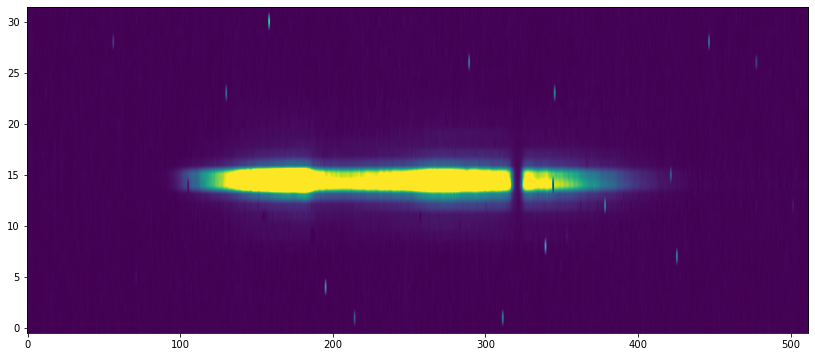

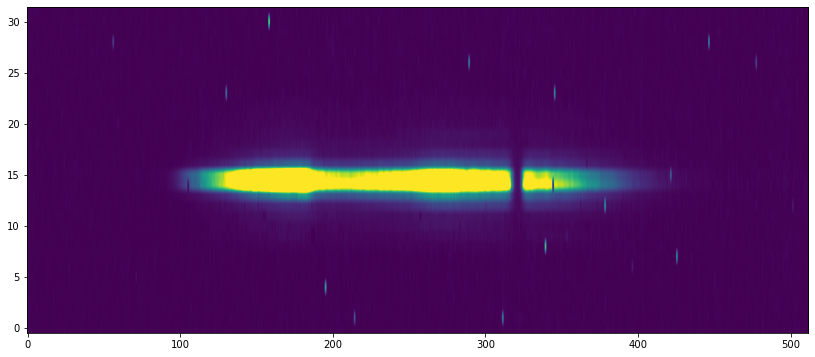

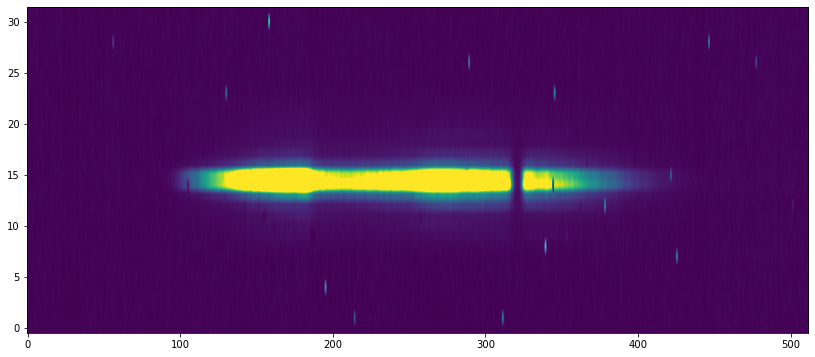

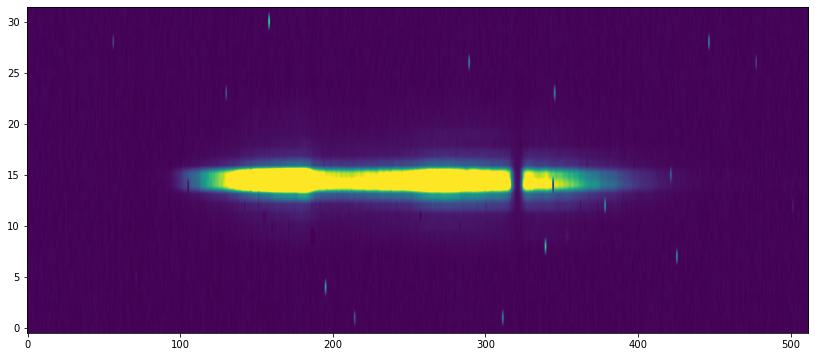

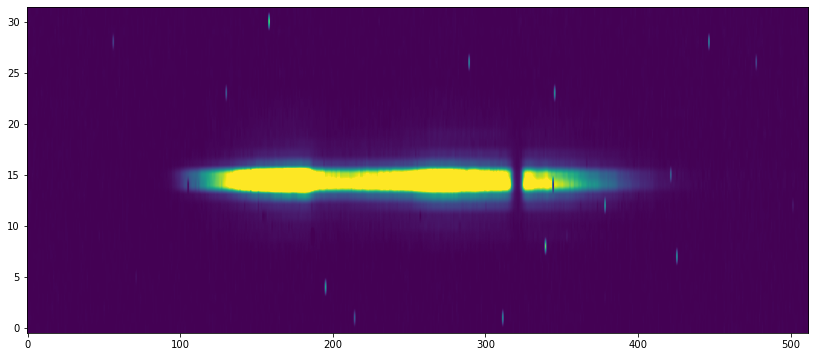

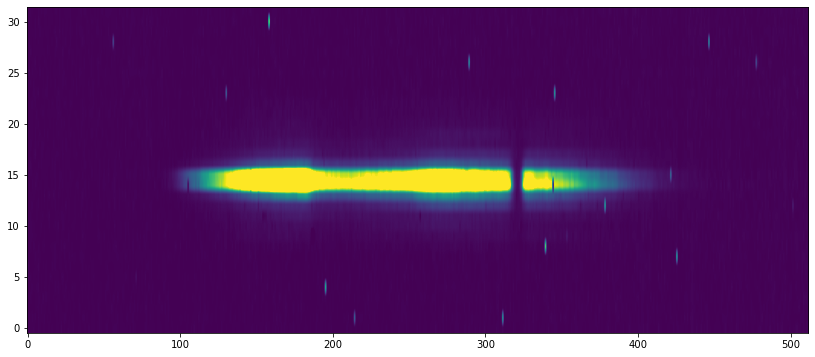

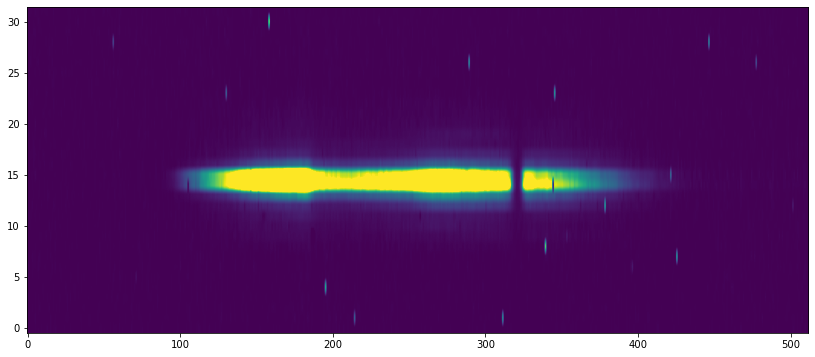

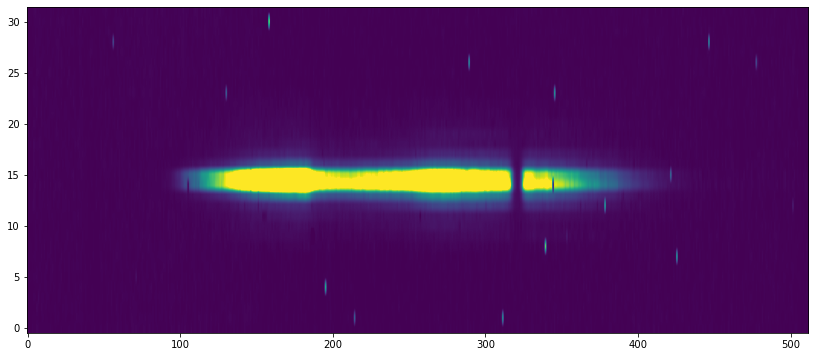

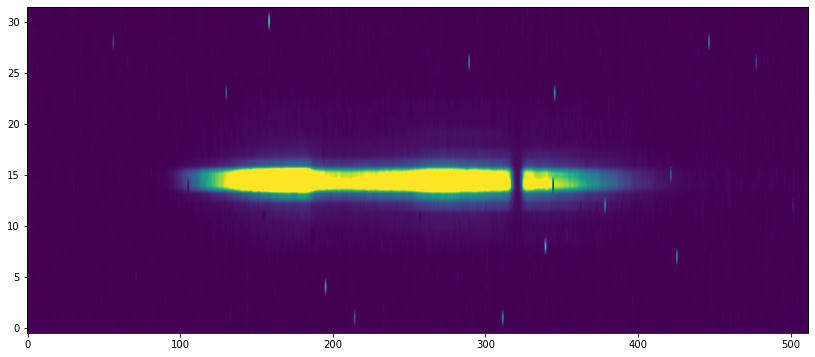

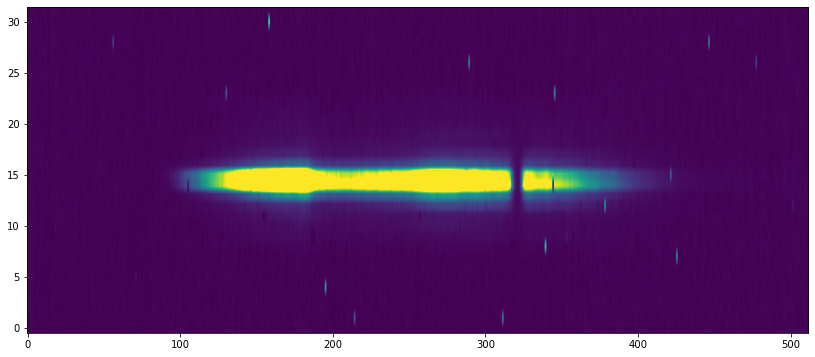

In [372]:
%matplotlib inline
for i in range(0, 10):
    print(i)
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    plt.imshow(hdul[1].data[i,1,:,:,], origin = 'lower', aspect='auto',  vmin=0, vmax=1e4)

In [373]:
# Sum the rows and columns for group 0

def row_col_counter(colsize, rowsize, group_num, integr_num):
    col_arrays = []
    col_values = np.zeros(colsize)

    for col_num in range(0, rowsize):
        for row_num in range(0,colsize):
            col_values[row_num] = hdul[1].data[integr_num,group_num,row_num,col_num]
        col_arrays.append(col_values.tolist())

    col_arrays_flat = [item for sublist in col_arrays for item in sublist]
    
    return col_arrays, np.array(col_arrays_flat)


In [374]:
colsize = hdul[0].header['SUBSIZE2']
rowsize = hdul[0].header['SUBSIZE1']

col_arrays0, col_arrays_flat0 = row_col_counter(colsize, rowsize, group_num=0, integr_num=0)
col_arrays1, col_arrays_flat1 = row_col_counter(colsize, rowsize, group_num=0, integr_num=1)
col_arrays2, col_arrays_flat2 = row_col_counter(colsize, rowsize, group_num=0, integr_num=2)
col_arrays3, col_arrays_flat3 = row_col_counter(colsize, rowsize, group_num=0, integr_num=3)
col_arrays4, col_arrays_flat4 = row_col_counter(colsize, rowsize, group_num=0, integr_num=4)
col_arrays5, col_arrays_flat5 = row_col_counter(colsize, rowsize, group_num=0, integr_num=5)
col_arrays6, col_arrays_flat6 = row_col_counter(colsize, rowsize, group_num=0, integr_num=6)
col_arrays7, col_arrays_flat7 = row_col_counter(colsize, rowsize, group_num=0, integr_num=7)
col_arrays8, col_arrays_flat8 = row_col_counter(colsize, rowsize, group_num=0, integr_num=8)
col_arrays9, col_arrays_flat9 = row_col_counter(colsize, rowsize, group_num=0, integr_num=9)

<IPython.core.display.Javascript object>


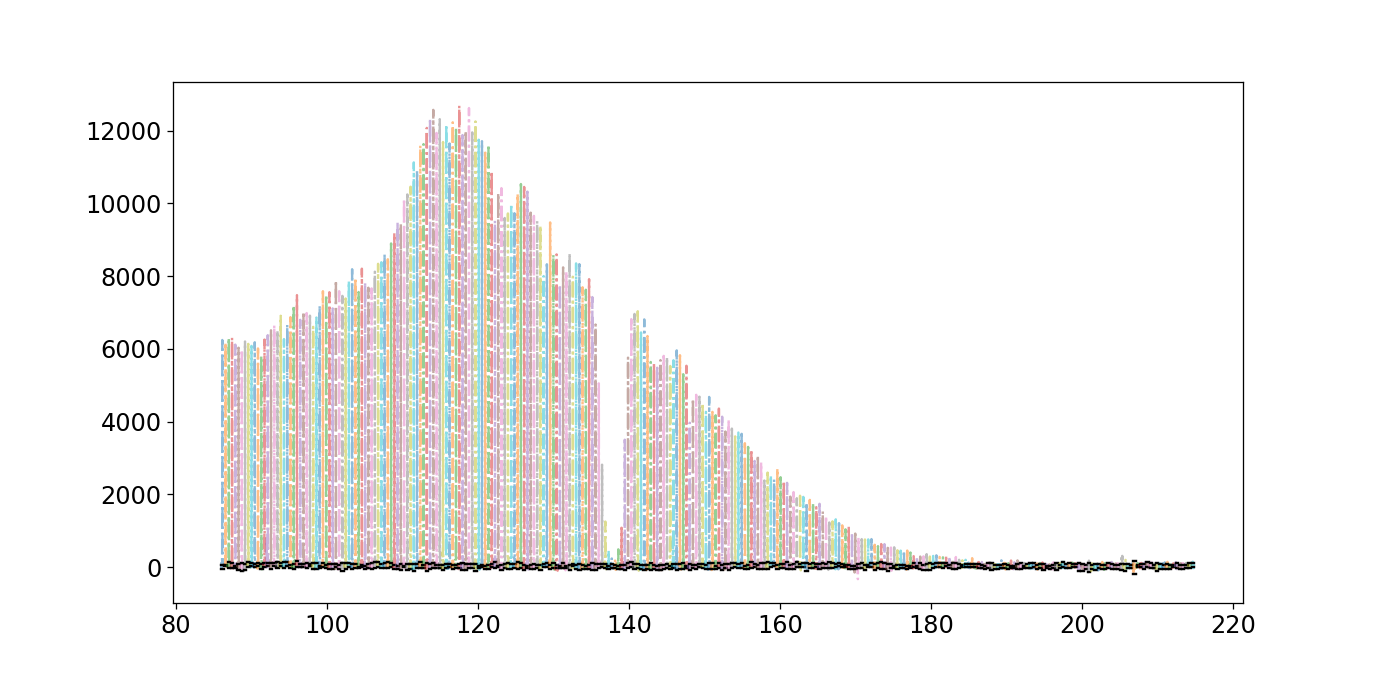

12.530029296875 81.3787841796875
right is bigger than left
27.904462071969284
57.400390625 50.00799560546875
11.53027481252107
55.468597412109375 39.783294677734375
40.434370518918506
53.968017578125 47.52545166015625
37.73658452089543
13.6517333984375 3.5240478515625
left is bigger than right
14.754417370685958
14.754417370685958
62.303924560546875 2.179534912109375
left is bigger than right
38.41038287732014
38.41038287732014
37.18060302734375 5.04962158203125
left is bigger than right
52.349793290073244
52.349793290073244
1.3870849609375 49.63916015625
right is bigger than left
36.854175945020785
86.886962890625 51.29241943359375
33.540781754550956
62.3095703125 58.56036376953125
22.45393881684685
56.39886474609375 53.21563720703125
24.19982842761885
49.96014404296875 77.162109375
21.535334686149483
27.105560302734375 94.19036865234375
right is bigger than left
33.83221676743075
91.5927734375 47.22589111328125
28.929581689586367
250.92648315429688 69.51174926757812
left is bigger th

31.29534912109375 28.7061767578125
37.91340345632645
37.10862731933594 20.957534790039062
25.3421667328711
-13.243896484375 19.231689453125
29.712789487832744
-1.06622314453125 34.68017578125
right is bigger than left
35.98028686347215
-3.611083984375 -2.32379150390625
30.014403619678493
9.91656494140625 29.6746826171875
43.22662826666792
24.4088134765625 1.909423828125
left is bigger than right
23.282842954760728
23.282842954760728
-19.2286376953125 -10.776458740234375
27.043332586043448
-18.3663330078125 7.5928955078125
32.987955194536625
-13.795166015625 -6.9822998046875
25.325446289225738
38.8350830078125 31.1688232421875
21.376019202927058
-6.28515625 10.1988525390625
22.32936416419841
35.1568603515625 28.65167236328125
28.244299483952187
-19.558349609375 32.15895080566406
38.00808336643691
86.53564453125 18.88568115234375
left is bigger than right
30.20532088399546
30.20532088399546
35.342620849609375 29.29833984375
43.19722033227797
4.55047607421875 19.8267822265625
right is big

29.511869658996964
49.56304931640625 71.65997314453125
32.73310471797889
34.522918701171875 42.36285400390625
21.492105432930323
47.6107177734375 61.2232666015625
22.724825681567577
-32.146087646484375 53.255950927734375
51.9125813116096
36.249755859375 -59.4830322265625
52.488800614297034
8.2548828125 29.745849609375
right is bigger than left
31.357842938718544
-44.192626953125 20.05511474609375
57.18987401700604
-3.11236572265625 7.69293212890625
25.270474401703183
12.77496337890625 46.96185302734375
right is bigger than left
43.108658503396995
35.03643798828125 16.93408203125
23.429701789826638
21.72442626953125 5.669189453125
left is bigger than right
25.35639104560027
25.35639104560027
-6.413909912109375 -0.4544677734375
left is bigger than right
25.15133088541938
25.15133088541938
28.49493408203125 56.33880615234375
32.96583875485032
15.745819091796875 33.165435791015625
30.859913850739456
21.370849609375 4.382171630859375
left is bigger than right
29.450691043065717
29.450691043

In [375]:
# test median, sigma subtraction
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(12, 6))#25, 6))


for i in np.arange(200, 500):#0, len(col_arrays0)):
    median_col_left = np.mean(np.array(col_arrays0[i])[np.array([0, 1,3,4])])
    median_col_right = np.mean(np.array(col_arrays0[i])[np.array([28,29, 30, 31])])
    
    print(median_col_left, median_col_right)
    
    # Check if there is a bad pixel on the left
    if np.abs(median_col_left) > 3*np.abs(median_col_right):
        median_col = median_col_right.copy()
        sig_col = np.std(np.array(col_arrays0[i])[np.array([28,29, 30, 31])])
        print("left is bigger than right")
        print(sig_col)
    elif np.abs(median_col_right) > 3*np.abs(median_col_left):
        median_col = median_col_left.copy()
        sig_col = np.std(np.array(col_arrays0[i])[np.array([0, 1,3, 4])])
        print("right is bigger than left")
    else:
        median_col = np.median(np.array(col_arrays0[i])[np.array([0, 1,3,4,28,29, 30, 31])])
        sig_col = np.std(np.array(col_arrays0[i])[np.array([0, 1,3, 4, 28, 29, 30, 31])])
    
    print(sig_col)
    plt.plot(time_full[i], col_arrays0[i], "-.", alpha=0.5)
    plt.plot(time_full[i], [median_col+2*sig_col]*len(time_full[i]), color='k')
    plt.plot(time_full[i], [median_col-2*sig_col]*len(time_full[i]), color='k')

<IPython.core.display.Javascript object>


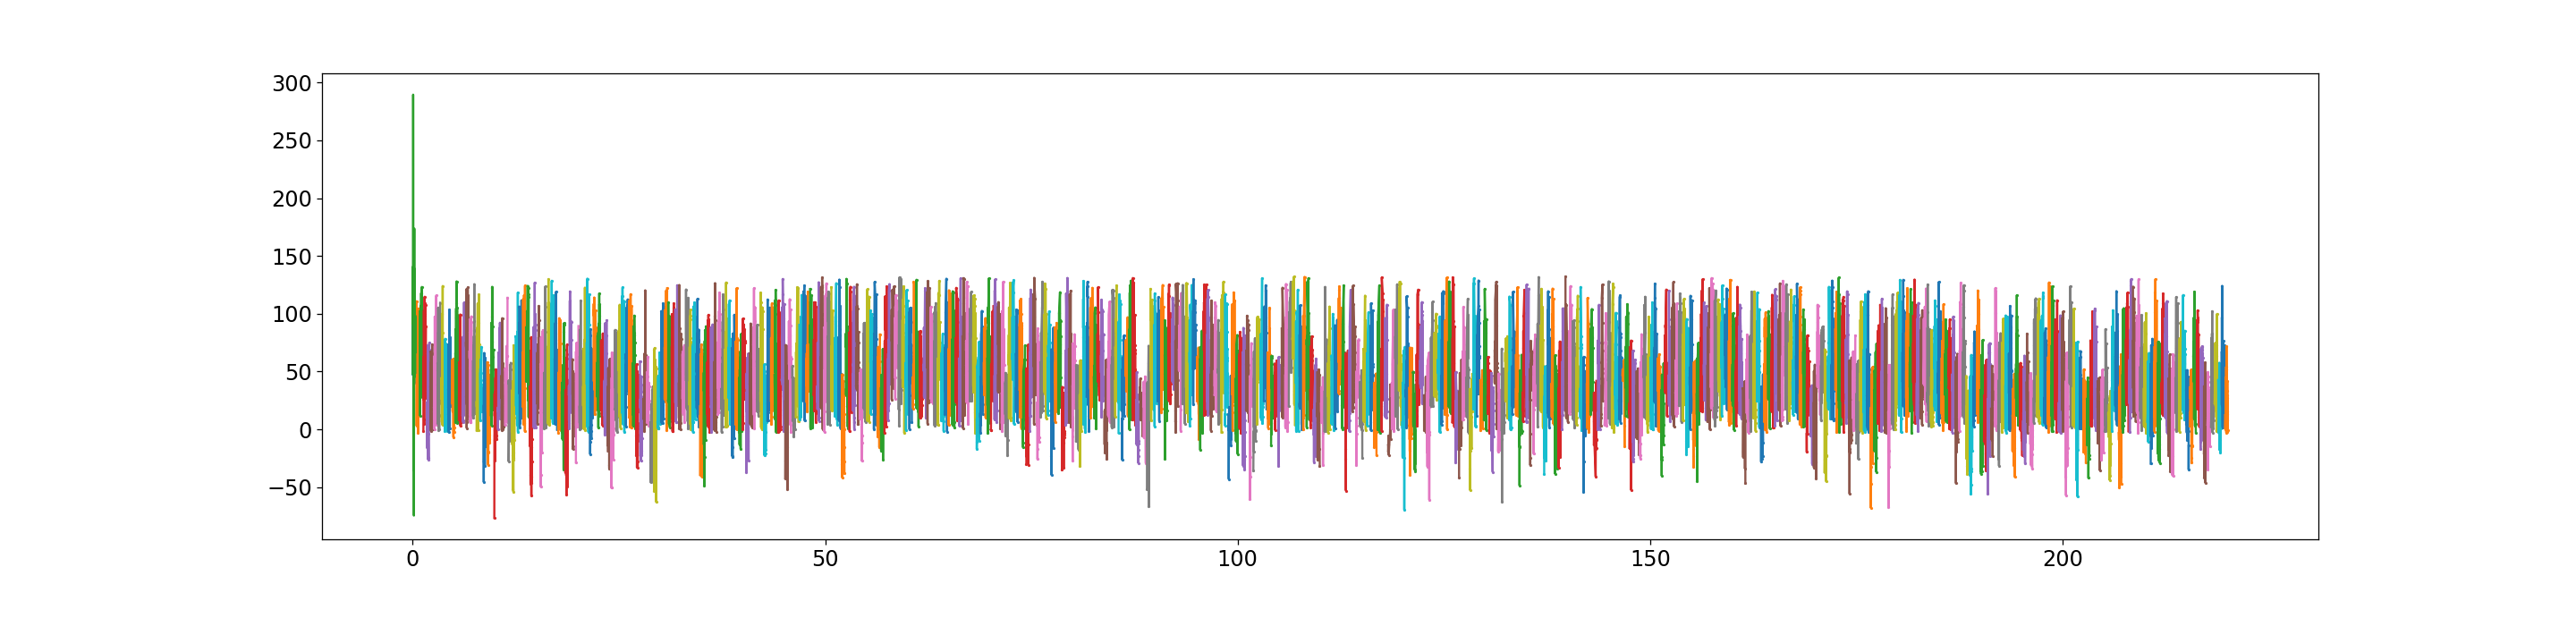

In [376]:
    #%matplotlib inline
    %matplotlib notebook
    time_arrays = []
    col_mask_arrays = []
    time_mask_arrays = []
    col_values_list =[]
    image =  np.zeros((10, 3, 32, 512))
    image_masked = np.zeros((10, 3, 32, 512))

    integr_nums = 1#10
    group_nums = 1
    rowsize = 512
    
    
    
    for group_num in range(0, group_nums):
        for integr_num in range(0, integr_nums):
            fig, ax = plt.subplots(1, 1, figsize=(25, 6))
            for col_num in range(0, rowsize):
            
            
                #integr_num = 0
                #group_num = 0
                #col_num = 0
                
                #print(integr_num,group_num,col_num)
                
                time = time_full[col_num]
                time_arrays.append(time)
                
                col_values= hdul[1].data[integr_num,group_num,:,col_num]
                image[integr_num,group_num,:,col_num] = hdul[1].data[integr_num,group_num,:,col_num]
                col_values_list.append(col_values)

                
                # add in masking HERE
                median_col_left = np.mean(np.array(col_values)[np.array([0, 1,3,4])])
                median_col_right = np.mean(np.array(col_values)[np.array([28,29, 30, 31])])

                #print(median_col_left, median_col_right)

                # Check if there is a bad pixel on the left
                if np.abs(median_col_left) > 3*np.abs(median_col_right):
                    median_col = median_col_right.copy()
                    sig_col = np.std(np.array(col_arrays0[i])[np.array([28,29, 30, 31])])
                    #print("left is bigger than right")
                    #print(sig_col)
                elif np.abs(median_col_right) > 3*np.abs(median_col_left):
                    median_col = median_col_left.copy()
                    sig_col = np.std(np.array(col_arrays0[i])[np.array([0, 1,3, 4])])
                    #print("right is bigger than left")
                else:
                    median_col = np.median(np.array(col_arrays0[i])[np.array([0, 1,3,4,28,29, 30, 31])])
                    sig_col = np.std(np.array(col_arrays0[i])[np.array([0, 1,3, 4, 28, 29, 30, 31])])

                min_cutoff = median_col-3*sig_col
                max_cutoff = median_col+3*sig_col
                
                col_masked_values = col_values[np.where((col_values>min_cutoff)&(col_values<max_cutoff))]
                col_mask_arrays.append(col_masked_values)
                
                time_masked = time[np.where((col_values>min_cutoff)&(col_values<max_cutoff))]
                time_mask_arrays.append(time_masked)
                
                #plt.plot(time, col_values, ".-")
                plt.plot(time_masked, col_masked_values, ".-")#, color='k')
            
                
                #image_masked[integr_num,group_num,:,col_num] = col_masked_values

In [377]:
# median, sigma subtraction

def median_sig_cleanup(integr_nums, group_nums, rowsize):
    
    time_arrays = []
    col_mask_arrays = []
    time_mask_arrays = []
    col_values_list =[]
    image =  np.zeros((10, 3, 32, 512))
    image_masked = np.zeros((10, 3, 32, 512))
    
    for group_num in range(0, group_nums):
        for integr_num in range(0, integr_nums):
            for col_num in range(0, rowsize):
                
                #print(integr_num,group_num,col_num)
                time = time_full[col_num]
                time_arrays.append(time)
                
                col_values= hdul[1].data[integr_num,group_num,:,col_num]
                image[integr_num,group_num,:,col_num] = hdul[1].data[integr_num,group_num,:,col_num]
                col_values_list.append(col_values)

                
                # add in masking HERE
                median_col_left = np.mean(np.array(col_values)[np.array([0, 1,3,4])])
                median_col_right = np.mean(np.array(col_values)[np.array([28,29, 30, 31])])

                #print(median_col_left, median_col_right)

                # Check if there is a bad pixel on the left
                if np.abs(median_col_left) > 3*np.abs(median_col_right):
                    median_col = median_col_right.copy()
                    sig_col = np.std(np.array(col_arrays0[i])[np.array([28,29, 30, 31])])
                    #print("left is bigger than right")
                    #print(sig_col)
                elif np.abs(median_col_right) > 3*np.abs(median_col_left):
                    median_col = median_col_left.copy()
                    sig_col = np.std(np.array(col_arrays0[i])[np.array([0, 1,3, 4])])
                    #print("right is bigger than left")
                else:
                    median_col = np.median(np.array(col_arrays0[i])[np.array([0, 1,3,4,28,29, 30, 31])])
                    sig_col = np.std(np.array(col_arrays0[i])[np.array([0, 1,3, 4, 28, 29, 30, 31])])

                min_cutoff = median_col-3*sig_col
                max_cutoff = median_col+3*sig_col
                
                col_masked_values = col_values[np.where((col_values>min_cutoff)&(col_values<max_cutoff))]
                #image_masked[integr_num,group_num,:,col_num] = col_masked_values
                col_mask_arrays.append(col_masked_values.tolist())
                
                time_masked = time[np.where((col_values>min_cutoff)&(col_values<max_cutoff))]
                time_mask_arrays.append(time_masked.tolist())
                
                #print(len(time_masked), len(col_masked_values))
                #print(image_corr)
                                
    
    #masked_times = np.array([],[])
    #masked_cols = np.array([],[])
    
    return time_mask_arrays, col_mask_arrays, col_values_list, image#, image_masked

In [378]:
time_mask_arrays, col_mask_arrays, col_values_list, image = median_sig_cleanup(integr_nums=10, 
                                                                                           group_nums=3,
                                                                                           rowsize=1)#512)


In [379]:
time_np = np.arange(0, 320, 10)/1000
plt.plot(time_np, col_arrays0[0])

In [380]:
time_full = [time_np.copy()]
print(time_full)

for i in np.arange(1,rowsize):
    #print(i)
    #print(time_np.copy()+(120)+time_full[-1][-1])
    time_full.append(time_np.copy()+120/1000+time_full[-1][-1])
    
    
time_full_flat = [item for sublist in time_full for item in sublist]
time_full_flat = np.array(time_full_flat)

[array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31])]


<IPython.core.display.Javascript object>


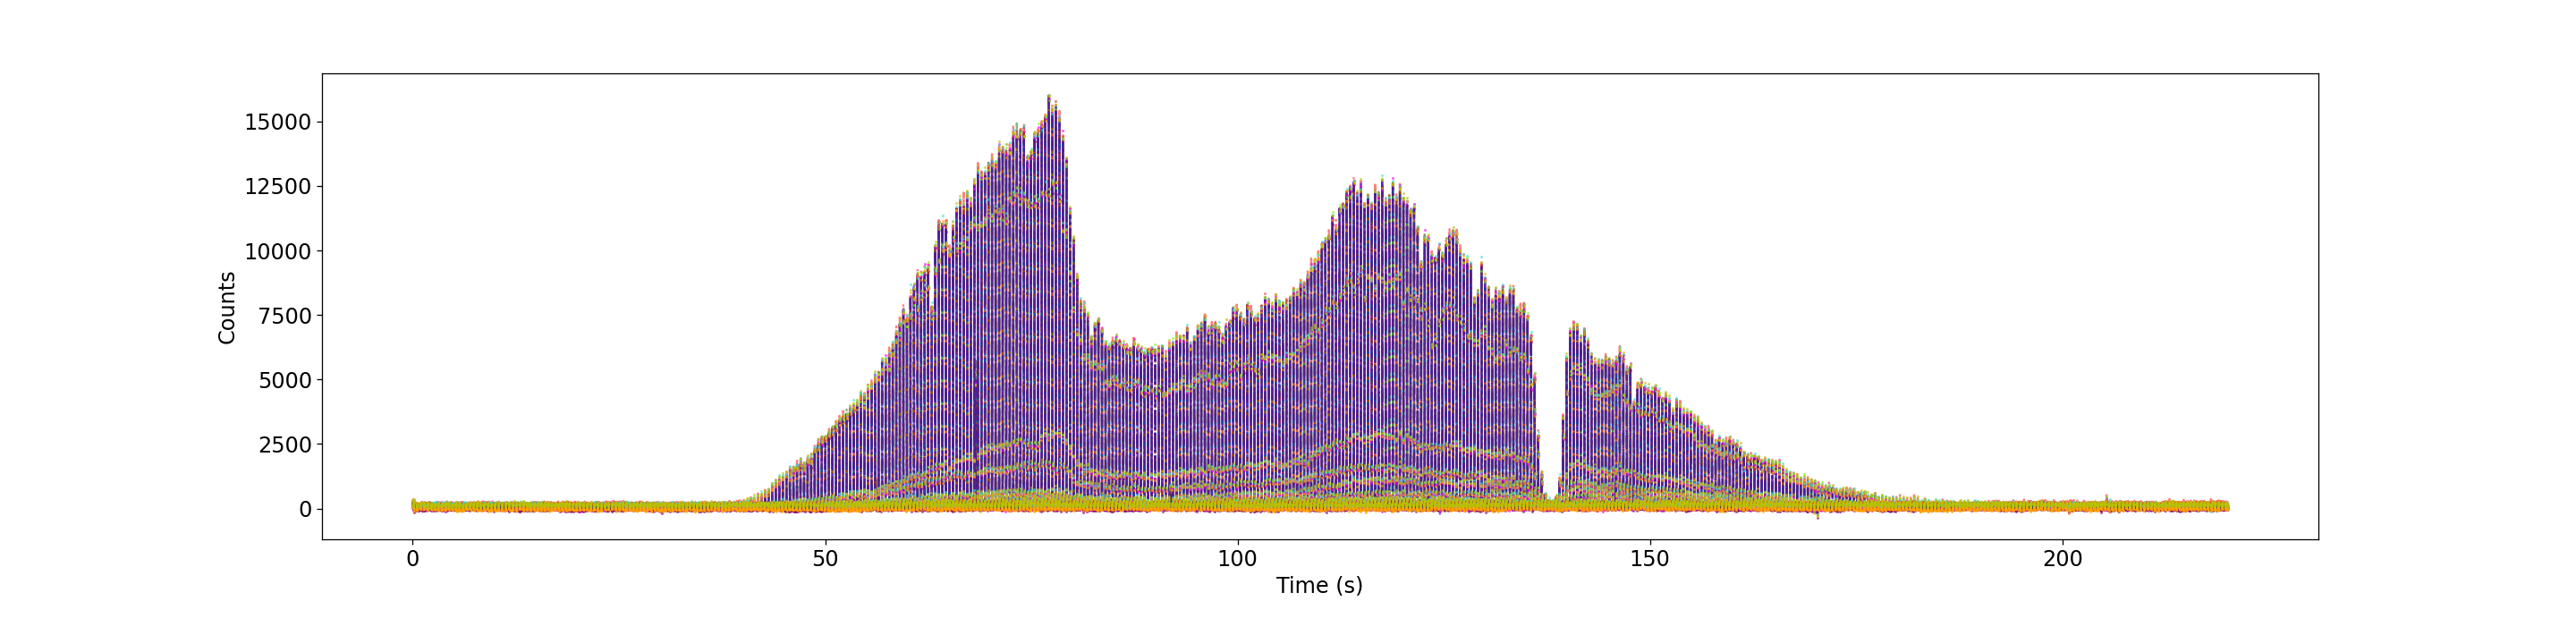

Text(0, 0.5, 'Counts')

In [381]:
# plot the ten different integrations
#%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(25, 6))

for i in np.arange(0, len(col_arrays0)):
    plt.plot(time_full[i], col_arrays0[i], "-.", color='k', alpha=0.5)
    plt.plot(time_full[i], col_arrays1[i], "-.", color='g', alpha=0.5)
    plt.plot(time_full[i], col_arrays2[i], "-.", color='r', alpha=0.5)
    plt.plot(time_full[i], col_arrays3[i], "-.", color='b', alpha=0.5)
    plt.plot(time_full[i], col_arrays4[i], ".", color='purple', alpha=0.5)
    plt.plot(time_full[i], col_arrays5[i], ".", color='lawngreen', alpha=0.5)
    plt.plot(time_full[i], col_arrays6[i], ".", color='fuchsia', alpha=0.5)
    plt.plot(time_full[i], col_arrays7[i], ".", color='turquoise', alpha=0.5)
    plt.plot(time_full[i], col_arrays8[i], ".", color='orange', alpha=0.5)
    plt.plot(time_full[i], col_arrays9[i], ".", color='y', alpha=0.5)
    #plt.xlim(0, 6000)
    #plt.ylim(-50, 400)
    
plt.xlabel("Time (s)")
plt.ylabel("Counts")

In [382]:
xmin = 40550
ymin = 180

xmax = 183500
ymax = 16000


def index_mask_finder(col_arrays_flat, ymin):
    indexes_keep = (np.array(col_arrays_flat0)<ymin).nonzero()[0]
    return indexes_keep

def masked_time_col(col_arrays_flat, ymin):
    indexes_keep = (np.array(col_arrays_flat)<ymin).nonzero()[0]
    return time_full_flat[index_mask_finder(col_arrays_flat, ymin)].tolist(), col_arrays_flat[index_mask_finder(col_arrays_flat, ymin)].tolist()


<IPython.core.display.Javascript object>


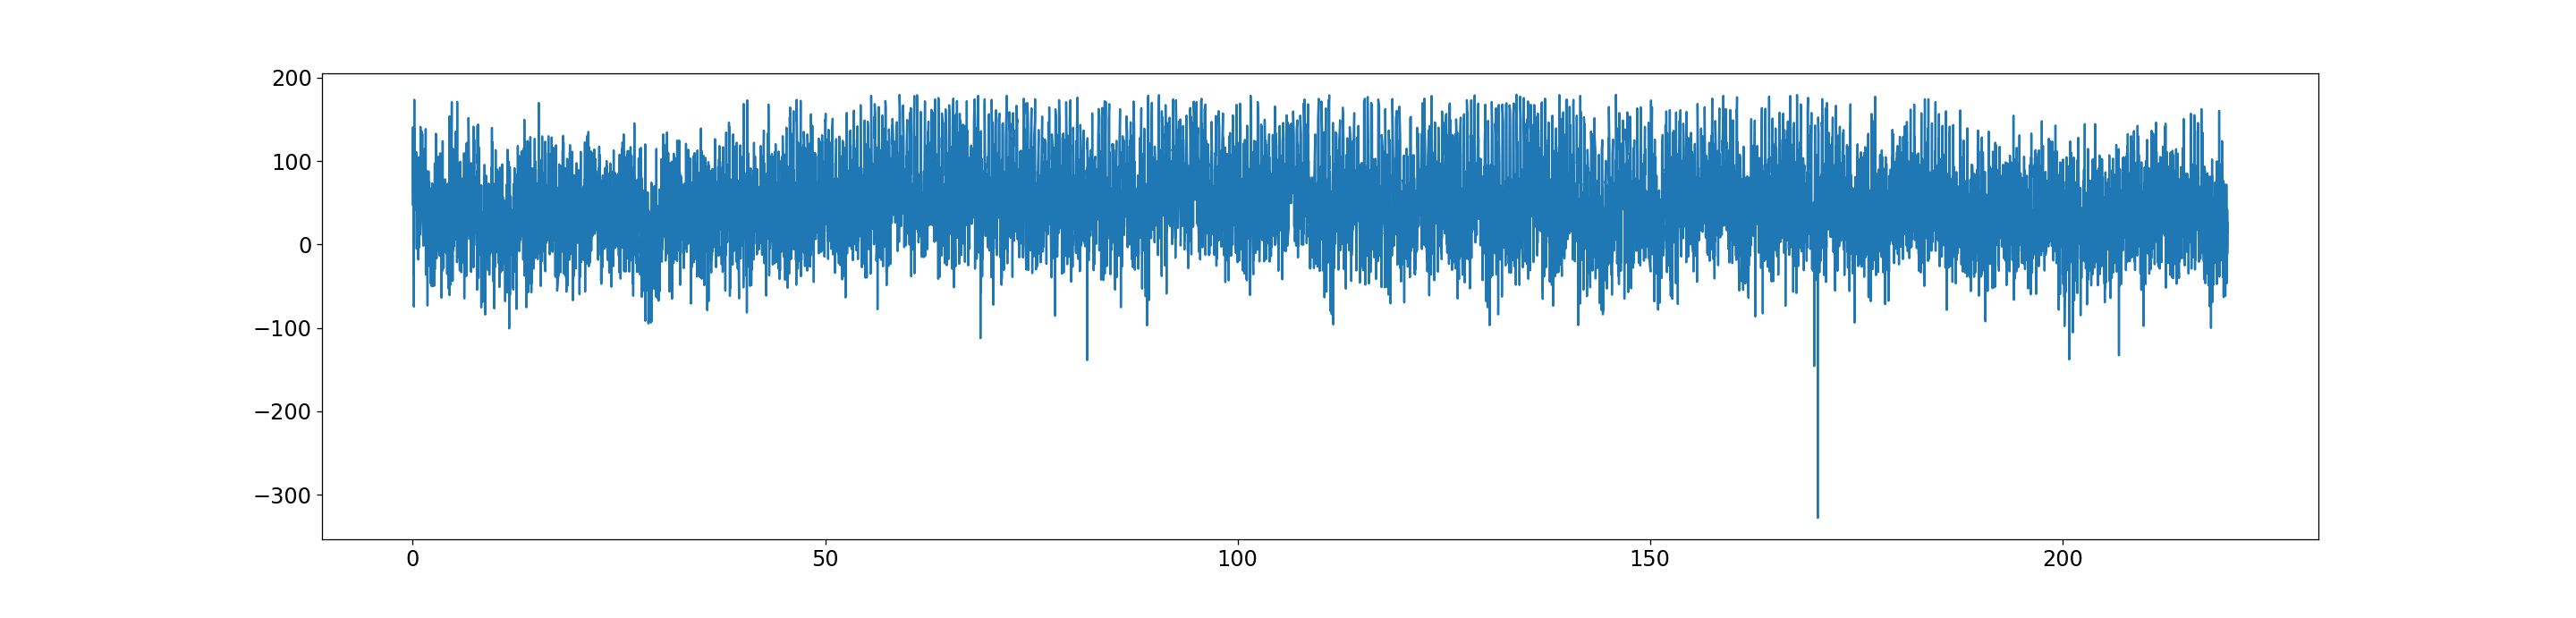

In [383]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))


plt.plot(time_full_flat[np.where(np.array(col_arrays_flat0)<ymin)], col_arrays_flat0[np.where(np.array(col_arrays_flat0)<ymin)])


#plt.plot(time_full_flat[np.where(np.array(col_arrays_flat1)<ymin)], col_arrays_flat1[np.where(np.array(col_arrays_flat1)<ymin)])
#plt.plot(time_full_flat[np.where(np.array(col_arrays_flat2)<ymin)], col_arrays_flat2[np.where(np.array(col_arrays_flat2)<ymin)])
#plt.plot(time_full_flat[np.where(np.array(col_arrays_flat3)<ymin)], col_arrays_flat3[np.where(np.array(col_arrays_flat3)<ymin)])
#plt.plot(time_full_flat[np.where(np.array(col_arrays_flat4)<ymin)], col_arrays_flat4[np.where(np.array(col_arrays_flat4)<ymin)])
#plt.plot(time_full_flat[np.where(np.array(col_arrays_flat5)<ymin)], col_arrays_flat5[np.where(np.array(col_arrays_flat5)<ymin)])
#plt.plot(time_full_flat[np.where(np.array(col_arrays_flat6)<ymin)], col_arrays_flat6[np.where(np.array(col_arrays_flat6)<ymin)])




<IPython.core.display.Javascript object>


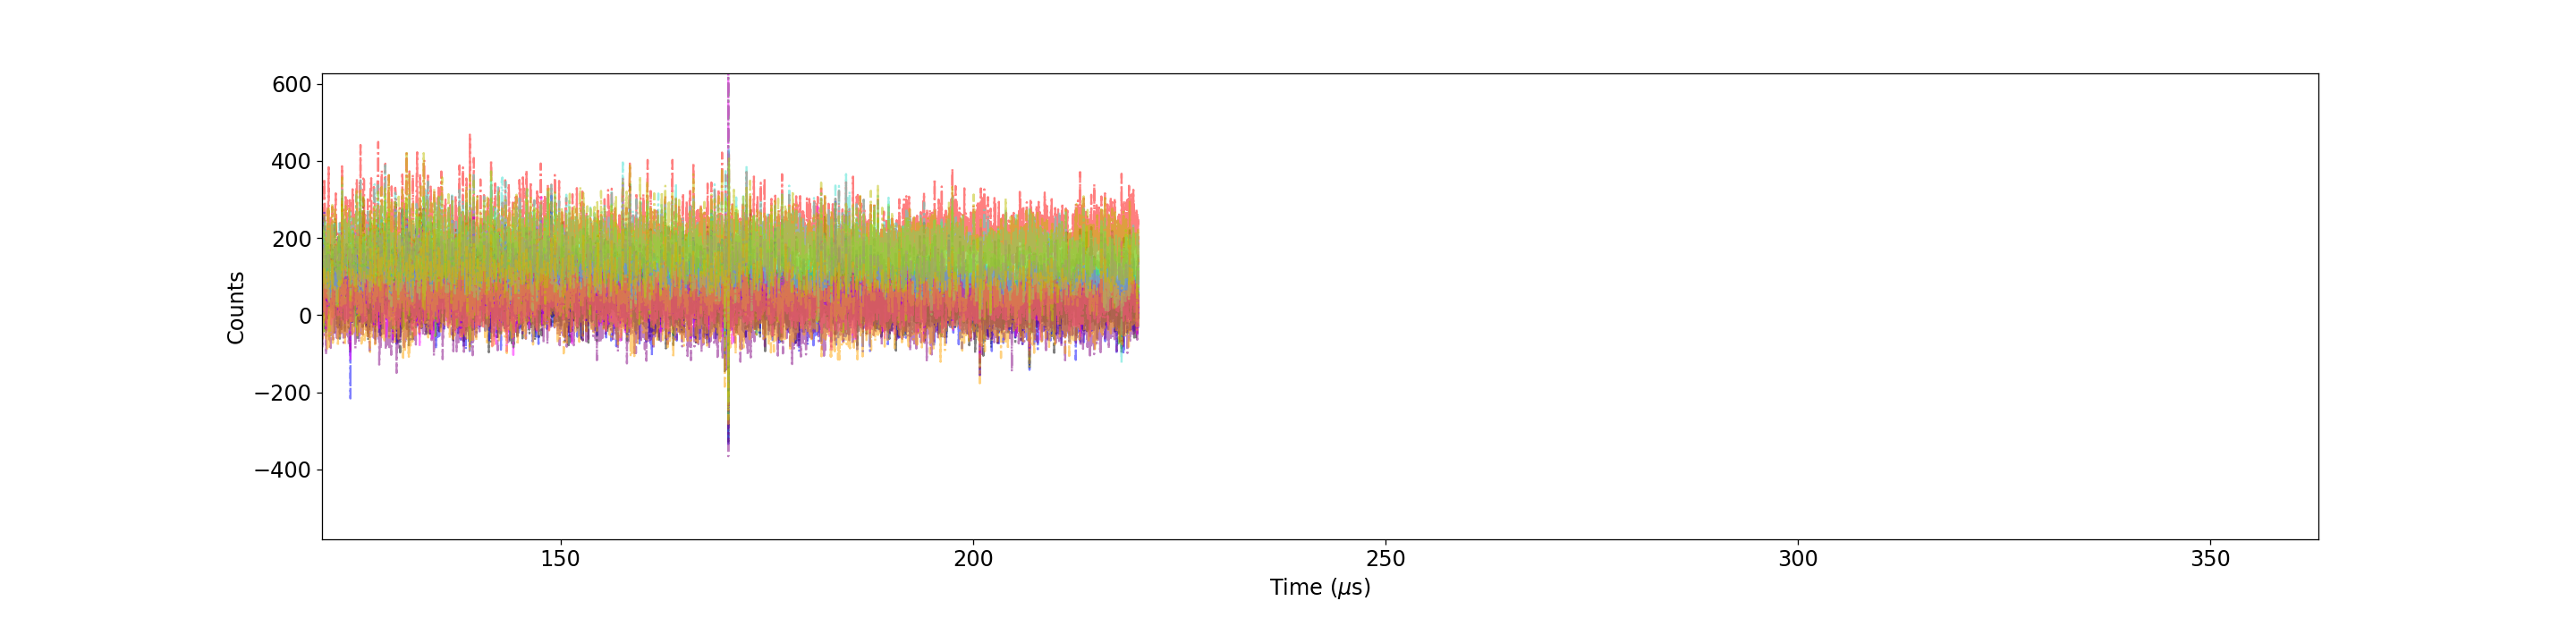

Text(0, 0.5, 'Counts')

In [384]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(25, 6))

plt.plot(time_full_flat[index_mask_finder(col_arrays_flat0, ymin)], 
         col_arrays_flat0[index_mask_finder(col_arrays_flat0, ymin)], "-.", color='k', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat1, ymin)], 
         col_arrays_flat1[index_mask_finder(col_arrays_flat1, ymin)], "-.", color='green', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat2, ymin)], 
         col_arrays_flat2[index_mask_finder(col_arrays_flat2, ymin)], "-.", color='r', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat3, ymin)], 
         col_arrays_flat3[index_mask_finder(col_arrays_flat3, ymin)], "-.", color='b', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat4, ymin)], 
         col_arrays_flat4[index_mask_finder(col_arrays_flat4, ymin)], "-.", color='purple', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat5, ymin)], 
         col_arrays_flat5[index_mask_finder(col_arrays_flat5, ymin)], "-.", color='lawngreen', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat6, ymin)], 
         col_arrays_flat6[index_mask_finder(col_arrays_flat6, ymin)], "-.", color='fuchsia', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat7, ymin)], 
         col_arrays_flat7[index_mask_finder(col_arrays_flat7, ymin)], "-.", color='turquoise', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat8, ymin)], 
         col_arrays_flat8[index_mask_finder(col_arrays_flat8, ymin)], "-.", color='orange', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat9, ymin)], 
         col_arrays_flat9[index_mask_finder(col_arrays_flat9, ymin)], "-.", color='y', alpha=0.5)
#plt.xlim(0, 6000)
#plt.ylim(-50, 400)
    
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Counts")

## extract masked times and column counts

In [385]:
masked_time0, maskedcol_arrays0 = masked_time_col(col_arrays_flat0, ymin)
masked_time1, maskedcol_arrays1 = masked_time_col(col_arrays_flat1, ymin)
masked_time2, maskedcol_arrays2 = masked_time_col(col_arrays_flat2, ymin)
masked_time3, maskedcol_arrays3 = masked_time_col(col_arrays_flat3, ymin)
masked_time4, maskedcol_arrays4 = masked_time_col(col_arrays_flat4, ymin)
masked_time5, maskedcol_arrays5 = masked_time_col(col_arrays_flat5, ymin)
masked_time6, maskedcol_arrays6 = masked_time_col(col_arrays_flat6, ymin)
masked_time7, maskedcol_arrays7 = masked_time_col(col_arrays_flat7, ymin)
masked_time8, maskedcol_arrays8 = masked_time_col(col_arrays_flat8, ymin)
masked_time9, maskedcol_arrays9 = masked_time_col(col_arrays_flat9, ymin)

all_masked_times = np.array([masked_time0, masked_time1, masked_time2, masked_time3, masked_time4, masked_time5,
                            masked_time6, masked_time7, masked_time8, masked_time9])
all_masked_cols = np.array([maskedcol_arrays0, maskedcol_arrays1, maskedcol_arrays2, maskedcol_arrays3, maskedcol_arrays4,
                            maskedcol_arrays5, maskedcol_arrays6, maskedcol_arrays7, maskedcol_arrays8, maskedcol_arrays9])
    

## Periodogram

In [386]:
%matplotlib inline
# import packages
from astropy.timeseries import LombScargle
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astropy.time import Time
import astropy.units as u

min freq: 0.00045446282494091483 max freq: 160.88029449190878
best period: 242.5601881874621
min freq: 0.00045446282494091483 max freq: 160.88029449190878
best period: 270.4018472213596
min freq: 0.00045446282494091483 max freq: 160.88029449190878
best period: 2200.400000000024
min freq: 0.00045446282494091483 max freq: 160.88029449190878
best period: 148.27774623628576
min freq: 0.00045446282494091483 max freq: 160.88029449190878
best period: 270.4018472213596
min freq: 0.00045446282494091483 max freq: 160.88029449190878
best period: 317.2538556404621
min freq: 0.00045446282494091483 max freq: 160.88029449190878
best period: 0.43043972284131055
min freq: 0.00045446282494091483 max freq: 160.88029449190878
best period: 115.5623218264994
min freq: 0.00045446282494091483 max freq: 160.88029449190878
best period: 0.1075335966920136
min freq: 0.00045446282494091483 max freq: 160.88029449190878
best period: 502.6561522929569


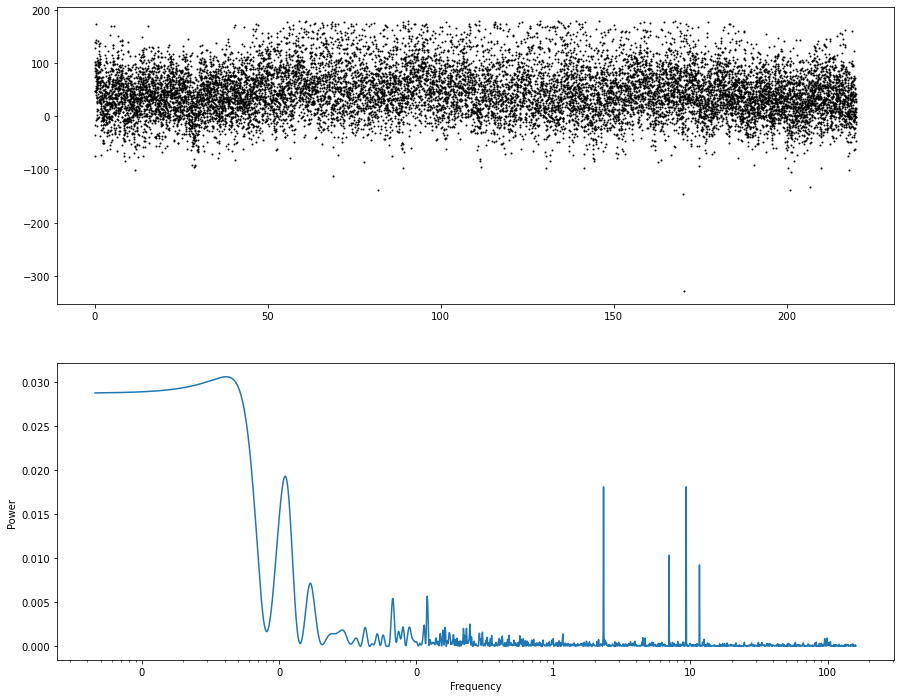

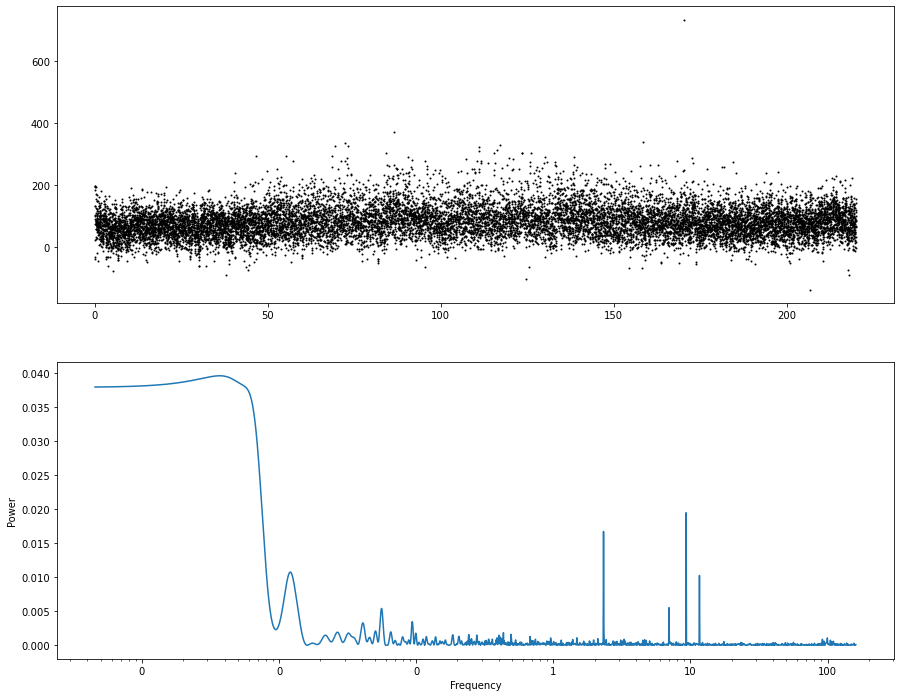

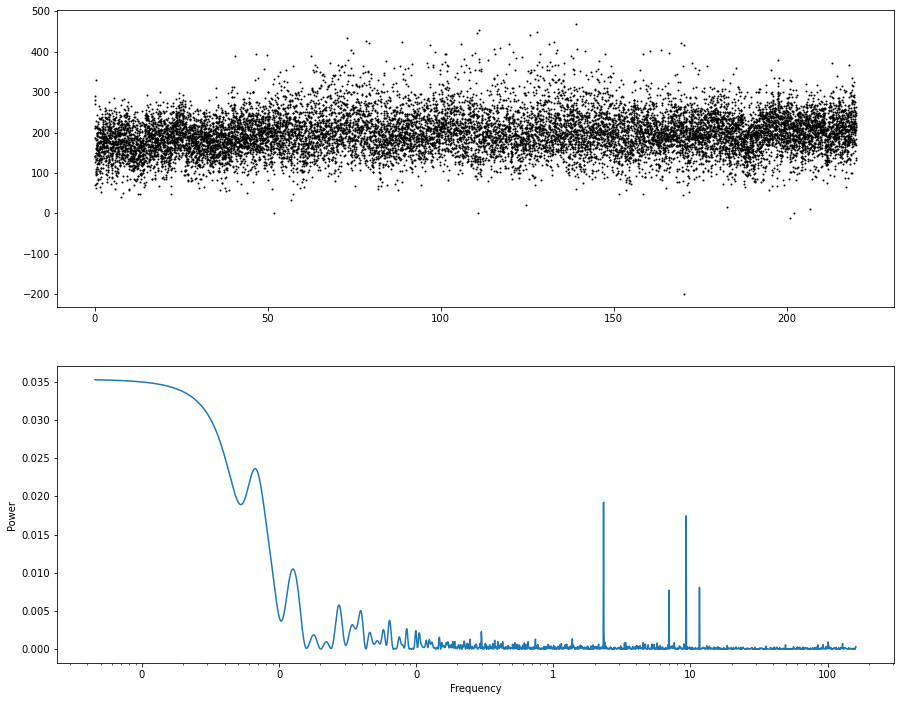

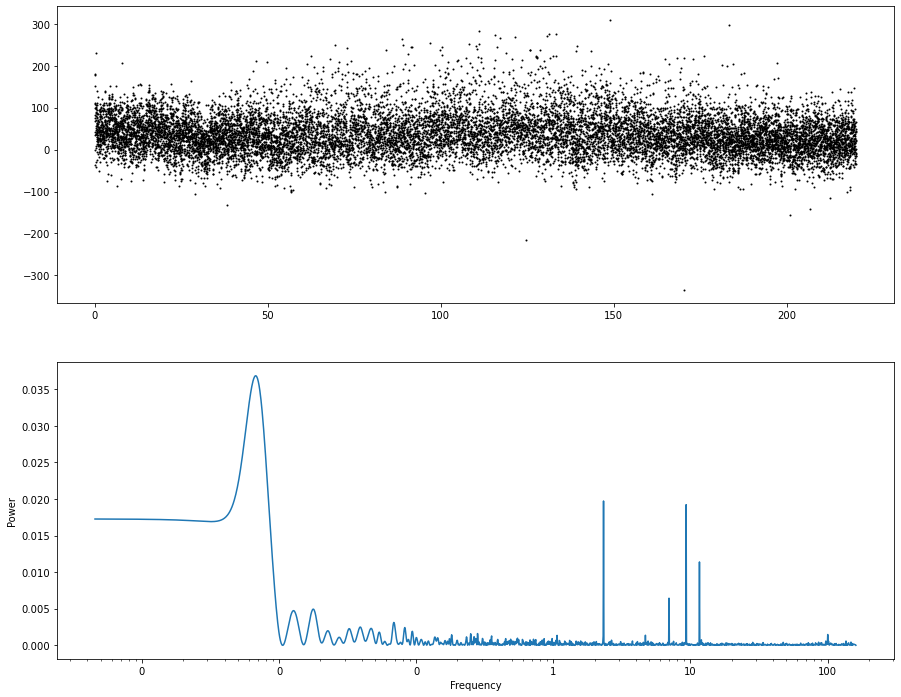

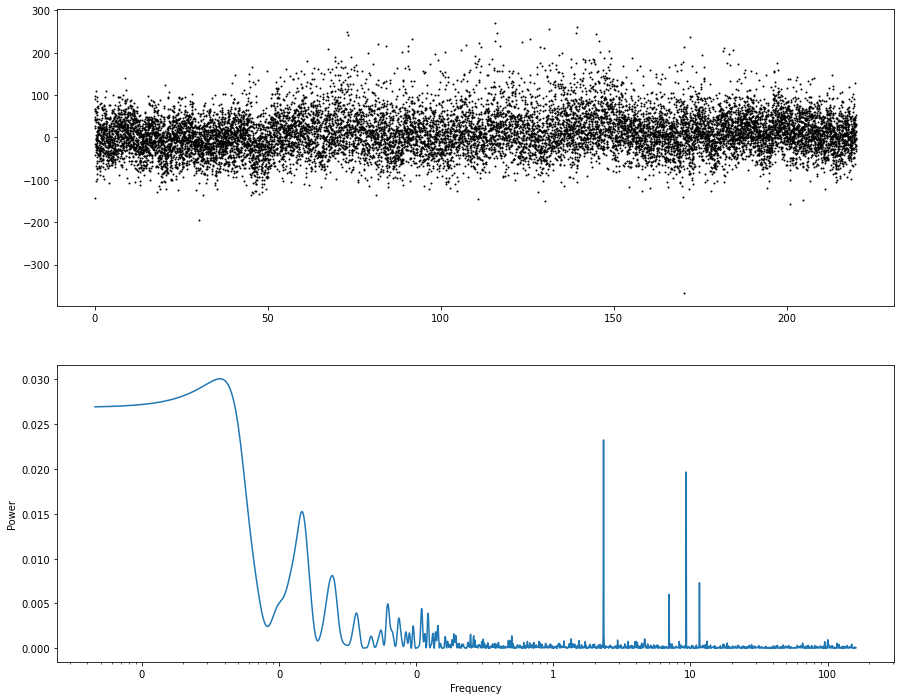

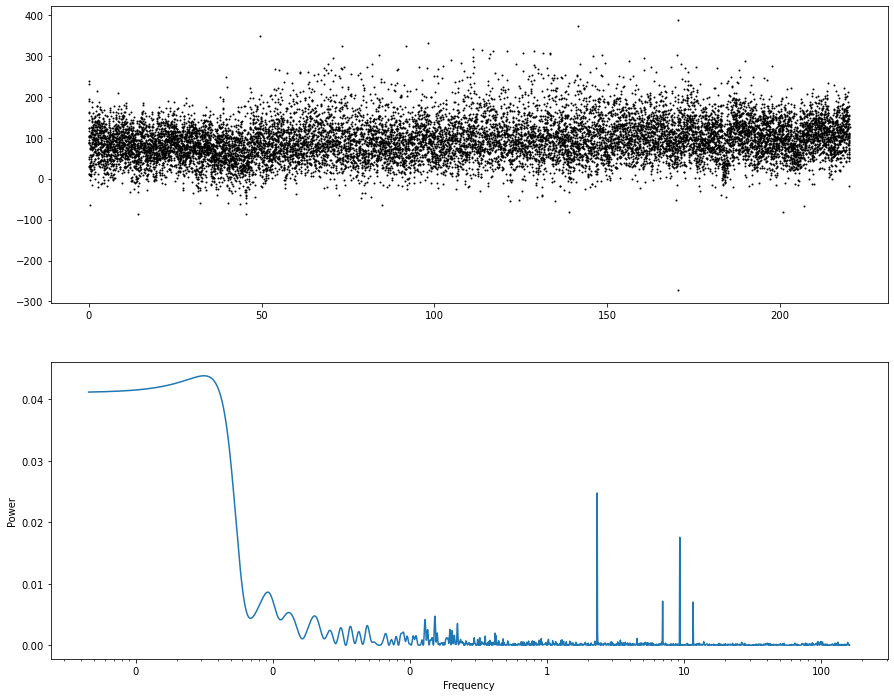

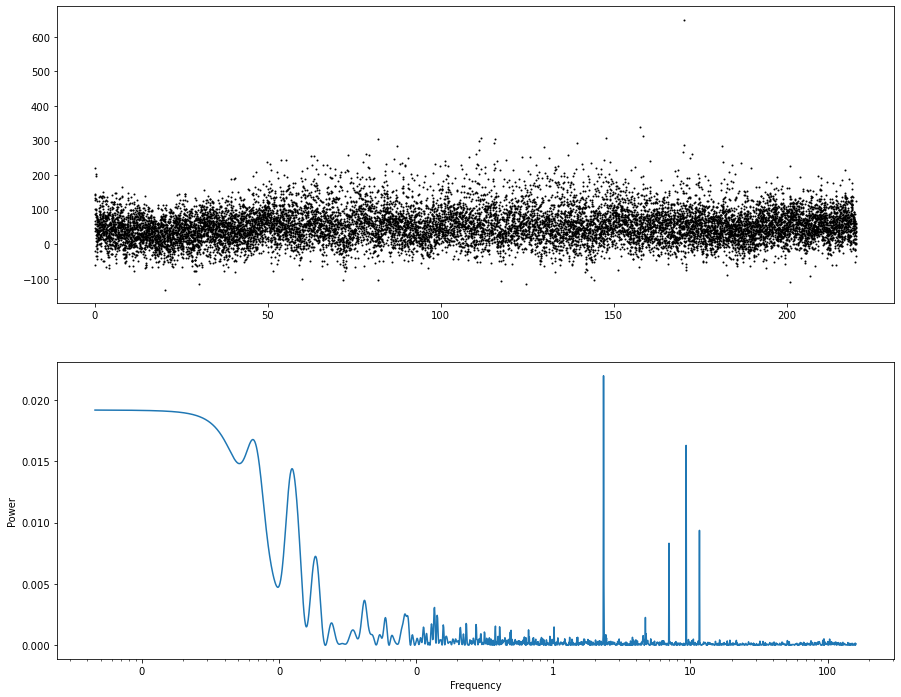

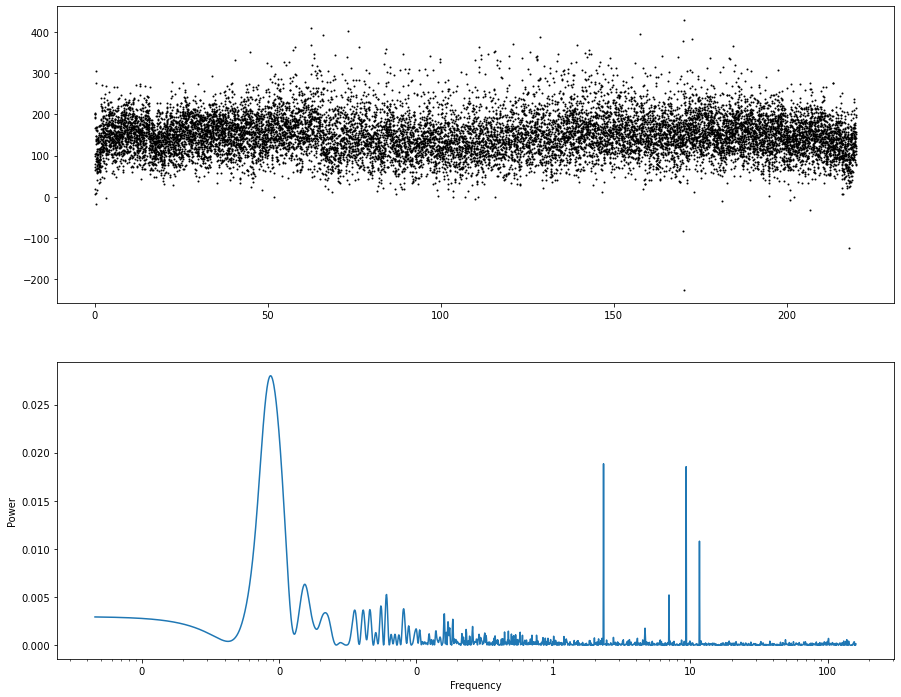

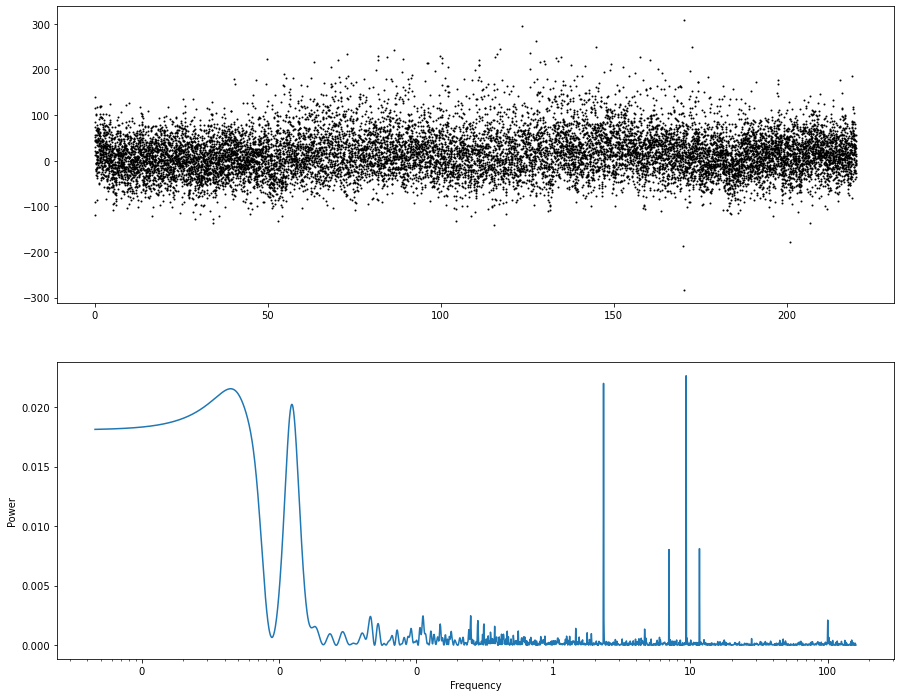

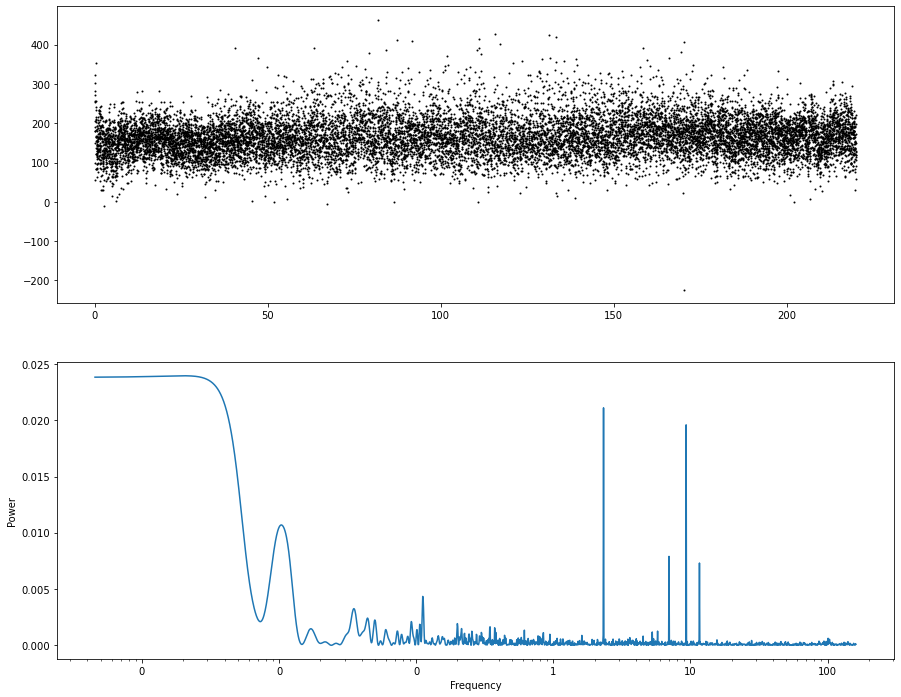

In [387]:
from matplotlib.ticker import ScalarFormatter

frequency_list = []
power_list = []

for num in range(0, len(all_masked_times)):
    x = all_masked_times[num]
    y = all_masked_cols[num]

    # plot with labels and synthetic planet of amplitude 0.78 m/s and 1 year period
    fig, axes = plt.subplots(2,1,figsize=(15, 12))
    ax = axes[0]
    ax.plot(x, y,".", color='k')

    frequency, power = LombScargle(x, y).autopower()
    min_freq = 0.00045446282494091483#np.min(frequency)
    max_freq = 160.88029449190878#np.max(frequency)
    print("min freq: "+str(min_freq)+" max freq: "+str(max_freq))

    frequency2 = np.geomspace(min_freq, max_freq, 2000)#len(frequency))
    power = LombScargle(x, y).power(frequency2)
    
    frequency_list.append(frequency2)
    power_list.append(power)

    ax = axes[1]
    ax.plot(frequency2, power)
    #plt.xlim(0,100)
    ax.set_xscale('log')
    ax.set_xscale('log')
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    #plt.ylim(-0.005, 0.03)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    best_frequency = frequency2[np.argmax(power)]
    print("best period: "+str(1/best_frequency))

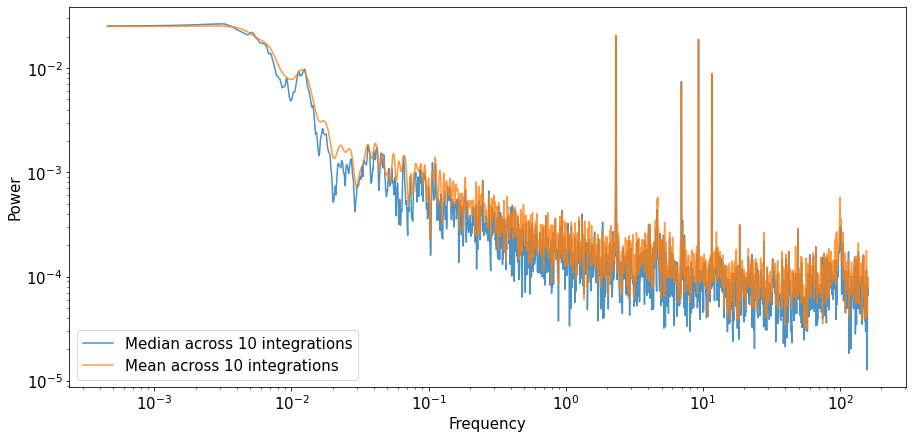

In [388]:
plt.rcParams['font.size'] = 15

med_freq = np.median(frequency_list, axis=0)
med_power = np.median(power_list, axis=0)

mean_freq = np.mean(frequency_list, axis=0)
mean_power = np.mean(power_list, axis=0)


fig, ax = plt.subplots(1,1,figsize=(15, 7))
ax.plot(med_freq, med_power, label="Median across 10 integrations", alpha=0.8)
ax.plot(mean_freq, mean_power, label="Mean across 10 integrations", alpha=0.8)
#ax.plot(mean_freq, (1/(mean_freq**2)), label="1/f")
ax.set_xscale('log')
ax.set_yscale('log')
#for axis in [ax.xaxis, ax.yaxis]:
#    axis.set_major_formatter(ScalarFormatter())
#plt.ylim(-0.005, 0.03)
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.legend()

In [389]:
import pandas as pd

# write these results to a csv for later visulation purposes
data = {'med_freq': med_freq,
       'mean_freq': mean_freq,
        'med_power': med_power,
       'mean_power': mean_power}

pd_csv = pd.DataFrame(data = data)
#pd_csv.to_csv("original_power_spectrum.csv")


In [390]:
# Do periodogram again for the new way to mask pixels

time_mask_arrays, col_corr_arrays, col_values_list, image = median_sig_cleanup(integr_nums=10, 
                                                                                           group_nums=3,
                                                                                           rowsize=512)

In [391]:
print(len(time_mask_arrays))
#len(col_corr_arrays[0])


15360


0
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
1
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1770603.7098332827
2
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
3
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1924012.7350021352
4
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
5
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2144855.681015217
6
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2012051.8752585028
7
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1986494.6202155082
8
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2051005.5907404257
9
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2051005.5907404257
10
min freq: 4.544628249409198e-07 max freq: 0.1608

2022-03-23 15:54:30,026 - stpipe - WARNING - /var/folders/rn/06tzsshx6h542jl02_xd33t80000gn/T/ipykernel_25996/2144223004.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(2,1,figsize=(15, 12))



min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2117611.540670631
21
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2090713.4577273394
22
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2144855.681015217
23
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
24
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2090713.4577273394
25
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
26
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2024953.542271036
27
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1948766.129083356
28
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2144855.681015217
29
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2117611.540670631
30
min freq: 4.544628249409198e-07 max 

best period: 2158608.911797517
106
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
107
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
108
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
109
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
110
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2144855.681015217
111
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2024953.542271036
112
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2117611.540670631
113
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
114
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
115
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
116
min fre

min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
192
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2144855.681015217
193
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2104119.5180689767
194
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1948766.129083356
195
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2051005.5907404257
196
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2104119.5180689767
197
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
198
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
199
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2131190.076739001
200
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2012051.8752585028
201
min freq: 4.5446282494091

min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2064157.0365346237
277
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2051005.5907404257
278
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
279
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1973837.9880621284
280
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1973837.9880621284
281
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
282
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
283
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2117611.540670631
284
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
285
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
286
min freq: 4.544628249409198e-07 max fre

min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
362
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
363
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2104119.5180689767
364
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2131190.076739001
365
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
366
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2144855.681015217
367
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1948766.129083356
368
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
369
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2117611.540670631
370
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
371
min freq: 4.544628249409198e-07 max freq: 0.16088029

min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1924012.7350021352
447
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
448
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2117611.540670631
449
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
450
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1899573.7606500941
451
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
452
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2024953.542271036
453
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2037937.937275699
454
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1948766.129083356
455
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2012051.8752585028
456
min freq: 4.5446282494091

best period: 2158608.911797517
531
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2090713.4577273394
532
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1887470.9308250863
533
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
534
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2037937.937275699
535
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
536
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2012051.8752585028
537
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2144855.681015217
538
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2090713.4577273394
539
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
540
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
54

best period: 2172450.3309640675
616
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1936349.87796555
617
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
618
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2064157.0365346237
619
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
620
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2104119.5180689767
621
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
622
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2077392.8119509588
623
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
624
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2024953.542271036
625
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2090713.4577273394
626

min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1986494.6202155082
702
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2144855.681015217
703
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
704
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2104119.5180689767
705
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
706
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2104119.5180689767
707
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
708
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
709
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2090713.4577273394
710
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
711
min freq: 4.544628249409198e-0

min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
787
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2077392.8119509588
788
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
789
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
790
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
791
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2024953.542271036
792
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
793
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2117611.540670631
794
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
795
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2090713.4577273394
796
min freq: 4.544628249409198e-07 m

best period: 2172450.3309640675
872
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2037937.937275699
873
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
874
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
875
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
876
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
877
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2117611.540670631
878
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2037937.937275699
879
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
880
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
881
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
882
min freq: 4.5446282494091

min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2012051.8752585028
958
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
959
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2037937.937275699
960
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
961
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 1961261.9956123966
962
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2186380.5039958917
963
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2104119.5180689767
964
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2172450.3309640675
965
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2117611.540670631
966
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2158608.911797517
967
min freq: 4.54462824940

2022-03-23 15:54:58,036 - stpipe - WARNING - /Users/zdebeurs/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/core.py:232: RuntimeWarning: divide by zero encountered in double_scalars
  df = 1.0 / baseline / samples_per_peak

2022-03-23 15:54:58,036 - stpipe - WARNING - /Users/zdebeurs/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/core.py:238: RuntimeWarning: divide by zero encountered in double_scalars
  avg_nyquist = 0.5 * n_samples / baseline

2022-03-23 15:54:58,037 - stpipe - WARNING - /Users/zdebeurs/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/core.py:241: RuntimeWarning: invalid value encountered in double_scalars
  Nf = 1 + int(np.round((maximum_frequency - minimum_frequency) / df))



ValueError: cannot convert float NaN to integer

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd2b28fc1f0> (for post_execute):


KeyboardInterrupt: 

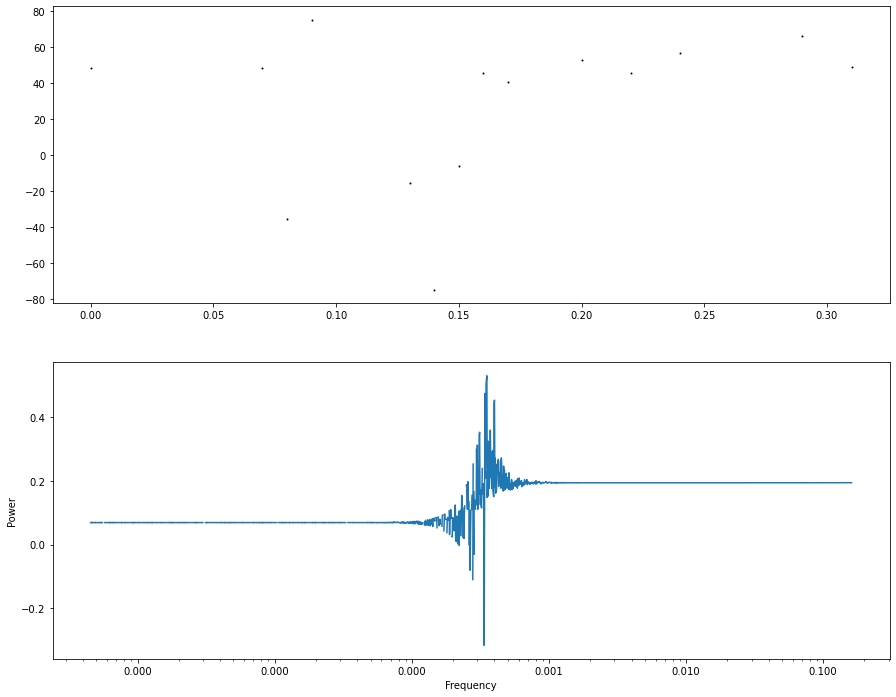

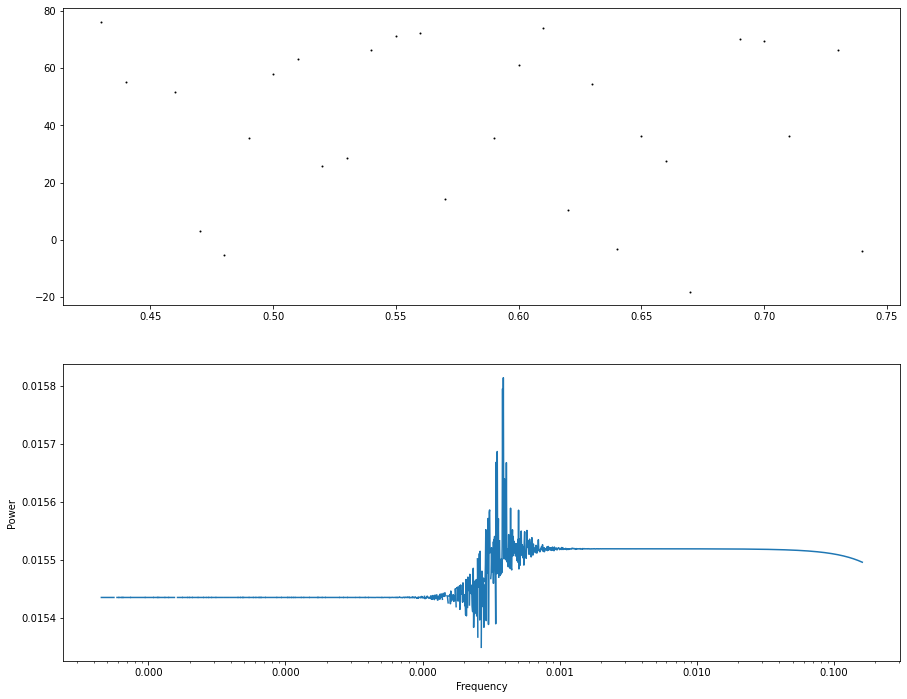

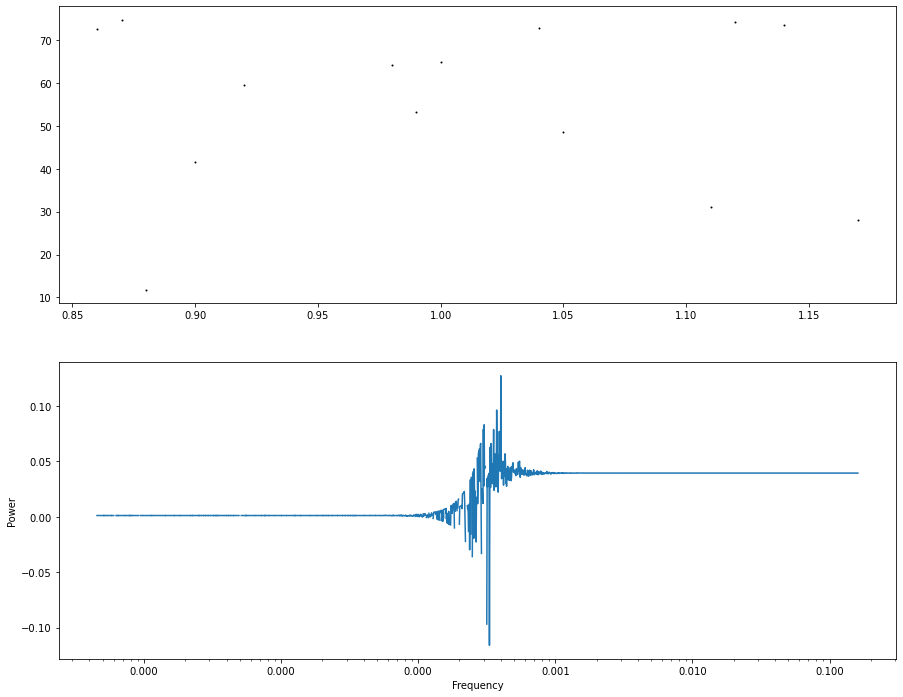

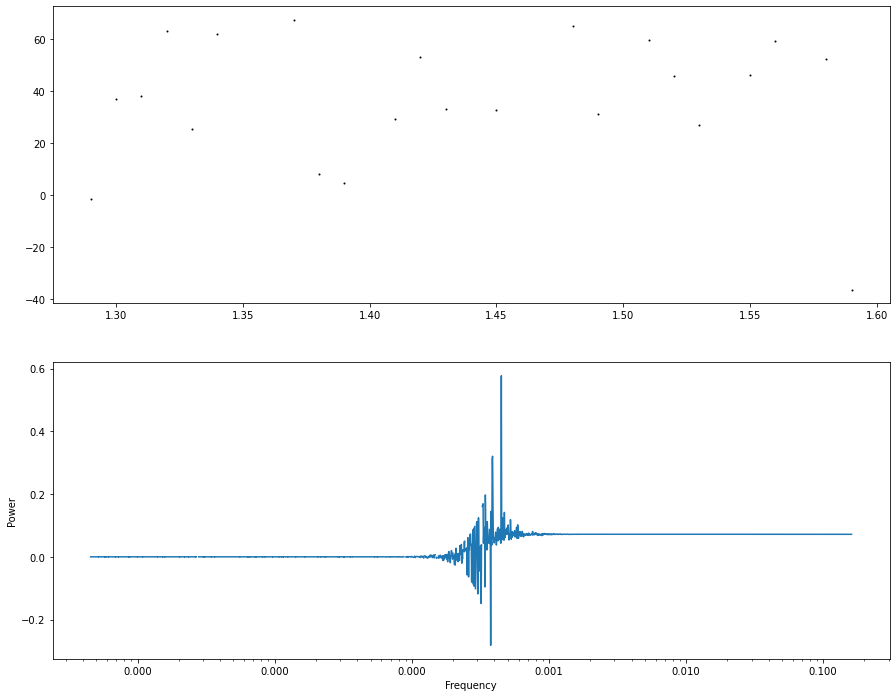

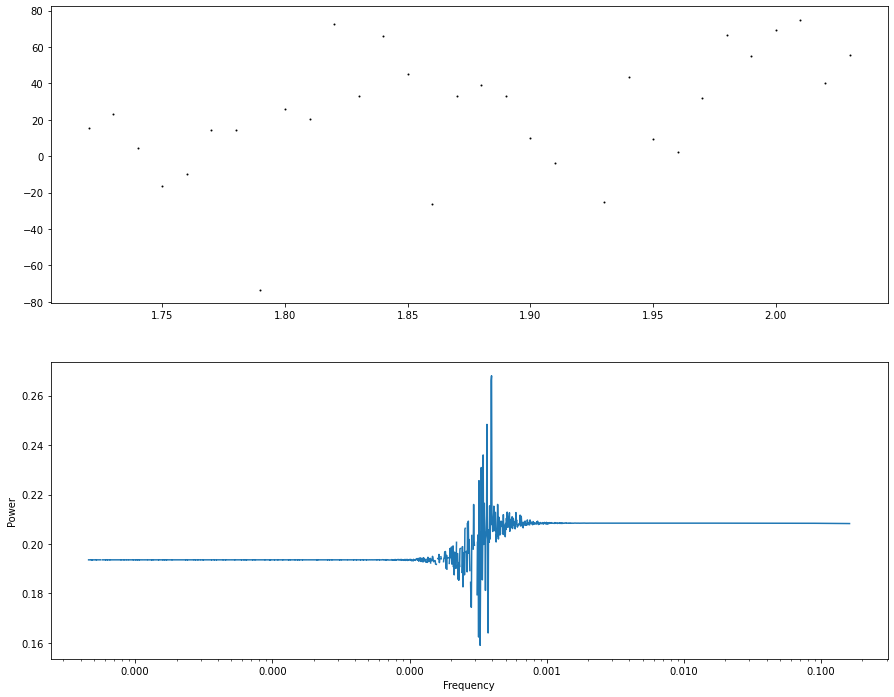

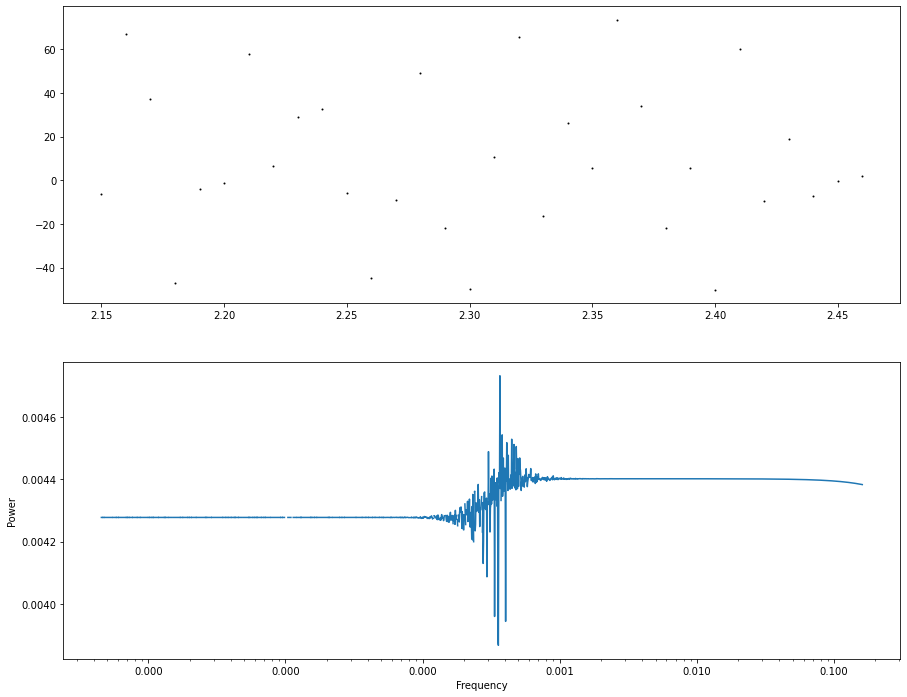

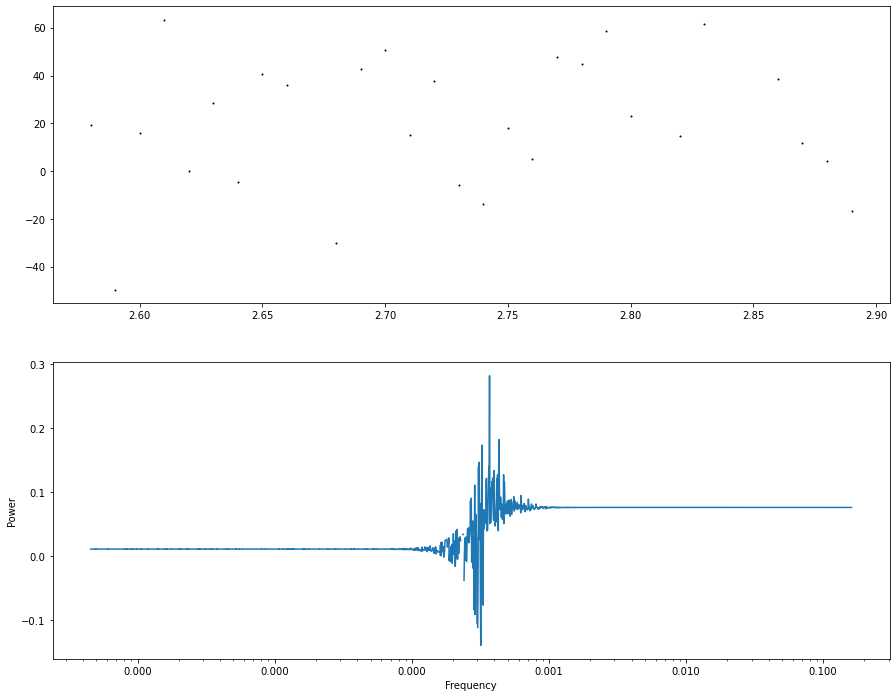

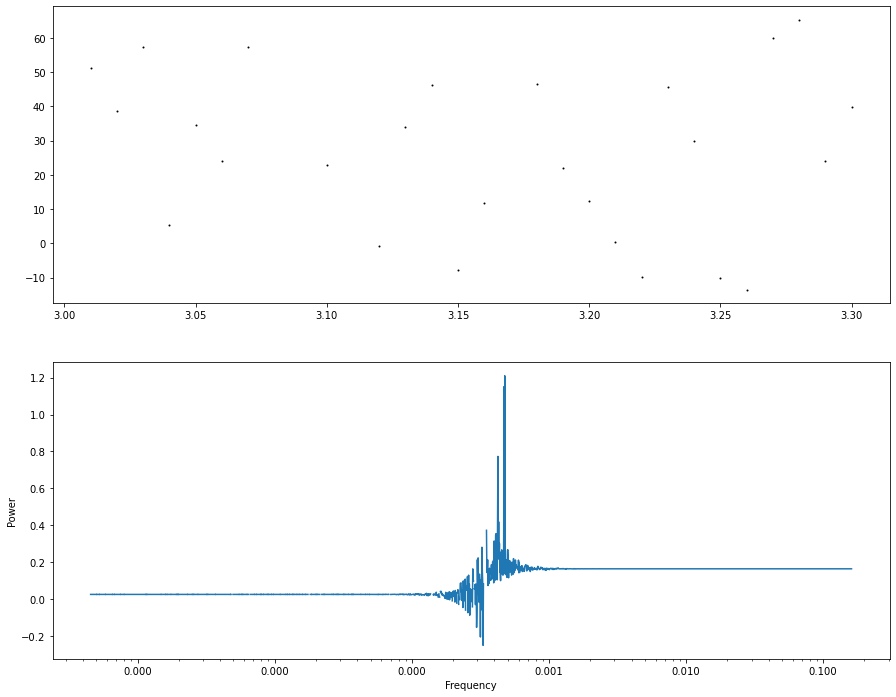

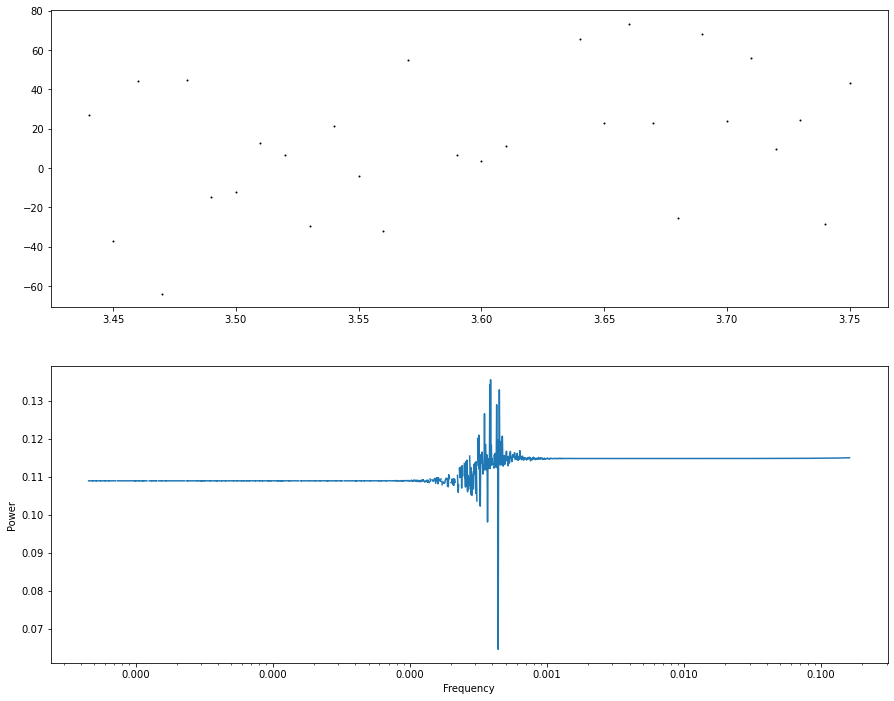

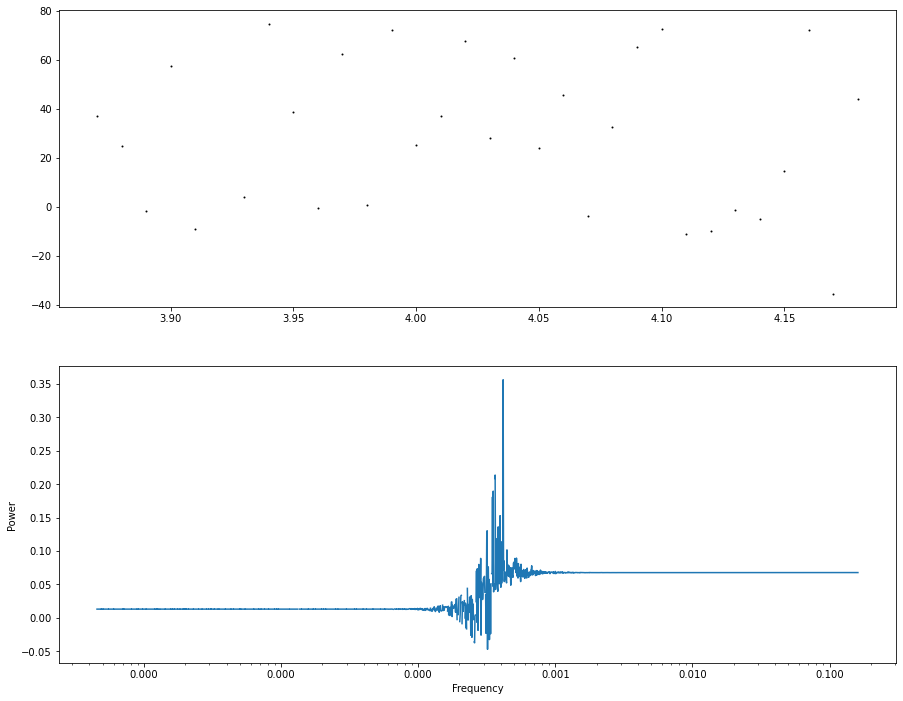

Error in callback <function flush_figures at 0x7fd2b290d940> (for post_execute):


KeyboardInterrupt: 

In [392]:
%matplotlib inline

frequency_list = []
power_list = []

for num in range(0, len(time_mask_arrays)):
    print(num)
    x = time_mask_arrays[num]
    y = col_corr_arrays[num]

    # plot with labels and synthetic planet of amplitude 0.78 m/s and 1 year period
    fig, axes = plt.subplots(2,1,figsize=(15, 12))
    ax = axes[0]
    ax.plot(x, y,".", color='k')

    frequency, power = LombScargle(x, y).autopower()
    min_freq = 4.544628249409198e-07 #np.min(frequency)
    max_freq = 0.16088029449191055 #np.max(frequency)
    print("min freq: "+str(min_freq)+" max freq: "+str(max_freq))

    frequency2 = np.geomspace(min_freq, max_freq, 2000)#len(frequency))
    power = LombScargle(x, y).power(frequency2)
    
    frequency_list.append(frequency2)
    power_list.append(power)

    ax = axes[1]
    ax.plot(frequency2, power)
    #plt.xlim(0,100)
    ax.set_xscale('log')
    ax.set_xscale('log')
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    #plt.ylim(-0.005, 0.03)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    best_frequency = frequency2[np.argmax(power)]
    print("best period: "+str(1/best_frequency))

## Line subtraction

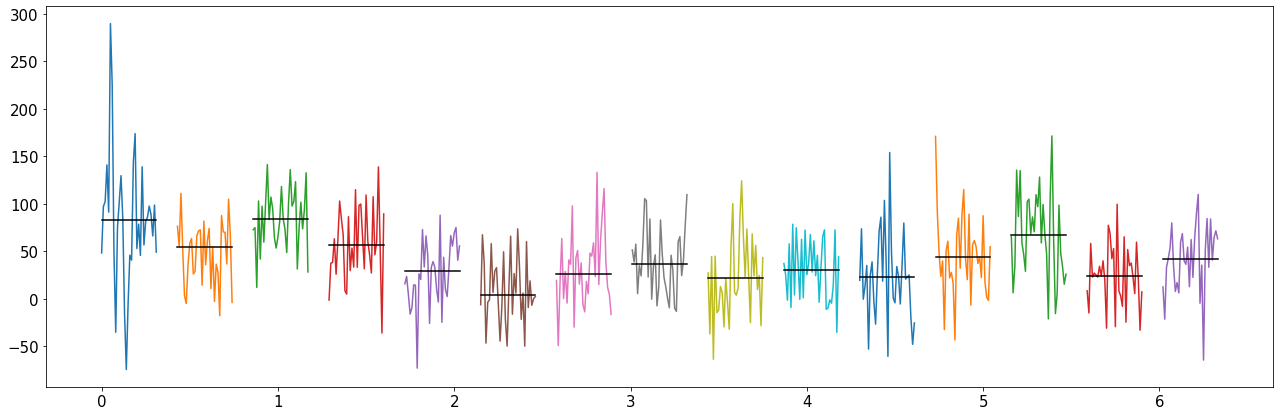

In [310]:
time_np = np.arange(0, 320, 10)

fig, ax = plt.subplots(1,1,figsize=(22, 7))
for number in range(0, 15):#len(col_arrays0)):
    median_col = np.median(col_arrays0[number])
    mean_col = np.mean(col_arrays0[number])
    plt.plot(time_full[number], col_arrays0[number])
    plt.plot(time_full[number], [median_col]*len(time_full[number]), color='k')
    
#fig, ax = plt.subplots(1,1,figsize=(22, 7))
#for number in range(15, 30):#len(col_arrays0)):
#    plt.plot(time_full[number], col_arrays0[number])

In [311]:
np.shape(np.transpose(time_full[number]).reshape((32, 1)))

(32, 1)

In [ ]:
np.shape(np.transpose(time_full[number]))

def LS_fit(time_full, numbers, col_arrays, order):

    a_coeff_list = []
    x_list = []
    
    for number in numbers:
        # perform the L-S fit --------------
        n_cols = len(time_full[number])# + 1
        n_rows = len(col_arrays)  # len(ccf_list_np)<---- unsmoothed
        x = np.zeros((n_cols,order+1))

        if order == 1:
            x[:, 0] = 1
            x[:, 1] = time_full[number]
            
        if order == 2:
            x[:, 0] = 1
            x[:, 1] = time_full[number]
            x[:, 2] = time_full[number]**2
            
        if order == 3:
            x[:, 0] = 1
            x[:, 1] = time_full[number]
            x[:, 2] = time_full[number]**2
            x[:, 3] = time_full[number]**3


        #for i in np.arange(1, 32):
        #    x[:, i] = np.transpose(time_full[number]).reshape((32, 1))[i]  # (for all observations)
        y = col_arrays[number]

        alpha = x.transpose().dot(x)
        beta = x.transpose().dot(y)

        # and finally we can write a_coeff = alpha^-1 * beta
        inv_alpha = np.linalg.inv(alpha)
        a_coeff = inv_alpha.dot(beta)
        a_coeff_list.append(a_coeff.tolist())
        x_list.append(x.tolist())
        
    return a_coeff_list, x_list

In [ ]:
def LS_fit_one(time_full, col_arrays, order):

    # perform the L-S fit --------------
    n_cols = len(time_full)# + 1
    n_rows = len(col_arrays)  # len(ccf_list_np)<---- unsmoothed
    x = np.zeros((n_rows,order+1))
    
    if order == 1:
        x[:, 0] = 1
        x[:, 1] = time_full
    
    if order == 2:
        x[:, 0] = 1
        x[:, 1] = time_full
        x[:, 2] = time_full**2
        
    if order == 3:
        x[:, 0] = 1
        x[:, 1] = time_full
        x[:, 2] = time_full**2
        x[:, 3] = time_full**3
    

    #for i in np.arange(1, 32):
    #    x[:, i] = np.transpose(time_full[number]).reshape((32, 1))[i]  # (for all observations)
    y = col_arrays

    alpha = x.transpose().dot(x)
    beta = x.transpose().dot(y)

    # and finally we can write a_coeff = alpha^-1 * beta
    inv_alpha = np.linalg.inv(alpha)
    a_coeff = inv_alpha.dot(beta)
        
    return a_coeff, x

In [ ]:
def return_xfull(time_full):
    x = np.zeros((32,2))

    x[:, 0] = 1
    x[:, 1] = time_full
    #x[:, 2] = time_full**2
    
    return x

In [ ]:
masked_col_array0 = []
masked_time_full = []
for num in range(0, len(col_arrays0)):
    masked_col_array0.append(np.array(col_arrays0[num])[np.where(np.array(col_arrays0[num])<ymin)])
    masked_time_full.append(np.array(time_full[num])[np.where(np.array(col_arrays0[num])<ymin)])
                    
len(masked_col_array0)

In [316]:
masked_time_full[0]

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12,
       0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23,
       0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31])

In [32]:
    a_coeff_list = []
    x_list = []
    
    numbers_max = 5
    numbers =np.arange(0, numbers_max)
    
    for number in numbers:
        # perform the L-S fit --------------
        n_cols = len(masked_time_full[number])# + 1
        n_rows = len(masked_col_array0)  # len(ccf_list_np)<---- unsmoothed
        x = np.zeros((n_cols,3))

        x[:, 0] = 1
        x[:, 1] = masked_time_full[number]
        x[:, 2] = masked_time_full[number]**2


        #for i in np.arange(1, 32):
        #    x[:, i] = np.transpose(time_full[number]).reshape((32, 1))[i]  # (for all observations)
        y = masked_col_array0[number]

        alpha = x.transpose().dot(x)
        beta = x.transpose().dot(y)

        # and finally we can write a_coeff = alpha^-1 * beta
        inv_alpha = np.linalg.inv(alpha)
        a_coeff = inv_alpha.dot(beta)
        a_coeff_list.append(a_coeff.tolist())
        x_list.append(x.tolist())

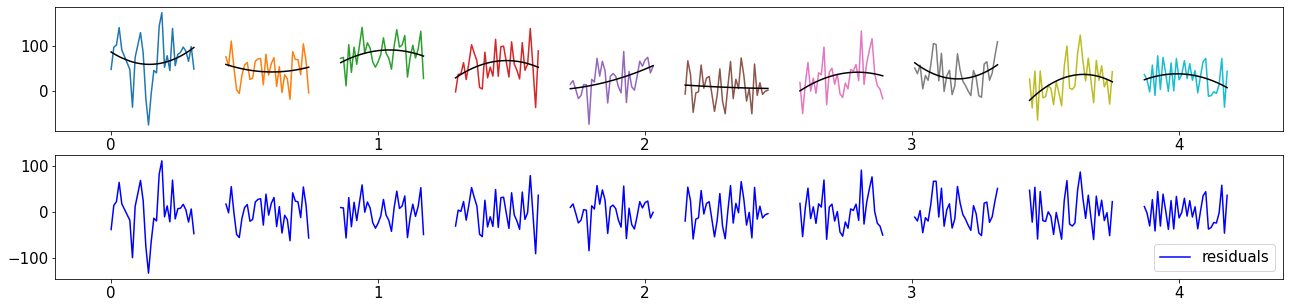

In [319]:
numbers_max = 10#512

a_coeff_list, x_list = LS_fit(masked_time_full, np.arange(0, numbers_max), masked_col_array0, 2) #time_full, np.arange(0, numbers_max), col_arrays0)#

fig, axes = plt.subplots(2,1,figsize=(22, 5))

ax = axes[0]
for number in range(0, numbers_max):#len(col_arrays0)):
    ax.plot(masked_time_full[number], masked_col_array0[number])
    ax.plot(masked_time_full[number], np.array(x_list[number]).dot(a_coeff_list[number]), color='k')

#ax.set_xlim(42000, 50000)
    
ax = axes[1]
number = 0
ax.plot(masked_time_full[number], masked_col_array0[number]-np.array(x_list[number]).dot(a_coeff_list[number]), 
            label="residuals", color='b')
for number in range(1, numbers_max):#len(col_arrays0)):
    ax.plot(masked_time_full[number], masked_col_array0[number]-np.array(x_list[number]).dot(a_coeff_list[number]), 
            color='b')
    
ax.legend()

In [320]:
masked_time_full[number]

array([3.87, 3.88, 3.89, 3.9 , 3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97,
       3.98, 3.99, 4.  , 4.01, 4.02, 4.03, 4.04, 4.05, 4.06, 4.07, 4.08,
       4.09, 4.1 , 4.11, 4.12, 4.13, 4.14, 4.15, 4.16, 4.17, 4.18])

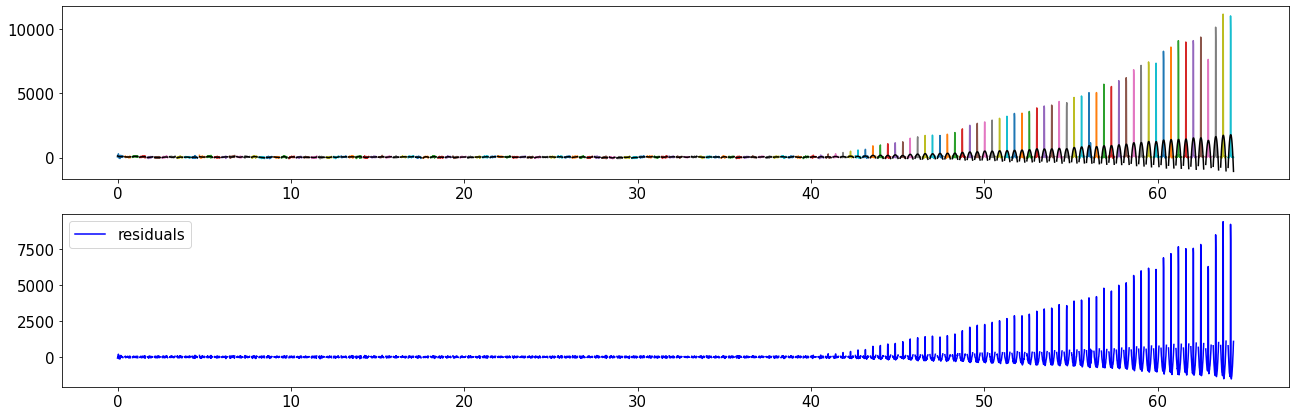

In [327]:
numbers_min = 0
numbers_max = 150#512

a_coeff_list, x_list = LS_fit(time_full, np.arange(numbers_min, numbers_max), col_arrays0, 2)

fig, axes = plt.subplots(2,1,figsize=(22, 7))


ax = axes[0]
for number in range(numbers_min, numbers_max):#len(col_arrays0)):
    ax.plot(time_full[number], col_arrays0[number])
    ax.plot(time_full[number], np.array(x_list[number]).dot(a_coeff_list[number]), color='k')

#ax.set_xlim(60, 70)
    
ax = axes[1]
number = 0
ax.plot(time_full[number], col_arrays0[number]-np.array(x_list[number]).dot(a_coeff_list[number]), 
            label="residuals", color='b')
for number in range(1, numbers_max):#len(col_arrays0)):
    ax.plot(time_full[number], col_arrays0[number]-np.array(x_list[number]).dot(a_coeff_list[number]), 
            color='b')

ax.legend()

In [328]:
len(col_arrays0)

512

In [329]:
len(col_arrays0[number])

32

## Visualize images before correction

0
1
2
3
4
5
6
7
8
9


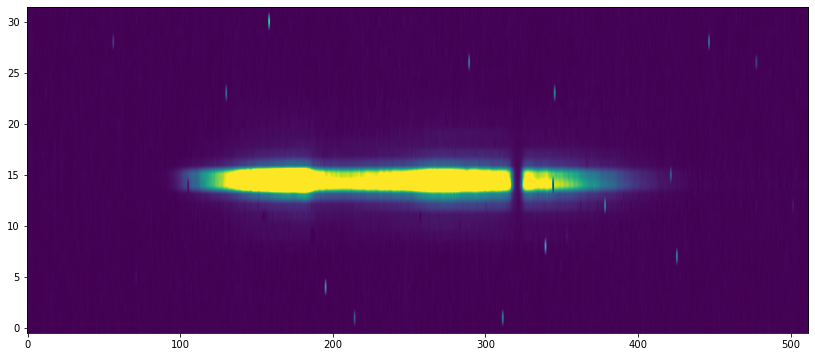

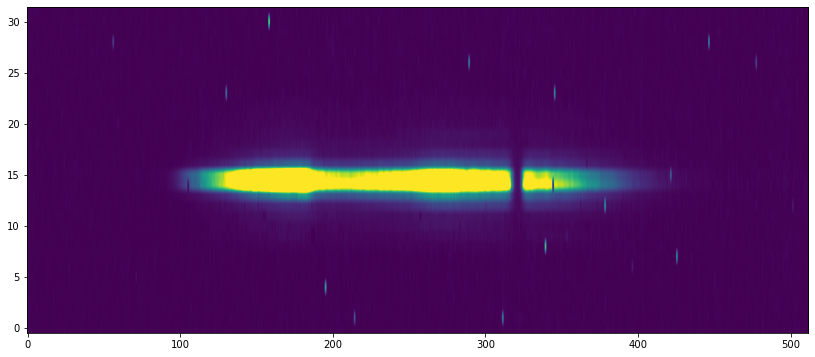

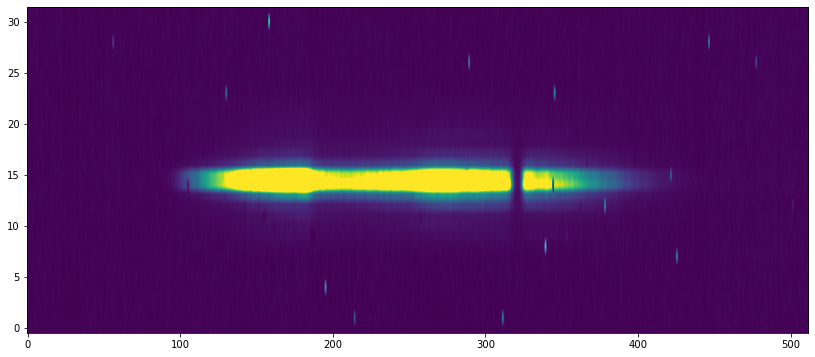

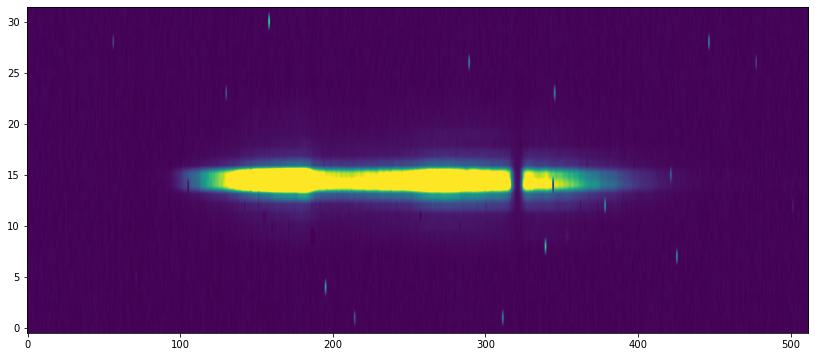

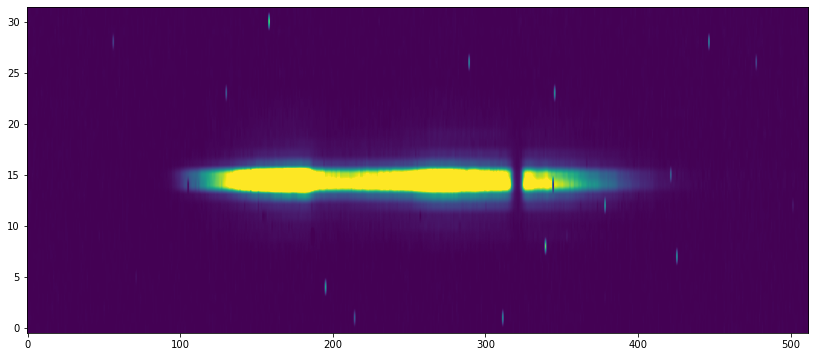

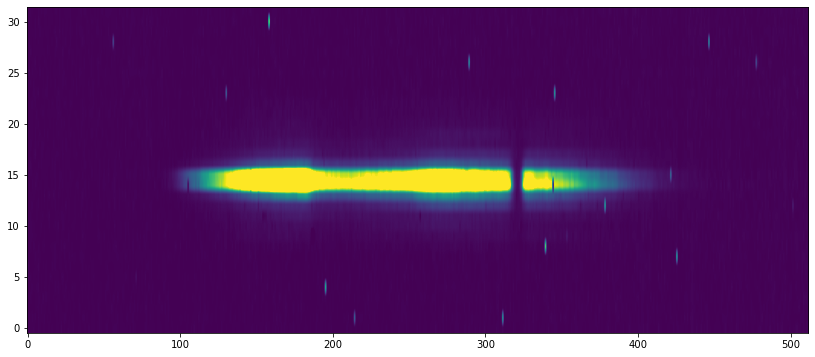

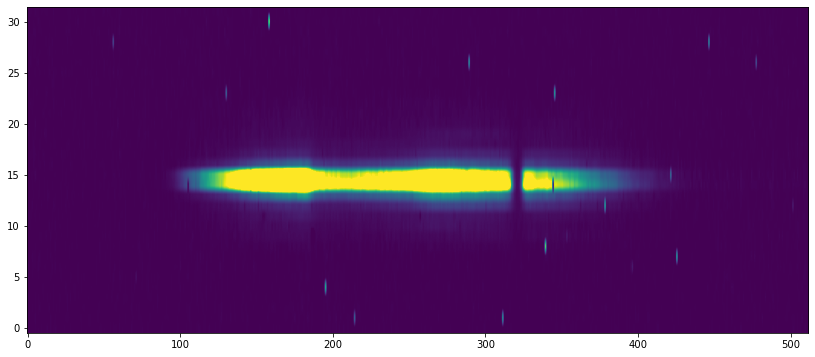

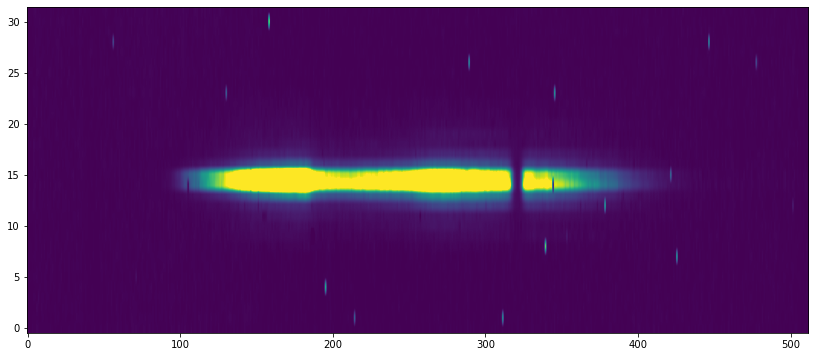

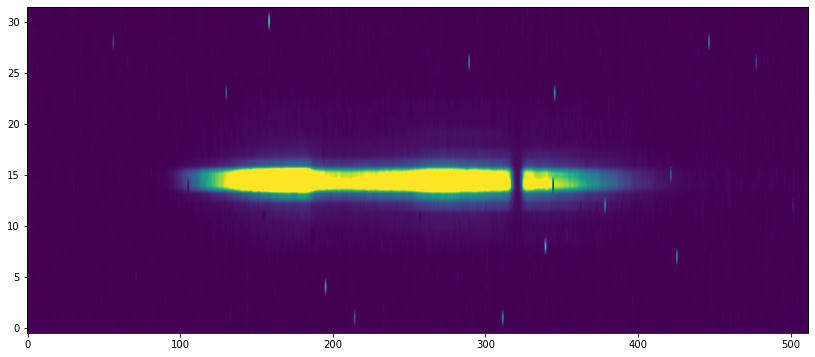

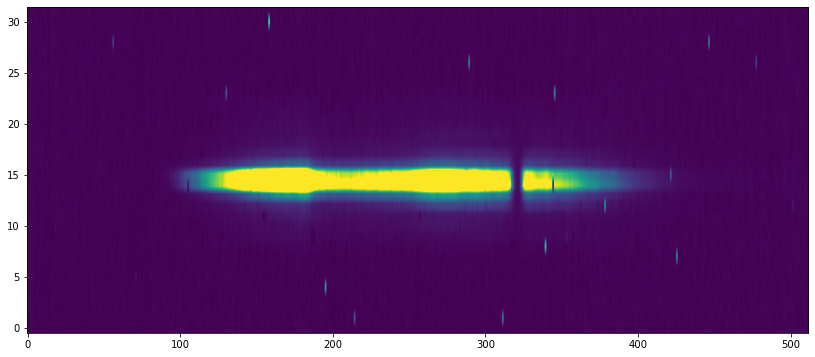

In [331]:
%matplotlib inline
for i in range(0, 10):
    print(i)
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    im  = plt.imshow(hdul[1].data[i,1,:,:,], origin = 'lower', aspect='auto',  vmin=0, vmax=1e4)


In [332]:
np.shape(hdul[1].data[:,:,:,:,])

(10, 3, 32, 512)

## Linear Correction

In [45]:
integr_num = 0
group_num = 0
col_num = 235
col_values= hdul[1].data[integr_num,group_num,:,col_num]
#print(col_values)
col_values[np.where(col_values<ymin)]
print(time_full[col_num][np.where(col_values<ymin)], col_values[np.where(col_values<ymin)])
if len(time_full[col_num][np.where(col_values<ymin)])<2:
    print("too short")
    
    
time_input = time_full[col_num][np.where(col_values<ymin)]
col_input = col_values[np.where(col_values<ymin)]

# perform the L-S fit --------------
n_cols = len(time_input)# + 1
n_rows = len(col_input)  # len(ccf_list_np)<---- unsmoothed
x = np.zeros((n_rows,3))

x[:, 0] = 1
x[:, 1] = time_input
x[:, 2] = time_input[number]**2



#for i in np.arange(1, 32):
#    x[:, i] = np.transpose(time_full[number]).reshape((32, 1))[i]  # (for all observations)
y = col_input

alpha = x.transpose().dot(x)
beta = x.transpose().dot(y)

# and finally we can write a_coeff = alpha^-1 * beta
inv_alpha = np.linalg.pinv(alpha)
a_coeff = inv_alpha.dot(beta)    

#a_coeff, x = LS_fit_one(time_full[col_num][np.where(col_values<ymin)], col_values[np.where(col_values<ymin)])

[101050 101060 101070 101080 101090 101100 101110 101120 101130 101140
 101150 101160 101240 101250 101260 101270 101280 101290 101300 101310
 101320 101330 101340 101350 101360] [ 17.476562   56.24536    16.012207   68.48535    32.41223   -41.496826
  31.852295   35.32544   -42.987793   98.28931    87.73218   142.64526
  94.20557    44.53955    52.645264   81.82568    14.925293   29.772217
  55.93994    41.934326   85.65137    90.87976    48.432617   50.73242
   7.2592773]


In [339]:
# apply linear correction

def lin_corr(integr_nums, group_nums, colsize, rowsize, order):
    col_corr_arrays = []
    col_values_list =[]
    image =  np.zeros((10, 3, 32, 512))
    image_corr = np.zeros((10, 3, 32, 512))
    
    for group_num in range(0, group_nums):
        for integr_num in range(0, integr_nums):
            for col_num in range(0, rowsize):
                    print(integr_num,group_num,col_num)
                    col_values= hdul[1].data[integr_num,group_num,:,col_num]
                    image[integr_num,group_num,:,col_num] = hdul[1].data[integr_num,group_num,:,col_num]
                    col_values_list.append(col_values)
                    
                    if len(time_full[col_num][np.where(col_values<ymin)])<2:
                        print("too short")
                        continue
                    
                    a_coeff, x = LS_fit_one(time_full[col_num][np.where(col_values<ymin)], col_values[np.where(col_values<ymin)], order)
                    col_corr_values = col_values - np.array(return_xfull(time_full[col_num])).dot(a_coeff)
                    col_corr_arrays.append(col_corr_values.tolist())
                    
                    #fig, axes = plt.subplots(2, 1, figsize=(8, 3), gridspec_kw={'height_ratios': [2, 1.5]})
                    
                    #ax = axes[0]
                    #ax.plot(time_full[col_num], hdul[1].data[integr_num,group_num,:,col_num], label="raw")
                    #ax.plot(time_full[col_num], np.array(x).dot(a_coeff), label="lin corr")
                    #ax.legend()
                    
                    #ax = axes[1]
                    #ax.plot(time_full[col_num], col_corr_values, label ="corrected")
                    #ax.set_ylabel("Residuals")
                    #ax.legend()
                    
                    image_corr[integr_num,group_num,:,col_num] = col_corr_values
                    #print(image_corr)
                    
    
    #col_arrays_flat = [item for sublist in col_arrays for item in sublist]
    
    return col_corr_arrays, col_values_list, image, image_corr

In [340]:
col_corr_arrays, col_values_list,image, image_corr = lin_corr(integr_nums=10, group_nums=3, colsize=1, rowsize=512, order=1)

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 0 30
0 0 31
0 0 32
0 0 33
0 0 34
0 0 35
0 0 36
0 0 37
0 0 38
0 0 39
0 0 40
0 0 41
0 0 42
0 0 43
0 0 44
0 0 45
0 0 46
0 0 47
0 0 48
0 0 49
0 0 50
0 0 51
0 0 52
0 0 53
0 0 54
0 0 55
0 0 56
0 0 57
0 0 58
0 0 59
0 0 60
0 0 61
0 0 62
0 0 63
0 0 64
0 0 65
0 0 66
0 0 67
0 0 68
0 0 69
0 0 70
0 0 71
0 0 72
0 0 73
0 0 74
0 0 75
0 0 76
0 0 77
0 0 78
0 0 79
0 0 80
0 0 81
0 0 82
0 0 83
0 0 84
0 0 85
0 0 86
0 0 87
0 0 88
0 0 89
0 0 90
0 0 91
0 0 92
0 0 93
0 0 94
0 0 95
0 0 96
0 0 97
0 0 98
0 0 99
0 0 100
0 0 101
0 0 102
0 0 103
0 0 104
0 0 105
0 0 106
0 0 107
0 0 108
0 0 109
0 0 110
0 0 111
0 0 112
0 0 113
0 0 114
0 0 115
0 0 116
0 0 117
0 0 118
0 0 119
0 0 120
0 0 121
0 0 122
0 0 123
0 0 124
0 0 125
0 0 126
0 0 127
0 0 128
0 0 129
0 0 130
0 0 131
0 0 132
0 0 133
0 0 134
0 0 135
0 0 136
0 0 137
0 0 13

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 475
1 0 476
1 0 477
1 0 478
1 0 479
1 0 480
1 0 481
1 0 482
1 0 483
1 0 484
1 0 485
1 0 486
1 0 487
1 0 488
1 0 489
1 0 490
1 0 491
1 0 492
1 0 493
1 0 494
1 0 495
1 0 496
1 0 497
1 0 498
1 0 499
1 0 500
1 0 501
1 0 502
1 0 503
1 0 504
1 0 505
1 0 506
1 0 507
1 0 508
1 0 509
1 0 510
1 0 511
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 0 7
2 0 8
2 0 9
2 0 10
2 0 11
2 0 12
2 0 13
2 0 14
2 0 15
2 0 16
2 0 17
2 0 18
2 0 19
2 0 20
2 0 21
2 0 22
2 0 23
2 0 24
2 0 25
2 0 26
2 0 27
2 0 28
2 0 29
2 0 30
2 0 31
2 0 32
2 0 33
2 0 34
2 0 35
2 0 36
2 0 37
2 0 38
2 0 39
2 0 40
2 0 41
2 0 42
2 0 43
2 0 44
2 0 45
2 0 46
2 0 47
2 0 48
2 0 49
2 0 50
2 0 51
2 0 52
2 0 53
2 0 54
2 0 55
2 0 56
2 0 57
2 0 58
2 0 59
2 0 60
2 0 61
2 0 62
2 0 63
2 0 64
2 0 65
2 0 66
2 0 67
2 0 68
2 0 69
2 0 70
2 0 71
2 0 72
2 0 73
2 0 74
2 0 75
2 0 76
2 0 77
2 0 78
2 0 79
2 0 80
2 0 81
2 0 82
2 0 83
2 0 84
2 0 85
2 0 86
2 0 87
2 0 88
2 0 89
2 0 90
2 0 91
2 0 92
2 0 93
2 0 94
2 0 95
2 0 96
2 0 97
2 0 98
2 0 99
2 0 100
2 0 101
2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3 0 336
3 0 337
3 0 338
3 0 339
3 0 340
3 0 341
3 0 342
3 0 343
3 0 344
3 0 345
3 0 346
3 0 347
3 0 348
3 0 349
3 0 350
3 0 351
3 0 352
3 0 353
3 0 354
3 0 355
3 0 356
3 0 357
3 0 358
3 0 359
3 0 360
3 0 361
3 0 362
3 0 363
3 0 364
3 0 365
3 0 366
3 0 367
3 0 368
3 0 369
3 0 370
3 0 371
3 0 372
3 0 373
3 0 374
3 0 375
3 0 376
3 0 377
3 0 378
3 0 379
3 0 380
3 0 381
3 0 382
3 0 383
3 0 384
3 0 385
3 0 386
3 0 387
3 0 388
3 0 389
3 0 390
3 0 391
3 0 392
3 0 393
3 0 394
3 0 395
3 0 396
3 0 397
3 0 398
3 0 399
3 0 400
3 0 401
3 0 402
3 0 403
3 0 404
3 0 405
3 0 406
3 0 407
3 0 408
3 0 409
3 0 410
3 0 411
3 0 412
3 0 413
3 0 414
3 0 415
3 0 416
3 0 417
3 0 418
3 0 419
3 0 420
3 0 421
3 0 422
3 0 423
3 0 424
3 0 425
3 0 426
3 0 427
3 0 428
3 0 429
3 0 430
3 0 431
3 0 432
3 0 433
3 0 434
3 0 435
3 0 436
3 0 437
3 0 438
3 0 439
3 0 440
3 0 441
3 0 442
3 0 443
3 0 444
3 0 445
3 0 446
3 0 447
3 0 448
3 0 449
3 0 450
3 0 451
3 0 452
3 0 453
3 0 454
3 0 455
3 0 456
3 0 457
3 0 458
3 0 459
3 0 460


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 322
5 0 323
5 0 324
5 0 325
5 0 326
5 0 327
5 0 328
5 0 329
5 0 330
5 0 331
5 0 332
5 0 333
5 0 334
5 0 335
5 0 336
5 0 337
5 0 338
5 0 339
5 0 340
5 0 341
5 0 342
5 0 343
5 0 344
5 0 345
5 0 346
5 0 347
5 0 348
5 0 349
5 0 350
5 0 351
5 0 352
5 0 353
5 0 354
5 0 355
5 0 356
5 0 357
5 0 358
5 0 359
5 0 360
5 0 361
5 0 362
5 0 363
5 0 364
5 0 365
5 0 366
5 0 367
5 0 368
5 0 369
5 0 370
5 0 371
5 0 372
5 0 373
5 0 374
5 0 375
5 0 376
5 0 377
5 0 378
5 0 379
5 0 380
5 0 381
5 0 382
5 0 383
5 0 384
5 0 385
5 0 386
5 0 387
5 0 388
5 0 389
5 0 390
5 0 391
5 0 392
5 0 393
5 0 394
5 0 395
5 0 396
5 0 397
5 0 398
5 0 399
5 0 400
5 0 401
5 0 402
5 0 403
5 0 404
5 0 405
5 0 406
5 0 407
5 0 408
5 0 409
5 0 410
5 0 411
5 0 412
5 0 413
5 0 414
5 0 415
5 0 416
5 0 417
5 0 418
5 0 419
5 0 420
5 0 421
5 0 422
5 0 423
5 0 424
5 0 425
5 0 426
5 0 427
5 0 428
5 0 429
5 0 430
5 0 431
5 0 432
5 0 433
5 0 434
5 0 435
5 0 436
5 0 437
5 0 438
5 0 439
5 0 440
5 0 441
5 0 442
5 0 443
5 0 444
5 0 445
5 0 446
5 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




8 0 90
8 0 91
8 0 92
8 0 93
8 0 94
8 0 95
8 0 96
8 0 97
8 0 98
8 0 99
8 0 100
8 0 101
8 0 102
8 0 103
8 0 104
8 0 105
8 0 106
8 0 107
8 0 108
8 0 109
8 0 110
8 0 111
8 0 112
8 0 113
8 0 114
8 0 115
8 0 116
8 0 117
8 0 118
8 0 119
8 0 120
8 0 121
8 0 122
8 0 123
8 0 124
8 0 125
8 0 126
8 0 127
8 0 128
8 0 129
8 0 130
8 0 131
8 0 132
8 0 133
8 0 134
8 0 135
8 0 136
8 0 137
8 0 138
8 0 139
8 0 140
8 0 141
8 0 142
8 0 143
8 0 144
8 0 145
8 0 146
8 0 147
8 0 148
8 0 149
8 0 150
8 0 151
8 0 152
8 0 153
8 0 154
8 0 155
8 0 156
8 0 157
8 0 158
8 0 159
8 0 160
8 0 161
8 0 162
8 0 163
8 0 164
8 0 165
8 0 166
8 0 167
8 0 168
8 0 169
8 0 170
8 0 171
8 0 172
8 0 173
8 0 174
8 0 175
8 0 176
8 0 177
8 0 178
8 0 179
8 0 180
8 0 181
8 0 182
8 0 183
8 0 184
8 0 185
8 0 186
8 0 187
8 0 188
8 0 189
8 0 190
8 0 191
8 0 192
8 0 193
8 0 194
8 0 195
8 0 196
8 0 197
8 0 198
8 0 199
8 0 200
8 0 201
8 0 202
8 0 203
8 0 204
8 0 205
8 0 206
8 0 207
8 0 208
8 0 209
8 0 210
8 0 211
8 0 212
8 0 213
8 0 214
8 0 215
8

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0 1 295
0 1 296
0 1 297
0 1 298
0 1 299
0 1 300
0 1 301
0 1 302
0 1 303
0 1 304
0 1 305
0 1 306
0 1 307
0 1 308
0 1 309
0 1 310
0 1 311
0 1 312
0 1 313
0 1 314
0 1 315
0 1 316
0 1 317
0 1 318
0 1 319
0 1 320
0 1 321
0 1 322
0 1 323
0 1 324
0 1 325
0 1 326
0 1 327
0 1 328
0 1 329
0 1 330
0 1 331
0 1 332
0 1 333
0 1 334
0 1 335
0 1 336
0 1 337
0 1 338
0 1 339
0 1 340
0 1 341
0 1403
0 1 404
0 1 405
0 1 406
0 1 407
0 1 408
0 1 409
0 1 410
0 1 411
0 1 412
0 1 413
0 1 414
0 1 415
0 1 416
0 1 417
0 1 418
0 1 419
0 1 420
0 1 421
0 1 422
0 1 423
0 1 424
0 1 425
0 1 426
0 1 427
0 1 428
0 1 429
0 1 430
0 1 431
0 1 432
0 1 433
0 1 434
0 1 435
0 1 436
0 1 437
0 1 438
0 1 439
0 1 440
0 1 441
0 1 442
0 1 443
0 1 444
0 1 445
0 1 446
0 1 447
0 1 448
0 1 449
0 1 450
0 1 451
0 1 452
0 1 453
0 1 454
0 1 455
0 1 456
0 1 457
0 1 458
0 1 459
0 1 460
0 1 461
0 1 462
0 1 463
0 1 464
0 1 465
0 1 466
0 1 467
0 1 468
0 1 469
0 1 470
0 1 471
0 1 472
0 1 473
0 1 474
0 1 475
0 1 476
0 1 477
0 1 478
0 1 479
0 1 480
0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1 101
3 1 102
3 1 103
3 1 104
3 1 105
3 1 106
3 1 107
3 1 108
3 1 109
3 1 110
3 1 111
3 1 112
3 1 113
3 1 114
3 1 115
3 1 116
3 1 117
3 1 118
3 1 119
3 1 120
3 1 121
3 1 122
3 1 123
3 1 124
3 1 125
3 1 126
3 1 127
3 1 128
3 1 129
3 1 130
3 1 131
3 1 132
3 1 133
3 1 134
3 1 135
3 1 136
3 1 137
3 1 138
3 1 139
3 1 140
3 1 141
3 1  1 223
3 1 224
3 1 225
3 1 226
3 1 227
3 1 228
3 1 229
3 1 230
3 1 231
3 1 232
3 1 233
3 1 234
3 1 235
3 1 236
3 1 237
3 1 238
3 1 239
3 1 240
3 1 241
3 1 242
3 1 243
3 1 244
3 1 245
3 1 246
3 1 247
3 1 248
3 1 249
3 1 250
3 1 251
3 1 252
3 1 253
3 1 254
3 1 255
3 1 256
3 1 257
3 1 258
3 1 259
3 1 260
3 1 261
3 1 262
3 1 263
3 1 264
3 1 265
3 1 266
3 1 267
3 1 268
3 1 269
3 1 270
3 1 271
3 1 272
3 1 273
3 1 274
3 1 275
3 1 276
3 1 277
3 1 278
3 1 279
3 1 280
3 1 281
3 1 282
3 1 283
3 1 284
3 1 285
3 1 286
3 1 287
3 1 288
3 1 289
3 1 290
3 1 291
3 1 292
3 1 293
3 1 294
3 1 295
3 1 296
3 1 297
3 1 298
3 1 299
3 1 300
3 1 301
3 1 302
3 1 303
3 1 304
3 1 305
3 1 306

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6 1 60
6 1 61
6 1 62
6 1 63
6 1 64
6 1 65
6 1 66
6 1 67
6 1 68
6 1 69
6 1 70
6 1 71
6 1 72
6 1 73
6 1 74
6 1 75
6 1 76
6 1 77
6 1 78
6 1 79
6 1 80
6 1 81
6 1 82
6 1 83
6 1 84
6 1 85
6 1 86
6 1 87
6 1 88
6 1 89
6 1 90
6 1 91
6 1 92
6 1 93
6 1 94
6 1 95
6 1 96
6 1 97
6 1 98
6 1 99
6 1 100
6 1 101
6 1 102
6 1 103
6 1 104
6 1 105
6 1 106
6 1 107
6 1 108
6 1 109
6 1 110
6 1 111
6 1 112
6 1 113
6 1 114
6 1 115
6 1 116
6 1 117
6 1 118
6 1 119
6 1 120
6 1 121
6 1 122
6 1 123
6 1 124
6 1 125
6 1 126
6 1 127
6 1 128
6 1 129
6 1 130
6 1 131
6 1 132
6 1 133
6 1 134
6 1 135
6 1 136
6 1 137
6 1 138
6 1 139
6 1 140
6 1 141
6 1 142
6 1 143
6 1 144
6 1 145
6 1 146
6 1 147
6 1 148
6 1 149
6 1 150
6 1 151
6 1 152
6 1 153
6 1 154
6 1 155
6 1 156
6 1 157
6 1 158
6 1 159
6 1 160
6 1 161
6 1 162
6 1 163
6 1 164
6 1 165
6 1 166
6 1 167
6 1 168
6 1 169
6 1 170
6 1 171
6 1 172
6 1 173
6 1 174
6 1 175
6 1 176
6 1 177
6 1 178
6 1 179
6 1 180
6 1 181
6 1 182
6 1 183
6 1 184
6 1 185
6 1 186
6 1 187
6 1 188
6 1 189


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8 1 425
8 1 426
8 1 427
8 1 428
8 1 429
8 1 430
8 1 431
8 1 432
8 1 433
8 1 434
8 1 435
8 1 436
8 1 437
8 1 438
8 1 439
8 1 440
8 1 441
8 1 442
8 1 443
8 1 444
8 1 445
8 1 446
8 1 447
8 1 448
8 1 449
8 1 450
8 1 451
8 1 452
8 1 453
8 1 454
8 1 455
8 1 456
8 1 457
8 1 458
8 1 459
8 1 460
8 1 461
8 1 462
8 1 463
8 1 464
8 1 465
8 1 466
8 1 467
8 1 468
8 1 469
8 1 470
8 1 471
8 1 472
8 1 473
8 1 474
8 1 475
8 1 476
8 1 477
8 1 478
8 1 479
8 1 480
8 1 481
8 1 482
8 1 483
8 1 484
8 1 485
8 1 486
8 1 487
8 1 488
8 1 489
8 1 490
8 1 491
8 1 492
8 1 493
8 1 494
8 1 495
8 1 496
8 1 497
8 1 498
8 1 499
8 1 500
8 1 501
8 1 502
8 1 503
8 1 504
8 1 505
8 1 506
8 1 507
8 1 508
8 1 509
8 1 510
8 1 511
9 1 0
9 1 1
9 1 2
9 1 3
9 1 4
9 1 5
9 1 6
9 1 7
9 1 8
9 1 9
9 1 10
9 1 11
9 1 12
9 1 13
9 1 14
9 1 15
9 1 16
9 1 17
9 1 18
9 1 19
9 1 20
9 1 21
9 1 22
9 1 23
9 1 24
9 1 25
9 1 26
9 1 27
9 1 28
9 1 29
9 1 30
9 1 31
9 1 32
9 1 33
9 1 34
9 1 35
9 1 36
9 1 37
9 1 38
9 1 39
9 1 40
9 1 41
9 1 42
9 1 43
9 1 44

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1 2 286
1 2 287
1 2 288
1 2 289
1 2 290
1 2 291
1 2 292
1 2 293
1 2 294
1 2 295
1 2 296
1 2 297
1 2 298
1 2 299
1 2 300
1 2 301
1 2 302
1 2 303
1 2 304
1 2 305
1 2 306
1 2 307
1 2 308
1 2 309
1 2 310
1 2 311
1 2 312
1 2 313
1 2 314
1 2 315
1 2 316
1 2 317
1 2 318
1 2 319
1 2 320
1 2 321
1 2 322
1 2 323
1 2 324
1 2 325
1 2 326
1 2 327
1 2 328
1 2 329
1 2 330
1 2 331
1 2 332
1 2 333
1 2 334
1 2 335
1 2 336
1 2 337
1 2 338
1 2 339
1 2 340
1 2 341
1 2 342
1 2 343
1 2 344
1 2 345
1 2 346
1 2 347
1 2 348
1 2 349
1 2 350
1 2 351
1 2 352
1 2 353
1 2 354
1 2 355
1 2 356
1 2 357
1 2 358
1 2 359
1 2 360
1 2 361
1 2 362
1 2 363
1 2 364
1 2 365
1 2 366
1 2 367
1 2 368
1 2 369
1 2 370
1 2 371
1 2 372
1 2 373
1 2 374
1 2 375
1 2 376
1 2 377
1 2 378
1 2 379
1 2 380
1 2 381
1 2 382
1 2 383
1 2 384
1 2 385
1 2 386
1 2 387
1 2 388
1 2 389
1 2 390
1 2 391
1 2 392
1 2 393
1 2 394
1 2 395
1 2 396
1 2 397
1 2 398
1 2 399
1 2 400
1 2 401
1 2 402
1 2 403
1 2 404
1 2 405
1 2 406
1 2 407
1 2 408
1 2 409
1 2 410


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



138
4 2 139
4 2 140
4 2 141
4 2 142
4 2 143
4 2 144
4 2 145
4 2 146
4 2 147
4 2 148
4 2 149
4 2 150
4 2 151
4 2 152
4 2 153
4 2 154
4 2 155
4 2 156
4 2 157
4 2 158
4 2 159
4 2 160
4 2 161
4 2 162
4 2 163
4 2 164
4 2 165
4 2 166
4 2 167
4 2 168
4 2 169
4 2 170
4 2 171
4 2 172
4 2 173
4 2 174
4 2 175
4 2 176
4 2 177
4 2 178
4 2 179
4 2 180
4 2 181
4 2 182
4 2 183
4 2 184
4 2 185
4 2 186
4 2 187
4 2 188
4 2 189
4 2 190
4 2 191
4 2 192
4 2 193
4 2 194
4 2 195
4 2 196
4 2 197
4 2 198
4 2 199
4 2 200
4 2 201
4 2 202
4 2 203
4 2 204
4 2 205
4 2 206
4 2 207
4 2 208
4 2 209
4 2 210
4 2 211
4 2 212
4 2 213
4 2 214
4 2 215
4 2 216
4 2 217
4 2 218
4 2 219
4 2 220
4 2 221
4 2 222
4 2 223
4 2 224
4 2 225
4 2 226
4 2 227
4 2 228
4 2 229
4 2 230
4 2 231
4 2 232
4 2 233
4 2 234
4 2 235
4 2 236
4 2 237
4 2 238
4 2 239
4 2 240
4 2 241
4 2 242
4 2 243
4 2 244
4 2 245
4 2 246
4 2 247
4 2 248
4 2 249
4 2 250
4 2 251
4 2 252
4 2 253
4 2 254
4 2 255
4 2 256
4 2 257
4 2 258
4 2 259
4 2 260
4 2 261
4 2 262
4 2 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 502
6 2 503
6 2 504
6 2 505
6 2 506
6 2 507
6 2 508
6 2 509
6 2 510
6 2 511
7 2 0
7 2 1
7 2 2
7 2 3
7 2 4
7 2 5
7 2 6
7 2 7
7 2 8
7 2 9
7 2 10
7 2 11
7 2 12
7 2 13
7 2 14
7 2 15
7 2 16
7 2 17
7 2 18
7 2 19
7 2 20
7 2 21
7 2 22
7 2 23
7 2 24
7 2 25
7 2 26
7 2 27
7 2 28
7 2 29
7 2 30
7 2 31
7 2 32
7 2 33
7 2 34
7 2 35
7 2 36
7 2 37
7 2 38
7 2 39
7 2 40
7 2 41
7 2 42
7 2 43
7 2 44
7 2 45
7 2 46
7 2 47
7 2 48
7 2 49
7 2 50
7 2 51
7 2 52
7 2 53
7 2 54
7 2 55
7 2 56
7 2 57
7 2 58
7 2 59
7 2 60
7 2 61
7 2 62
7 2 63
7 2 64
7 2 65
7 2 66
7 2 67
7 2 68
7 2 69
7 2 70
7 2 71
7 2 72
7 2 73
7 2 74
7 2 75
7 2 76
7 2 77
7 2 78
7 2 79
7 2 80
7 2 81
7 2 82
7 2 83
7 2 84
7 2 85
7 2 86
7 2 87
7 2 88
7 2 89
7 2 90
7 2 91
7 2 92
7 2 93
7 2 94
7 2 95
7 2 96
7 2 97
7 2 98
7 2 99
7 2 100
7 2 101
7 2 102
7 2 103
7 2 104
7 2 105
7 2 106
7 2 107
7 2 108
7 2 109
7 2 110
7 2 111
7 2 112
7 2 113
7 2 114
7 2 115
7 2 116
7 2 117
7 2 118
7 2 119
7 2 120
7 2 121
7 2 122
7 2 123
7 2 124
7 2 125
7 2 126
7 2 127
7 2 128
7

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9 2 405
9 2 406
9 2 407
9 2 408
9 2 409
9 2 410
9 2 411
9 2 412
9 2 413
9 2 414
9 2 415
9 2 416
9 2 417
9 2 418
9 2 419
9 2 420
9 2 421
9 2 422
9 2 423
9 2 424
9 2 425
9 2 426
9 2 427
9 2 428
9 2 429
9 2 430
9 2 431
9 2 432
9 2 433
9 2 434
9 2 435
9 2 436
9 2 437
9 2 438
9 2 439
9 2 440
9 2 441
9 2 442
9 2 443
9 2 444
9 2 445
9 2 446
9 2 447
9 2 448
9 2 449
9 2 450
9 2 451
9 2 452
9 2 453
9 2 454
9 2 455
9 2 456
9 2 457
9 2 458
9 2 459
9 2 460
9 2 461
9 2 462
9 2 463
9 2 464
9 2 465
9 2 466
9 2 467
9 2 468
9 2 469
9 2 470
9 2 471
9 2 472
9 2 473
9 2 474
9 2 475
9 2 476
9 2 477
9 2 478
9 2 479
9 2 480
9 2 481
9 2 482
9 2 483
9 2 484
9 2 485
9 2 486
9 2 487
9 2 488
9 2 489
9 2 490
9 2 491
9 2 492
9 2 493
9 2 494
9 2 495
9 2 496
9 2 497
9 2 498
9 2 499
9 2 500
9 2 501
9 2 502
9 2 503
9 2 504
9 2 505
9 2 506
9 2 507
9 2 508
9 2 509
9 2 510
9 2 511


## 2nd order correction

In [75]:
# apply 2nd order correction

def lin_corr(integr_nums, group_nums, colsize, rowsize):
    col_corr_arrays = []
    col_values_list =[]
    image =  np.zeros((10, 3, 32, 512))
    image_corr = np.zeros((10, 3, 32, 512))
    
    for group_num in range(0, group_nums):
        for integr_num in range(0, integr_nums):
            for col_num in range(0, rowsize):
                    print(integr_num,group_num,col_num)
                    col_values= hdul[1].data[integr_num,group_num,:,col_num]
                    image[integr_num,group_num,:,col_num] = hdul[1].data[integr_num,group_num,:,col_num]
                    col_values_list.append(col_values)
                    
                    if len(time_full[col_num][np.where(col_values<ymin)])<2:
                        print("too short")
                        continue
                    
                    a_coeff, x = LS_fit_one(time_full[col_num][np.where(col_values<ymin)], col_values[np.where(col_values<ymin)], 2)
                    col_corr_values = col_values - np.array(return_xfull(time_full[col_num])).dot(a_coeff)
                    col_corr_arrays.append(col_corr_values.tolist())
                    
                    #fig, axes = plt.subplots(2, 1, figsize=(8, 3), gridspec_kw={'height_ratios': [2, 1.5]})
                    
                    #ax = axes[0]
                    #ax.plot(time_full[col_num], hdul[1].data[integr_num,group_num,:,col_num], label="raw")
                    #ax.plot(time_full[col_num], np.array(x).dot(a_coeff), label="lin corr")
                    #ax.legend()
                    
                    #ax = axes[1]
                    #ax.plot(time_full[col_num], col_corr_values, label ="corrected")
                    #ax.set_ylabel("Residuals")
                    #ax.legend()
                    
                    image_corr[integr_num,group_num,:,col_num] = col_corr_values
                    #print(image_corr)
                    
    
    #col_arrays_flat = [item for sublist in col_arrays for item in sublist]
    
    return col_corr_arrays, col_values_list, image, image_corr

In [76]:
col_corr_arrays, col_values_list,image, image_corr = lin_corr(integr_nums=10, group_nums=3, colsize=1, rowsize=512)

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 0 30
0 0 31
0 0 32
0 0 33
0 0 34
0 0 35
0 0 36
0 0 37
0 0 38
0 0 39
0 0 40
0 0 41
0 0 42
0 0 43
0 0 44
0 0 45
0 0 46
0 0 47
0 0 48
0 0 49
0 0 50
0 0 51
0 0 52
0 0 53
0 0 54
0 0 55
0 0 56
0 0 57
0 0 58
0 0 59
0 0 60
0 0 61
0 0 62
0 0 63
0 0 64
0 0 65
0 0 66
0 0 67
0 0 68
0 0 69
0 0 70
0 0 71
0 0 72
0 0 73
0 0 74
0 0 75
0 0 76
0 0 77
0 0 78
0 0 79
0 0 80
0 0 81
0 0 82
0 0 83
0 0 84
0 0 85
0 0 86
0 0 87
0 0 88
0 0 89
0 0 90
0 0 91
0 0 92
0 0 93
0 0 94
0 0 95
0 0 96
0 0 97
0 0 98
0 0 99
0 0 100
0 0 101
0 0 102
0 0 103
0 0 104
0 0 105
0 0 106
0 0 107
0 0 108
0 0 109
0 0 110
0 0 111
0 0 112
0 0 113
0 0 114
0 0 115
0 0 116
0 0 117
0 0 118
0 0 119
0 0 120
0 0 121
0 0 122
0 0 123
0 0 124
0 0 125
0 0 126
0 0 127
0 0 128
0 0 129
0 0 130
0 0 131
0 0 132
0 0 133
0 0 134
0 0 135
0 0 136
0 0 137
0 0 13

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1 0 486
1 0 487
1 0 488
1 0 489
1 0 490
1 0 491
1 0 492
1 0 493
1 0 494
1 0 495
1 0 496
1 0 497
1 0 498
1 0 499
1 0 500
1 0 501
1 0 502
1 0 503
1 0 504
1 0 505
1 0 506
1 0 507
1 0 508
1 0 509
1 0 510
1 0 511
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 0 7
2 0 8
2 0 9
2 0 10
2 0 11
2 0 12
2 0 13
2 0 14
2 0 15
2 0 16
2 0 17
2 0 18
2 0 19
2 0 20
2 0 21
2 0 22
2 0 23
2 0 24
2 0 25
2 0 26
2 0 27
2 0 28
2 0 29
2 0 30
2 0 31
2 0 32
2 0 33
2 0 34
2 0 35
2 0 36
2 0 37
2 0 38
2 0 39
2 0 40
2 0 41
2 0 42
2 0 43
2 0 44
2 0 45
2 0 46
2 0 47
2 0 48
2 0 49
2 0 50
2 0 51
2 0 52
2 0 53
2 0 54
2 0 55
2 0 56
2 0 57
2 0 58
2 0 59
2 0 60
2 0 61
2 0 62
2 0 63
2 0 64
2 0 65
2 0 66
2 0 67
2 0 68
2 0 69
2 0 70
2 0 71
2 0 72
2 0 73
2 0 74
2 0 75
2 0 76
2 0 77
2 0 78
2 0 79
2 0 80
2 0 81
2 0 82
2 0 83
2 0 84
2 0 85
2 0 86
2 0 87
2 0 88
2 0 89
2 0 90
2 0 91
2 0 92
2 0 93
2 0 94
2 0 95
2 0 96
2 0 97
2 0 98
2 0 99
2 0 100
2 0 101
2 0 102
2 0 103
2 0 104
2 0 105
2 0 106
2 0 107
2 0 108
2 0 109
2 0 110
2 0 111
2 0 11

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 474
3 0 475
3 0 476
3 0 477
3 0 478
3 0 479
3 0 480
3 0 481
3 0 482
3 0 483
3 0 484
3 0 485
3 0 486
3 0 487
3 0 488
3 0 489
3 0 490
3 0 491
3 0 492
3 0 493
3 0 494
3 0 495
3 0 496
3 0 497
3 0 498
3 0 499
3 0 500
3 0 501
3 0 502
3 0 503
3 0 504
3 0 505
3 0 506
3 0 507
3 0 508
3 0 509
3 0 510
3 0 511
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 0 5
4 0 6
4 0 7
4 0 8
4 0 9
4 0 10
4 0 11
4 0 12
4 0 13
4 0 14
4 0 15
4 0 16
4 0 17
4 0 18
4 0 19
4 0 20
4 0 21
4 0 22
4 0 23
4 0 24
4 0 25
4 0 26
4 0 27
4 0 28
4 0 29
4 0 30
4 0 31
4 0 32
4 0 33
4 0 34
4 0 35
4 0 36
4 0 37
4 0 38
4 0 39
4 0 40
4 0 41
4 0 42
4 0 43
4 0 44
4 0 45
4 0 46
4 0 47
4 0 48
4 0 49
4 0 50
4 0 51
4 0 52
4 0 53
4 0 54
4 0 55
4 0 56
4 0 57
4 0 58
4 0 59
4 0 60
4 0 61
4 0 62
4 0 63
4 0 64
4 0 65
4 0 66
4 0 67
4 0 68
4 0 69
4 0 70
4 0 71
4 0 72
4 0 73
4 0 74
4 0 75
4 0 76
4 0 77
4 0 78
4 0 79
4 0 80
4 0 81
4 0 82
4 0 83
4 0 84
4 0 85
4 0 86
4 0 87
4 0 88
4 0 89
4 0 90
4 0 91
4 0 92
4 0 93
4 0 94
4 0 95
4 0 96
4 0 97
4 0 98
4 0 99
4 0 100
4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




5 0 431
5 0 432
5 0 433
5 0 434
5 0 435
5 0 436
5 0 437
5 0 438
5 0 439
5 0 440
5 0 441
5 0 442
5 0 443
5 0 444
5 0 445
5 0 446
5 0 447
5 0 448
5 0 449
5 0 450
5 0 451
5 0 452
5 0 453
5 0 454
5 0 455
5 0 456
5 0 457
5 0 458
5 0 459
5 0 460
5 0 461
5 0 462
5 0 463
5 0 464
5 0 465
5 0 466
5 0 467
5 0 468
5 0 469
5 0 470
5 0 471
5 0 472
5 0 473
5 0 474
5 0 475
5 0 476
5 0 477
5 0 478
5 0 479
5 0 480
5 0 481
5 0 482
5 0 483
5 0 484
5 0 485
5 0 486
5 0 487
5 0 488
5 0 489
5 0 490
5 0 491
5 0 492
5 0 493
5 0 494
5 0 495
5 0 496
5 0 497
5 0 498
5 0 499
5 0 500
5 0 501
5 0 502
5 0 503
5 0 504
5 0 505
5 0 506
5 0 507
5 0 508
5 0 509
5 0 510
5 0 511
6 0 0
6 0 1
6 0 2
6 0 3
6 0 4
6 0 5
6 0 6
6 0 7
6 0 8
6 0 9
6 0 10
6 0 11
6 0 12
6 0 13
6 0 14
6 0 15
6 0 16
6 0 17
6 0 18
6 0 19
6 0 20
6 0 21
6 0 22
6 0 23
6 0 24
6 0 25
6 0 26
6 0 27
6 0 28
6 0 29
6 0 30
6 0 31
6 0 32
6 0 33
6 0 34
6 0 35
6 0 36
6 0 37
6 0 38
6 0 39
6 0 40
6 0 41
6 0 42
6 0 43
6 0 44
6 0 45
6 0 46
6 0 47
6 0 48
6 0 49
6 0 50
6 0 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0 202
7 0 203
7 0 204
7 0 205
7 0 206
7 0 207
7 0 208
7 0 209
7 0 210
7 289
7 0 290
7 0 291
7 0 292
7 0 293
7 0 294
7 0 295
7 0 296
7 0 297
7 0 298
7 0 299
7 0 300
7 0 301
7 0 302
7 0 303
7 0 304
7 0 305
7 0 306
7 0 307
7 0 308
7 0 309
7 0 310
7 0 311
7 0 312
7 0 313
7 0 314
7 0 315
7 0 316
7 0 317
7 0 318
7 0 319
7 0 320
7 0 321
7 0 322
7 0 323
7 0 324
7 0 325
7 0 326
7 0 327
7 0 328
7 0 329
7 0 330
7 0 331
7 0 332
7 0 333
7 0 334
7 0 335
7 0 336
7 0 337
7 0 338
7 0 339
7 0 340
7 0 341
7 0 342
7 0 343
7 0 344
7 0 345
7 0 346
7 0 347
7 0 348
7 0 349
7 0 350
7 0 351
7 0 352
7 0 353
7 0 354
7 0 355
7 0 356
7 0 357
7 0 358
7 0 359
7 0 360
7 0 361
7 0 362
7 0 363
7 0 364
7 0 365
7 0 366
7 0 367
7 0 368
7 0 369
7 0 370
7 0 371
7 0 372
7 0 373
7 0 374
7 0 375
7 0 376
7 0 377
7 0 378
7 0 379
7 0 380
7 0 381
7 0 382
7 0 383
7 0 384
7 0 385
7 0 386
7 0 387
7 0 388
7 0 389
7 0 390
7 0 391
7 0 392
7 0 393
7 0 394
7 0 395
7 0 396
7 0 397
7 0 398
7 0 399
7 0 400
7 0 401
7 0 402
7 0 403
7 0 404
7 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0 433
9 0 434
9 0 435
9 0 436
9 0 437
9 0 438
9 0 439
9 0 440
9 0 441
9 0 442
9 0 443
9 0 444
9 0 445
9 0 446
9 0 447
9 0 448
9 0 449
9 0 450
9 0 451
9 0 452
9 0 453
9 0 454
9 0 455
9 0 456
9 0 457
9 0 458
9 0 459
9 0 460
9 0 461
9 0 462
9 0 463
9 0 464
9 0 465
9 0 466
9 0 467
9 0 468
9 0 469
9 0 470
9 0 471
9 0 472
9 0 473
9 0 474
9 0 475
9 0 476
9 0 477
9 0 478
9 0 479
9 0 480
9 0 481
9 0 482
9 0 483
9 0 484
9 0 485
9 0 486
9 0 487
9 0 488
9 0 489
9 0 490
9 0 491
9 0 492
9 0 493
9 0 494
9 0 495
9 0 496
9 0 497
9 0 498
9 0 499
9 0 500
9 0 501
9 0 502
9 0 503
9 0 504
9 0 505
9 0 506
9 0 507
9 0 508
9 0 509
9 0 510
9 0 511
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 230
0 1 231
0 1 232
0 1 233
0 1 234
0 1 235
0 1 236
0 1 237
0 1 238
0 1 239
0 1 240
0 1 241
0 1 242
0 1 243
0 1 244
0 1 245
0 1 246
0 1 247
0 1 248
0 1 249
0 1 250
0 1 251
0 1 252
0 1 253
0 1 254
0 1 255
0 1 256
0 1 257
0 1 258
0 1 259
0 1 260
0 1 261
0 1 262
0 1 263
0 1 264
0 1 265
0 1 266
0 1 267
0 1 268
0 1 269
0 1 270
0 1 271
0 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




2 1 416
2 1 417
2 1 418
2 1 419
2 1 420
2 1 421
2 1 422
2 1 423
2 1 424
2 1 425
2 1 426
2 1 427
2 1 428
2 1 429
2 1 430
2 1 431
2 1 432
2 1 433
2 1 434
2 1 435
2 1 436
2 1 437
2 1 438
2 1 439
2 1 440
2 1 441
2 1 442
2 1 443
2 1 444
2 1 445
2 1 446
2 1 447
2 1 448
2 1 449
2 1 450
2 1 451
2 1 452
2 1 453
2 1 454
2 1 455
2 1 456
2 1 457
2 1 458
2 1 459
2 1 460
2 1 461
2 1 462
2 1 463
2 1 464
2 1 465
2 1 466
2 1 467
2 1 468
2 1 469
2 1 470
2 1 471
2 1 472
2 1 473
2 1 474
2 1 475
2 1 476
2 1 477
2 1 478
2 1 479
2 1 480
2 1 481
2 1 482
2 1 483
2 1 484
2 1 485
2 1 486
2 1 487
2 1 488
2 1 489
2 1 490
2 1 491
2 1 492
2 1 493
2 1 494
2 1 495
2 1 49651
3 1 52
3 1 53
3 1 54
3 1 55
3 1 56
3 1 57
3 1 58
3 1 59
3 1 60
3 1 61
3 1 62
3 1 63
3 1 64
3 1 65
3 1 66
3 1 67
3 1 68
3 1 69
3 1 70
3 1 71
3 1 72
3 1 73
3 1 74
3 1 75
3 1 76
3 1 77
3 1 78
3 1 79
3 1 80
3 1 81
3 1 82
3 1 83
3 1 84
3 1 85
3 1 86
3 1 87
3 1 88
3 1 89
3 1 90
3 1 91
3 1 92
3 1 93
3 1 94
3 1 95
3 1 96
3 1 97
3 1 98
3 1 99
3 1 100
3 1 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5 1 244
5 1 245
5 1 246
5 1 247
5 1 248
5 1 249
5 1 250
5 1 251
5 1 252
5 1 253
5 1 254
5 1 255
5 1 256
5 1 257
5 1 258
5 1 259
5 1 260
5 1 261
5 1 262
5 1 263
5 1 264
5 1 265
5 1 266
5 1 267
5 1 268
5 1 269
5 1 270
5 1 271
5 1 272
5 1 273
5 1 274
5 1 275
5 1 276
5 1 277
5 1 278
5 1 279
5 1 280
5 1 281
5 1 282
5 1 283
5 1 284
5 1 285
5 1 286
5 1 287
5 1 288
5 1 289
5 1 290
5 1 291
5 1 292
5 1 293
5 1 294
5 1 295
5 1 296
5 1 297
5 1 298
5 1 299
5 1 300
5 1 301
5 1 302
5 1 303
5 1 304
5 1 305
5 1 306
5 1 307
5 1 308
5 1 309
5 1 310
5 1 311
5 1 312
5 1 313
5 1 314
5 1 315
5 1 316
5 1 317
5 1 318
5 389
5 1 390
5 1 391
5 1 392
5 1 393
5 1 394
5 1 395
5 1 396
5 1 397
5 1 398
5 1 399
5 1 400
5 1 401
5 1 402
5 1 403
5 1 404
5 1 405
5 1 406
5 1 407
5 1 408
5 1 409
5 1 410
5 1 411
5 1 412
5 1 413
5 1 414
5 1 415
5 1 416
5 1 417
5 1 418
5 1 419
5 1 420
5 1 421
5 1 422
5 1 423
5 1 424
5 1 425
5 1 426
5 1 427
5 1 428
5 1 429
5 1 430
5 1 431
5 1 432
5 1 433
5 1 434
5 1 435
5 1 436
5 1 437
5 1 438
5 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1 87
8 1 88
8 1 89
8 1 90
8 1 91
8 1 92
8 1 93
8 1 94
8 1 95
8 1 96
8 1 97
8 1 98
8 1 99
8 1 100
8 1 101
8 1 102
8 1 103
8 1 104
8 1 105
8 1 106
8 1 107
8 1 108
8 1 109
8 1 110
8 1 111
8 1 112
8 1 113
8 1 114
8 1 115
8 1 116
8 1 117
8 1 118
8 1 119
8 1 120
8 1 121
8 1 122
8 1 123
8 1 124
8 1 125
8 1 126
8 1 127
8 1 128
8 1 129
8 1 130
8 1 131
1 217
8 1 218
8 1 219
8 1 220
8 1 221
8 1 222
8 1 223
8 1 224
8 1 225
8 1 226
8 1 227
8 1 228
8 1 229
8 1 230
8 1 231
8 1 232
8 1 233
8 1 234
8 1 235
8 1 236
8 1 237
8 1 238
8 1 239
8 1 240
8 1 241
8 1 242
8 1 243
8 1 244
8 1 245
8 1 246
8 1 247
8 1 248
8 1 249
8 1 250
8 1 251
8 1 252
8 1 253
8 1 254
8 1 255
8 1 256
8 1 257
8 1 258
8 1 259
8 1 260
8 1 261
8 1 262
8 1 263
8 1 264
8 1 265
8 1 266
8 1 267
8 1 268
8 1 269
8 1 270
8 1 271
8 1 272
8 1 273
8 1 274
8 1 275
8 1 276
8 1 277
8 1 278
8 1 279
8 1 280
8 1 281
8 1 282
8 1 283
8 1 284
8 1 285
8 1 286
8 1 287
8 1 288
8 1 289
8 1 290
8 1 291
8 1 292
8 1 293
8 1 294
8 1 295
8 1 296
8 1 297
8 1 298


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0 2 420
0 2 421
0 2 422
0 2 423
0 2 424
0 2 425
0 2 426
0 2 427
0 2 428
0 2 429
0 2 430
0 2 431
0 2 432
0 2 433
0 2 434
0 2 435
0 2 436
0 2 437
0 2 438
0 2 439
0 2 440
0 2 441
0 2 442
0 2 443
0 2 444
0 2 445
0  53
1 2 54
1 2 55
1 2 56
1 2 57
1 2 58
1 2 59
1 2 60
1 2 61
1 2 62
1 2 63
1 2 64
1 2 65
1 2 66
1 2 67
1 2 68
1 2 69
1 2 70
1 2 71
1 2 72
1 2 73
1 2 74
1 2 75
1 2 76
1 2 77
1 2 78
1 2 79
1 2 80
1 2 81
1 2 82
1 2 83
1 2 84
1 2 85
1 2 86
1 2 87
1 2 88
1 2 89
1 2 90
1 2 91
1 2 92
1 2 93
1 2 94
1 2 95
1 2 96
1 2 97
1 2 98
1 2 99
1 2 100
1 2 101
1 2 102
1 2 103
1 2 104
1 2 105
1 2 106
1 2 107
1 2 108
1 2 109
1 2 110
1 2 111
1 2 112
1 2 113
1 2 114
1 2 115
1 2 116
1 2 117
1 2 118
1 2 119
1 2 120
1 2 121
1 2 122
1 2 123
1 2 124
1 2 125
1 2 126
1 2 127
1 2 128
1 2 129
1 2 130
1 2 131
1 2 132
1 2 133
1 2 134
1 2 135
1 2 136
1 2 137
1 2 138
1 2 139
1 2 140
1 2 141
1 2 142
1 2 143
1 2 144
1 2 145
1 2 146
1 2 147
1 2 148
1 2 149
1 2 150
1 2 151
1 2 152
1 2 153
1 2 154
1 2 155
1 2 156
1 2 157


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 419
3 2 420
3 2 421
3 2 422
3 2 423
3 2 424
3 2 425
3 2 426
3 2 427
3 2 428
3 2 429
3 2 430
3 2 431
3 2 432
3 2 433
3 2 434
3 2 435
3 2 436
3 2 437
3 2 438
3 2 439
3 2 440
3 2 441
3 2 442
3 2 443
3 2 444
3 2 445
3 2 446
3 2 447
3 2 448
3 2 449
3 2 450
3 2 451
3 2 452
3 2 453
3 2 454
3 2 455
3 2 456
3 2 457
3 2 458
3 2 459
3 2 460
3 2 461
3 2 462
3 2 463
3 2 464
3 2 465
3 2 466
3 2 467
3 2 468
3 2 469
3 2 470
3 2 471
3 2 472
3 2 473
3 2 474
3 2 475
3 2 476
3 2 477
3 2 478
3 2 479
3 2 480
3 2 481
3 2 482
3 2 483
3 2 484
3 2 485
3 2 486
3 2 487
3 2 488
3 2 489
3 2 490
3 2 491
3 2 492
3 2 493
3 2 494
3 2 495
3 2 496
3 2 497
3 2 498
3 2 499
3 2 500
3 2 501
3 2 502
3 2 503
3 2 504
3 2 505
3 2 506
3 2 507
3 2 508
3 2 509
3 2 510
3 2 511
4 2 0
4 2 1
4 2 2
4 2 3
4 2 4
4 2 5
4 2 6
4 2 7
4 2 8
4 2 9
4 2 10
4 2 11
4 2 12
4 2 13
4 2 14
4 2 15
4 2 16
4 2 17
4 2 18
4 2 19
4 2 20
4 2 21
4 2 22
4 2 23
4 2 24
4 2 25
4 2 26
4 2 27
4 2 28
4 2 29
4 2 30
4 2 31
4 2 32
4 2 33
4 2 34
4 2 35
4 2 36
4 2 37
4 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6 2 289
6 2 290
6 2 291
6 2 292
6 2 293
6 2 294
6 2 295
6 2 296
6 2 297
6 2 298
6 2 299
6 2 300
6 2 301
6 2 302
6 2 303
6 2 304
6 2 305
6 2 306
6 2 307
6 2 308
6 2 309
6 2 310
6 2 311
6 2 312
6 2 313
6 2 314
6 2 315
6 2 316
6 2 317
6 2 318
6 2 319
6 2 320
6 2 321
6 2 322
6 2 323
6 2 324
6 2 325
6 2 326
6 2 327
6 2 328
6 2 329
6 2 330
6 2 331
6 2 332
6 2 333
6 2 334
6 2 335
6 2 336
6 2 337
6 2 338
6 2 339
6 2 340
6 2 341
6 2 342
6 2 343
6 2 344
6 2 345
6 2 346
6 2 347
6 2 348
6 2 349
6 2 350
6 2 351
6 2 352
6 2 353
6 2 354
6 2 355
6 2 356
6 2 357
6 2 358
6 2 359
6 2 360
6 2 361
6 2 362
6 2 363
6 2 364
6 2 365
6 2 366
6 2 367
6 2 368
6 2 369
6 2 370
6 2 371
6 2 372
6 2 373
6 2 374
6 2 375
6 2 376
6 2 377
6 2 378
6 2 379
6 2 380
6 2 381
6 2 382
6 2 383
6 2 384
6 2 385
6 2 386
6 2 387
6 2 388
6 2 389
6 2 390
6 2 391
6 2 392
6 2 393
6 2 394
6 2 395
6 2 396
6 2 397
6 2 398
6 2 399
6 2 400
6 2 401
6 2 402
6 2 403
6 2 404
6 2 405
6 2 406
6 2 407
6 2 408
6 2 409
6 2 410
6 2 411
6 2 412
6 2 413


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2 225
9 2 226
9 2 227
9 2 228
9 2 229
9 2 230
9 2 231
9 2 232
9 2 233
9 2 234
9 2 235
9 2 236
9 2 237
9 2 238
9 2 239
9 2 240
9 2 241
9 2 242
9 2 243
9 2 244
9 2 245
9 2 246
9 2 247
9 2 248
9 2 249
9 2 250
9 2 251
9 2 252
9 2 253
9 2 254
9 2 255
9 2 256
9 2 257
9 2 258
9 2 259
9 2 260
9 2 261
9 2 262
9 2 263
9 2 264
9 2 265
9 2 266
9 2 267
9 2 268
9 2 269
9 2 270
9 2 271
9 2 272
9 2 273
9 2 274
9 2 275
9 2 276
9 2 277
9 2 278
9 2 279
9 2 280
9 2 281
9 2 282
9 2 283
9 2 284
9 2 285
9 2 286
9 2 287
9 2 288
9 2 289
9 2 290
9 2 291
9 2 292
9 2 293
9 2 294
9 2 295
9 2 296
9 2 297
9 2 298
9 2 299
9 2 300
9 2 301
9 2 302
9 2 303
9 2 304
9 2 305
9 2 306
9 2 307
9 2 308
9 2 309
9 2 310
9 2 311
9 2 312
9 2 313
9 2 314
9 2 315
9 2 316
9 2 317
9 2 318
9 2 319
9 2 320
9 2 321
9 2 322
9 2 323
9 2 324
9 2 325
9 2 326
9 2 327
9 2 328
9 2 329
9 2 330
9 2 331
9 2 332
9 2 333
9 2 334
9 2 335
9 2 336
9 2 337
9 2 338
9 2 339
9 2 340
9 2 341
9 2 342
9 2 343
9 2 344
9 2 345
9 2 346
9 2 347
9 2 348
9 2 349
9 

## Median subtraction

In [359]:
# apply median correction

def median_corr(integr_nums, group_nums, colsize, rowsize):
    col_corr_arrays = []
    col_values_list =[]
    image =  np.zeros((10, 3, 32, 512))
    image_corr = np.zeros((10, 3, 32, 512))
    
    for group_num in range(0, group_nums):
        for integr_num in range(0, integr_nums):
            for col_num in range(0, rowsize):
                    print(integr_num,group_num,col_num)
                    col_values= hdul[1].data[integr_num,group_num,:,col_num]
                    image[integr_num,group_num,:,col_num] = hdul[1].data[integr_num,group_num,:,col_num]
                    col_values_list.append(col_values)
                    
                    if len(time_full[col_num][np.where(col_values<ymin)])<2:
                        print("too short")
                        continue
                    
                    #a_coeff, x = LS_fit_one(time_full[col_num][np.where(col_values<ymin)], col_values[np.where(col_values<ymin)])
                    col_corr_values = col_values - np.median(col_values[np.where(col_values<ymin)], axis=0)
                    col_corr_arrays.append(col_corr_values.tolist())
                    
                    #fig, axes = plt.subplots(2, 1, figsize=(8, 3), gridspec_kw={'height_ratios': [2, 1.5]})
                    
                    #ax = axes[0]
                    #ax.plot(time_full[col_num], hdul[1].data[integr_num,group_num,:,col_num], label="raw")
                    #ax.plot(time_full[col_num], np.array(x).dot(a_coeff), label="lin corr")
                    #ax.legend()
                    
                    #ax = axes[1]
                    #ax.plot(time_full[col_num], col_corr_values, label ="corrected")
                    #ax.set_ylabel("Residuals")
                    #ax.legend()
                    
                    image_corr[integr_num,group_num,:,col_num] = col_corr_values
                    #print(image_corr)
                    
    
    #col_arrays_flat = [item for sublist in col_arrays for item in sublist]
    
    return col_corr_arrays, col_values_list, image, image_corr

In [360]:
col_corr_arrays, col_values_list,image, image_corr = median_corr(integr_nums=10, group_nums=3, colsize=1, rowsize=512)

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 0 30
0 0 31
0 0 32
0 0 33
0 0 34
0 0 35
0 0 36
0 0 37
0 0 38
0 0 39
0 0 40
0 0 41
0 0 42
0 0 43
0 0 44
0 0 45
0 0 46
0 0 47
0 0 48
0 0 49
0 0 50
0 0 51
0 0 52
0 0 53
0 0 54
0 0 55
0 0 56
0 0 57
0 0 58
0 0 59
0 0 60
0 0 61
0 0 62
0 0 63
0 0 64
0 0 65
0 0 66
0 0 67
0 0 68
0 0 69
0 0 70
0 0 71
0 0 72
0 0 73
0 0 74
0 0 75
0 0 76
0 0 77
0 0 78
0 0 79
0 0 80
0 0 81
0 0 82
0 0 83
0 0 84
0 0 85
0 0 86
0 0 87
0 0 88
0 0 89
0 0 90
0 0 91
0 0 92
0 0 93
0 0 94
0 0 95
0 0 96
0 0 97
0 0 98
0 0 99
0 0 100
0 0 101
0 0 102
0 0 103
0 0 104
0 0 105
0 0 106
0 0 107
0 0 108
0 0 109
0 0 110
0 0 111
0 0 112
0 0 113
0 0 114
0 0 115
0 0 116
0 0 117
0 0 118
0 0 119
0 0 120
0 0 121
0 0 122
0 0 123
0 0 124
0 0 125
0 0 126
0 0 127
0 0 128
0 0 129
0 0 130
0 0 131
0 0 132
0 0 133
0 0 134
0 0 135
0 0 136
0 0 137
0 0 13

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 481
1 0 482
1 0 483
1 0 484
1 0 485
1 0 486
1 0 487
1 0 488
1 0 489
1 0 490
1 0 491
1 0 492
1 0 493
1 0 494
1 0 495
1 0 496
1 0 497
1 0 498
1 0 499
1 0 500
1 0 501
1 0 502
1 0 503
1 0 504
1 0 505
1 0 506
1 0 507
1 0 508
1 0 509
1 0 510
1 0 511
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 0 7
2 0 8
2 0 9
2 0 10
2 0 11
2 0 12
2 0 13
2 0 14
2 0 15
2 0 16
2 0 17
2 0 18
2 0 19
2 0 20
2 0 21
2 0 22
2 0 23
2 0 24
2 0 25
2 0 26
2 0 27
2 0 28
2 0 29
2 0 30
2 0 31
2 0 32
2 0 33
2 0 34
2 0 35
2 0 36
2 0 37
2 0 38
2 0 39
2 0 40
2 0 41
2 0 42
2 0 43
2 0 44
2 0 45
2 0 46
2 0 47
2 0 48
2 0 49
2 0 50
2 0 51
2 0 52
2 0 53
2 0 54
2 0 55
2 0 56
2 0 57
2 0 58
2 0 59
2 0 60
2 0 61
2 0 62
2 0 63
2 0 64
2 0 65
2 0 66
2 0 67
2 0 68
2 0 69
2 0 70
2 0 71
2 0 72
2 0 73
2 0 74
2 0 75
2 0 76
2 0 77
2 0 78
2 0 79
2 0 80
2 0 81
2 0 82
2 0 83
2 0 84
2 0 85
2 0 86
2 0 87
2 0 88
2 0 89
2 0 90
2 0 91
2 0 92
2 0 93
2 0 94
2 0 95
2 0 96
2 0 97
2 0 98
2 0 99
2 0 100
2 0 101
2 0 102
2 0 103
2 0 104
2 0 105
2 0 106
2 0 107
2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3 0 474
3 0 475
3 0 476
3 0 477
3 0 478
3 0 479
3 0 480
3 0 481
3 0 482
3 0 483
3 0 484
3 0 485
3 0 486
3 0 487
3 0 488
3 0 489
3 0 490
3 0 491
3 0 492
3 0 493
3 0 494
3 0 495
3 0 496
3 0 497
3 0 498
3 0 499
3 0 500
3 0 501
3 0 502
3 0 503
3 0 504
3 0 505
3 0 506
3 0 507
3 0 508
3 0 509
3 0 510
3 0 511
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 0 5
4 0 6
4 0 7
4 0 8
4 0 9
4 0 10
4 0 11
4 0 12
4 0 13
4 0 14
4 0 15
4 0 16
4 0 17
4 0 18
4 0 19
4 0 20
4 0 21
4 0 22
4 0 23
4 0 24
4 0 25
4 0 26
4 0 27
4 0 28
4 0 29
4 0 30
4 0 31
4 0 32
4 0 33
4 0 34
4 0 35
4 0 36
4 0 37
4 0 38
4 0 39
4 0 40
4 0 41
4 0 42
4 0 43
4 0 44
4 0 45
4 0 46
4 0 47
4 0 48
4 0 49
4 0 50
4 0 51
4 0 52
4 0 53
4 0 54
4 0 55
4 0 56
4 0 57
4 0 58
4 0 59
4 0 60
4 0 61
4 0 62
4 0 63
4 0 64
4 0 65
4 0 66
4 0 67
4 0 68
4 0 69
4 0 70
4 0 71
4 0 72
4 0 73
4 0 74
4 0 75
4 0 76
4 0 77
4 0 78
4 0 79
4 0 80
4 0 81
4 0 82
4 0 83
4 0 84
4 0 85
4 0 86
4 0 87
4 0 88
4 0 89
4 0 90
4 0 91
4 0 92
4 0 93
4 0 94
4 0 95
4 0 96
4 0 97
4 0 98
4 0 99
4 0 10

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



478
5 0 479
5 0 480
5 0 481
5 0 482
5 0 483
5 0 484
5 0 485
5 0 486
5 0 487
5 0 488
5 0 489
5 0 490
5 0 491
5 0 492
5 0 493
5 0 494
5 0 495
5 0 496
5 0 497
5 0 498
5 0 499
5 0 500
5 0 501
5 0 502
5 0 503
5 0 504
5 0 505
5 0 506
5 0 507
5 0 508
5 0 509
5 0 510
5 0 511
6 0 0
6 0 1
6 0 2
6 0 3
6 0 4
6 0 5
6 0 6
6 0 7
6 0 8
6 0 9
6 0 10
6 0 11
6 0 12
6 0 13
6 0 14
6 0 15
6 0 16
6 0 17
6 0 18
6 0 19
6 0 20
6 0 21
6 0 22
6 0 23
6 0 24
6 0 25
6 0 26
6 0 27
6 0 28
6 0 29
6 0 30
6 0 31
6 0 32
6 0 33
6 0 34
6 0 35
6 0 36
6 0 37
6 0 38
6 0 39
6 0 40
6 0 41
6 0 42
6 0 43
6 0 44
6 0 45
6 0 46
6 0 47
6 0 48
6 0 49
6 0 50
6 0 51
6 0 52
6 0 53
6 0 54
6 0 55
6 0 56
6 0 57
6 0 58
6 0 59
6 0 60
6 0 61
6 0 62
6 0 63
6 0 64
6 0 65
6 0 66
6 0 67
6 0 68
6 0 69
6 0 70
6 0 71
6 0 72
6 0 73
6 0 74
6 0 75
6 0 76
6 0 77
6 0 78
6 0 79
6 0 80
6 0 81
6 0 82
6 0 83
6 0 84
6 0 85
6 0 86
6 0 87
6 0 88
6 0 89
6 0 90
6 0 91
6 0 92
6 0 93
6 0 94
6 0 95
6 0 96
6 0 97
6 0 98
6 0 99
6 0 100
6 0 101
6 0 102
6 0 103
6 0 104
6 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 153
8 0 154
8 0 155
8 0 156
8 0 157
8 0 158
8 0 159
8 0 160
8 0 161
8 0 162
8 0 163
8 0 164
8 0 165
8 0 166
8 0 167
8 0 168
8 0 169
8 0 170
8 0 171
8 0 172
8 0 173
8 0 174
8 0 175
8 0 176
8 0 177
8 0 178
8 0 179
8 0 180
8 0 181
8 0 182
8 0 183
8 0 184
8 0 185
8 0 186
8 0 187
8 0 188
8 0 189
8 0 190
8 0 191
8 0 192
8 0 193
8 0 194
8 0 195
8 0 196
8 0 197
8 0 198
8 0 199
8 0 200
8 0 201
8 0 202
8 0 203
8 0 204
8 0 205
8 0 206
8 0 207
8 0 208
8 0 209
8 0 210
8 0 211
8 0 212
8 0 213
8 0 214
8 0 215
8 0 216
8 0 217
8 0 218
8 0 219
8 0 220
8 0 221
8 0 222
8 0 223
8 0 224
8 0 225
8 0 226
8 0 227
8 0 228
8 0 229
8 0 230
8 0 231
8 0 232
8 0 233
8 0 234
8 0 235
8 0 236
8 0 237
8 0 238
8 0 239
8 0 240
88 0 421
8 0 422
8 0 423
8 0 424
8 0 425
8 0 426
8 0 427
8 0 428
8 0 429
8 0 430
8 0 431
8 0 432
8 0 433
8 0 434
8 0 435
8 0 436
8 0 437
8 0 438
8 0 439
8 0 440
8 0 441
8 0 442
8 0 443
8 0 444
8 0 445
8 0 446
8 0 447
8 0 448
8 0 449
8 0 450
8 0 451
8 0 452
8 0 453
8 0 454
8 0 455
8 0 456
8 0 457
8 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
1 1 16
1 1 17
1 1 18
1 1 19
1 1 20
1 1 21
1 1 22
1 1 23
1 1 24
1 1 25
1 1 26
1 1 27
1 1 28
1 1 29
1 1 30
1 1 31
1 1 32
1 1 33
1 1 34
1 1 35
1 1 36
1 1 37
1 1 38
1 1 39
1 1 40
1 1 41
1 1 42
1 1 43
1 1 44
1 1 45
1 1 46
1 1 47
1 1 48
1 1 49
1 1 50
1 1 51
1 1 52
1 1 53
1 1 54
1 1 55
1 1 56
1 1 57
1 1 58
1 1 59
1 1 60
1 1 61
1 1 62
1 1 63
1 1 64
1 1 65
1 1 66
1 1 67
1 1 68
1 1 69
1 1 70
1 1 71
1 1 72
1 1 73
1 1 74
1 1 75
1 1 76
1 1 77
1 1 78
1 1 79
1 1 80
1 1 81
1 1 82
1 1 83
1 1 84
1 1 85
1 1 86
1 1 87
1 1 88
1 1 89
1 1 90
1 1 91
1 1 92
1 1 93
1 1 94
1 1 95
1 1 96
1 1 97
1 1 98
1 1 99
1 1 100
1 1 101
1 1 102
1 1 103
1 1 104
1 1 105
1 1 106
1 1 107
1 1 108
1 1 109
1 1 110
1 1 111
1 1 112
1 1 113
1 1 114
1 1 115
1 1 116
1 1 117
1 1 118
1 1 119
1 1 120
1 1 121
1 1 122
1 1 123
1 1 124
1 1 125
1 1 126
1 1 127
1 1 128
1 1 129
1 1 130
1 1 131
1 1 132
1 1 133
1 1 134
1 1 135
1 1 136
1 1 137
1 1 138
1 1 139
1 1 140
1 1 141
1 1 142
1 1 143
1 1 144
1 1 145
1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1 232
3 1 233
3 1 234
3 1 235
3 1 236
3 1 237
3 1 238
3 1 239
3 1 240
3 1 241
3 1 242
3 1 243
3 1 244
3 1 245
3 1 246
3 1 247
3 1 248
3 1 249
3 1 250
3 1 251
3 1 252
3 1 253
3 1 254
3 1 255
3 1 256
3 1 257
3 1 258
3 1 259
3 1 260
3 1 261
3 1 262
3 1 263
3 1 264
3 1 265
3 1 266
3 1 267
3 1 268
3 1 269
3 1 270
3 1 271
3 1 272
3 1 273
3 1 274
3 1 275
3 1 276
3 1 277
3 1 278
3 1 279
3 1 280
3 1 281
3 1 282
3 1 283
3 1 284
3 1 285
3 1 286
3 1 287
3 1 288
3 1 289
3 1 290
3 1 291
3 1 292
3 1 293
3 1 294
3 1 295
3 1 296
3 1 297
3 1 298
3 1 299
3 1 300
3 1 301
3 1 302
3 1 303
3 1 304
3 1 305
3 1 306
3 1 307
3 1 308
3 1 309
3 1 310
3 1 311
3 1 312
3 1 313
3 1 314
3 1 315
3 1 316
3 1 317
3 1 318
3 1 319
3 1 320
3 1 321
3 1 322
3 1 323
3 1 324
3 1 325
3 1 326
3 1 327
3 1 328
3 1 329
3 1 330
3 1 331
3 1 332
3 1 333
3 1 334
3 1 335
3 1 336
3 1 337
3 1 338
3 1 339
3 1 340
3 1 341
3 1 342
3 1 343
3 1 344
3 1 345
3 1 346
3 1 347
3 1 348
3 1 349
3 1 350
3 1 351
3 1 352
3 1 353
3 1 354
3 1 355
3 1 356
3 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1 70
6 1 71
6 1 72
6 1 73
6 1 74
6 1 75
6 1 76
6 1 77
6 1 78
6 1 79
6 1 80
6 1 81
6 1 82
6 1 83
6 1 84
6 1 85
6 1 86
6 1 87
6 1 88
6 1 89
6 1 90
6 1 91
6 1 92
6 1 93
6 1 94
6 1 95
6 1 96
6 1 97
6 1 98
6 1 99
6 1 100
6 1 101
6 1 102
6 1 103
6 1 104
6 1 105
6 1 106
6 1 107
6 1 108
6 1 109
6 1 110
6 1 111
6 1 112
6 1 113
6 1 114
6 1 115
6 1 116
6 1 117
6 1 118
6 1 119
6 1 120
6 1 121
6 1 122
6 1 123
6 1 124
6 1 125
6 1 126
6 1 127
6 1 128
6 1 129
6 1 130
6 1 131
6 1 132
6 1 133
6 1 134
6 1 135
6 1 136
6 1 137
6 1 138
6 1 139
6 1 140
6 1 141
6 1 142
6 1 143
6 1 144
6 1 145
6 1 146
6 1 147
6 1 148
6 1 149
6 1 150
6 1 151
6 1 152
6 1 153
6 1 154
6 1 155
6 1 156
6 1 157
6 1 158
6 1 159
6 1 160
6 1 161
6 1 162
6 1 163
6 1 164
6 1 165
6 1 166
6 1 167
6 1 168
6 1 169
6 1 170
6 1 171
6 1 172
6 1 173
6 1 174
6 1 175
6 1 176
6 1 177
6 1 178
6 1 179
6 1 180
6 1 181
6 1 182
6 1 183
6 1 184
6 1 185
6 1 186
6 1 187
6 1 188
6 1 189
6 1 190
6 1 191
6 1 192
6 1 193
6 1 194
6 1 195
6 1 196
6 1 197
6 1 198


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



216
9 1 217
9 1 218
9 1 219
9 1 220
9 1 221
9 1 222
9 1 223
9 1 224
9 1 225
9 1 226
9 1 227
9 1 228
9 1 229
9 1 230
9 1 231
9 1 232
9 1 233
9 1 234
9 1 235
9 1 236
9 1 237
9 1 238
9 1 239
9 1 240
9 1 241
9 1 242
9 1 243
9 1 244
9 1 245
9 1 246
9 1 247
9 1 248
9 1 249
9 1 250
9 1 251
9 1 252
9 1 253
9 1 254
9 1 255
9 1 256
9 1 257
9 1 258
9 1 259
9 1 260
9 1 261
9 1 262
9 1 263
9 1 264
9 1 265
9 1 266
9 1 267
9 1 268
9 1 269
9 1 270
9 1 271
9 1 272
9 1 273
9 1 274
9 1 275
9 1 276
9 1 277
9 1 278
9 1 279
9 1 280
9 1 281
9 1 282
9 1 283
9 1 284
9 1 285
9 1 286
9 1 287
9 1 288
9 1 289
9 1 290
9 1 291
9 1 292
9 1 293
9 1 294
9 1 295
9 1 296
9 1 297
9 1 298
9 1 299
9 1 300
9 1 301
9 1 302
9 1 303
9 1 304
9 1 305
9 1 306
9 1 307
9 1 308
9 1 309
9 1 310
9 1 311
9 1 312
9 1 313
9 1 314
9 1 315
9 1 316
9 1 317
9 1 318
9 1 319
9 1 320
9 1 321
9 1 322
9 1 323
9 1 324
9 1 325
9 1 326
9 1 327
9 1 328
9 1 329
9 1 330
9 1 331
9 1 332
9 1 333
9 1 334
9 1 335
9 1 336
9 1 337
9 1 338
9 1 339
9 1 340
9 1 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




2 2 98
2 2 99
2 2 100
2 2 101
2 2 102
2 2 103
2 2 104
2 2 105
2 2 106
2 2 107
2 2 108
2 2 109
2 2 110
2 2 111
2 2 112
2 2 113
2 2 114
2 2 115
2 2 116
2 2 117
2 2 118
2 2 119
2 2 120
2 2 121
2 2 122
2 2 123
2 2 124
2 2 125
2 2 126
2 2 127
2 2 128
2 2 129
2 2 130
2 2 131
2 2 132
2 2 133
2 2 134
2 2 135
2 2 136
2 2 137
2 2 138
2 2 139
2 2 140
2 2 141
2 2 142
2 2 143
2 2 144
2 2 145
2 2 146
2 2 147
2 2 148
2 2 149
2 2 150
2 2 151
2 2 152
2 2 153
2 2 154
2 2 155
2 2 156
2 2 157
2 2 158
2 2 159
2 2 160
2 2 161
2 2 162
2 2 163
2 2 164
2 2 165
2 2 166
2 2 167
2 2 168
2 2 169
2 2 170
2 2 171
2 2 172
2 2 173
2 2 174
2 2 175
2 2 176
2 2 177
2 2 178
2 2 179
2 2 180
2 2 181
2 2 182
2 2 183
2 2 184
2 2 185
2 2 186
2 2 187
2 2 188
2 2 189
2 2 190
2 2 191
2 2 192
2 2 193
2 2 194
2 2 195
2 2 196
2 2 197
2 2 198
2 2 199
2 2 200
2 2 201
2 2 202
2 2 203
2 2 204
2 2 205
2 2 206
2 2 207
2 2 208
2 2 209
2 2 210
2 2 211
2 2 212
2 2 213
2 2 214
2 2 215
2 2 216
2 2 217
2 2 218
2 2 219
2 2 220
2 2 221
2 2 222
2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



497
4 2 498
4 2 499
4 2 500
4 2 501
4 2 502
4 2 503
4 2 504
4 2 505
4 2 506
4 2 507
4 2 508
4 2 509
4 2 510
4 2 511
5 2 0
5 2 1
5 2 2
5 2 3
5 2 4
5 2 5
5 2 6
5 2 7
5 2 8
5 2 9
5 2 10
5 2 11
5 2 12
5 2 13
5 2 14
5 2 15
5 2 16
5 2 17
5 2 18
5 2 19
5 2 20
5 2 21
5 2 22
5 2 23
5 2 24
5 2 25
5 2 26
5 2 27
5 2 28
5 2 29
5 2 30
5 2 31
5 2 32
5 2 33
5 2 34
5 2 35
5 2 36
5 2 37
5 2 38
5 2 39
5 2 40
5 2 41
5 2 42
5 2 43
5 2 44
5 2 45
5 2 46
5 2 47
5 2 48
5 2 49
5 2 50
5 2 51
5 2 52
5 2 53
5 2 54
5 2 55
5 2 56
5 2 57
5 2 58
5 2 59
5 2 60
5 2 61
5 2 62
5 2 63
5 2 64
5 2 65
5 2 66
5 2 67
5 2 68
5 2 69
5 2 70
5 2 71
5 2 72
5 2 73
5 2 74
5 2 75
5 2 76
5 2 77
5 2 78
5 2 79
5 2 80
5 2 81
5 2 82
5 2 83
5 2 84
5 2 85
5 2 86
5 2 87
5 2 88
5 2 89
5 2 90
5 2 91
5 2 92
5 2 93
5 2 94
5 2 95
5 2 96
5 2 97
5 2 98
5 2 99
5 2 100
5 2 101
5 2 102
5 2 103
5 2 104
5 2 105
5 2 106
5 2 107
5 2 108
5 2 109
5 2 110
5 2 111
5 2 112
5 2 113
5 2 114
5 2 115
5 2 116
5 2 117
5 2 118
5 2 119
5 2 120
5 2 121
5 2 122
5 2 123
5 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2 369
7 2 370
7 2 371
7 2 372
7 2 373
7 2 374
7 2 375
7 2 376
7 2 377
7 2 378
7 2 379
7 2 380
7 2 381
7 2 382
7 2 383
7 2 384
7 2 385
7 2 386
7 2 387
7 2 388
7 2 389
7 2 390
7 2 391
7 2 392
7 2 393
7 2 394
7 2 395
7 2 396
7 2 397
7 2 398
7 2 399
7 2 400
7 2 401
7 2 402
7 2 403
7 2 404
7 2 405
7 2 406
7 2 407
7 2 408
7 2 409
7 2 410
7 2 411
7 2 412
7 2 413
7 2 414
7 2 415
7 2 416
7 2 417
7 2 418
7 2 419
7 2 420
7 2 421
7 2 422
7 2 423
7 2 424
7 2 425
7 2 426
7 2 427
7 2 428
7 2 429
7 2 430
7 2 431
7 2 432
7 2 433
7 2 434
7 2 435
7 2 436
7 2 437
7 2 438
7 2 439
7 2 440
7 2 441
7 2 442
7 2 443
7 2 444
7 2 445
7 2 446
7 2 447
7 2 448
7 2 449
7 2 450
7 2 451
7 2 452
7 2 453
7 2 454
7 2 455
7 2 456
7 2 457
7 2 458
7 2 459
7 2 460
7 2 461
7 2 462
7 2 463
7 2 464
7 2 465
7 2 466
7 2 467
7 2 468
7 2 469
7 2 470
7 2 471
7 2 472
7 2 473
7 2 474
7 2 475
7 2 476
7 2 477
7 2 478
7 2 479
7 2 480
7 2 481
7 2 482
7 2 483
7 2 484
7 2 485
7 2 486
7 2 487
7 2 488
7 2 489
7 2 490
7 2 491
7 2 492
7 2 493
7 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [361]:
#image_corr[0,0,:,0]
#image_corr[1,0,:,0]
#image_corr[9,2,:,511]

image_corr

array([[[[-2.51332518e+01,  1.92521393e+01, -4.92270613e+00, ...,
           1.56192382e+01,  4.14039972e+01,  1.21631269e+00],
         [ 2.35123420e+01, -1.43707576e+00, -3.22801517e+00, ...,
          -5.22559213e+00,  1.89594333e+01, -1.11161635e+01],
         [ 2.82398449e+01,  5.42875275e+01, -6.65504141e+01, ...,
           5.21085326e+01, -1.74269900e+00, -6.95474328e+00],
         ...,
         [-1.70147930e+01,  5.34199309e+01,  2.27338058e+00, ...,
           3.68077578e+01,  4.58580787e+01,  1.20912257e+01],
         [ 1.52630029e+01,  1.53503448e+01,  4.10721975e+01, ...,
          -1.70276731e+01,  7.74642960e+01, -1.57206816e+01],
         [-3.46740450e+01, -5.47119172e+01, -6.38838684e+01, ...,
          -6.66620454e+00,  8.17992731e+01, -2.50797082e+01]],

        [[-4.03818018e+01,  2.02183645e+01,  8.90466103e-01, ...,
           3.75545058e+01,  3.79936795e+01,  7.69329505e+00],
         [ 8.88401067e+00,  9.14828433e+00, -8.90466103e-01, ...,
          -6.20873138e

In [49]:
print(np.shape(hdul[1].data[:,:,:,:]))
np.shape(image_corr)

(10, 3, 32, 512)


(10, 3, 32, 512)

0
1
2
3
4
5
6
7
8
9


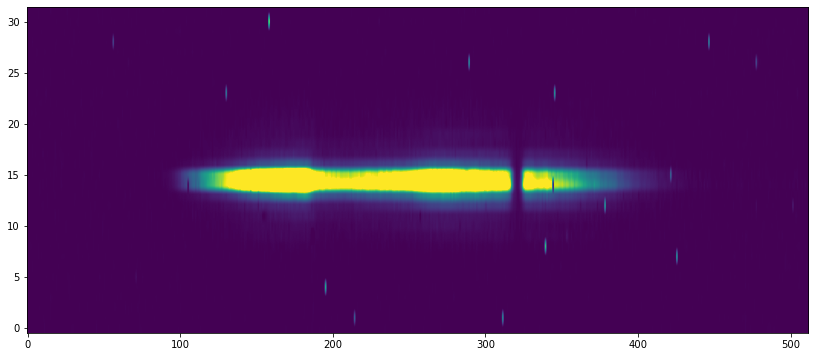

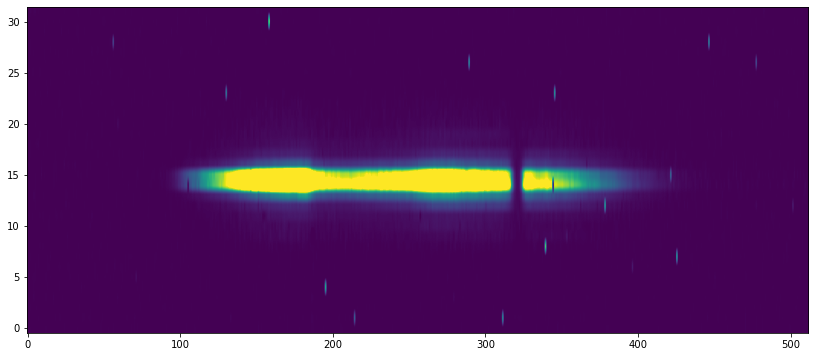

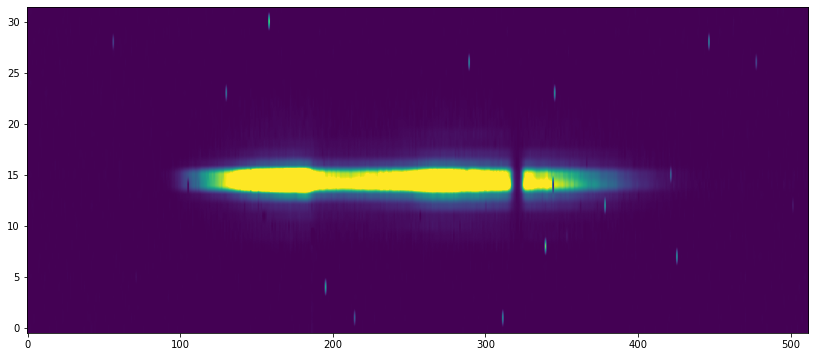

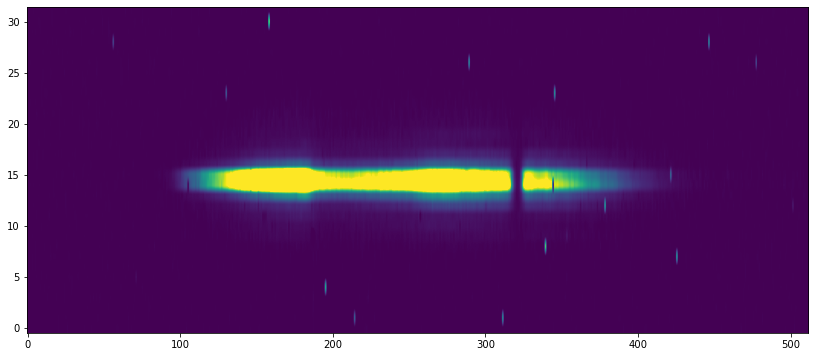

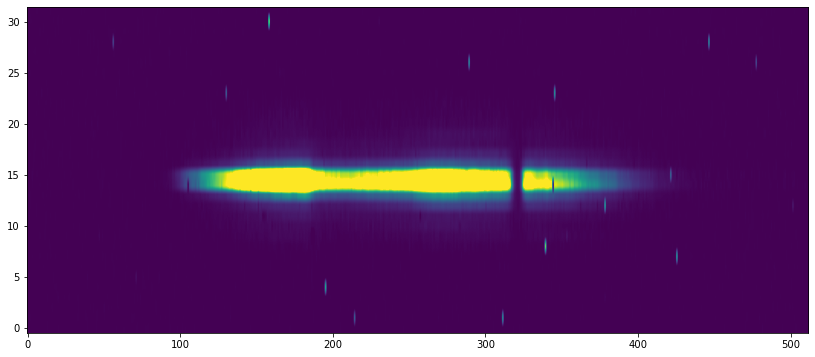

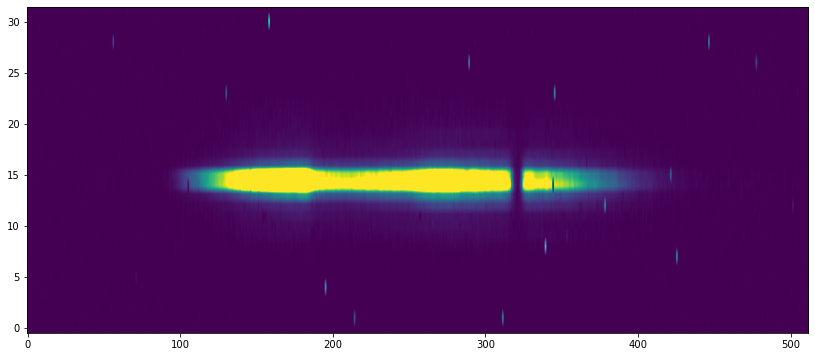

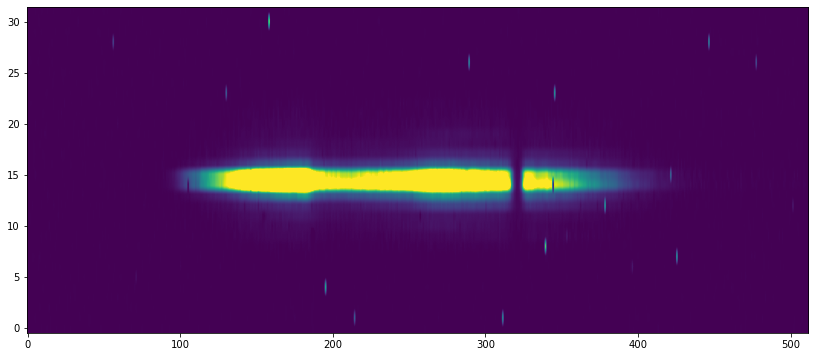

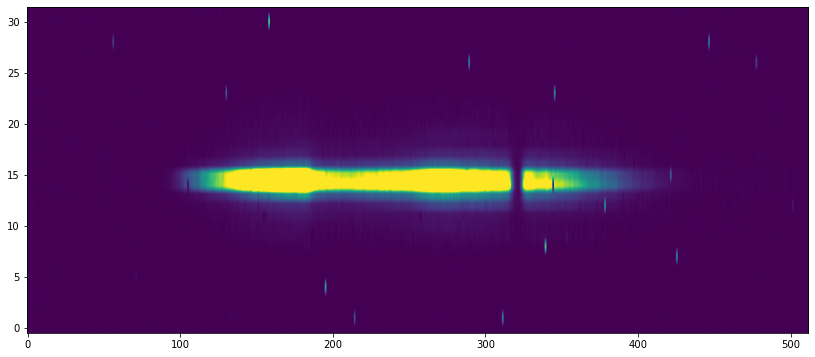

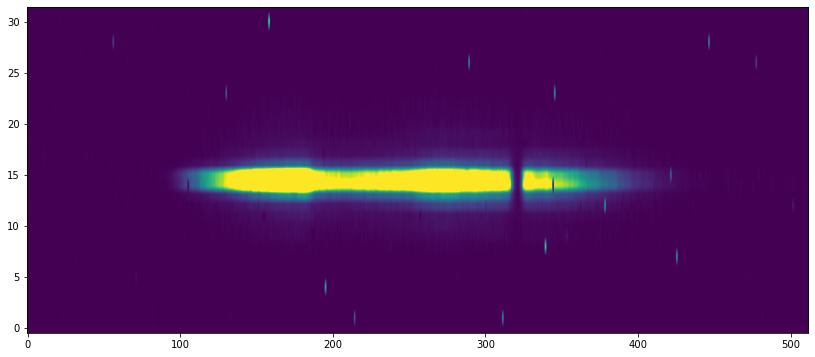

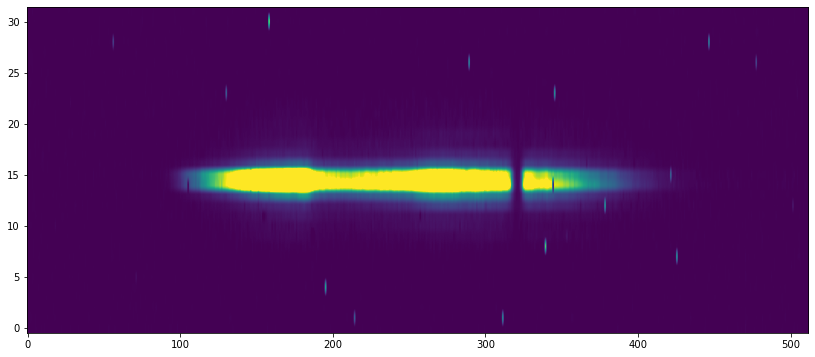

In [362]:
image_corr

%matplotlib inline
for i in range(0, 10):
    print(i)
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    plt.imshow(image_corr[i,1,:,:,], origin = 'lower', aspect='auto',  vmin=0, vmax=1e4)

In [194]:
col_values= hdul[1].data[integr_num,group_num,:,col_num]
a_coeff, x = LS_fit_one(time_full[col_num], col_values)

col_values

array([ 76.17236 ,  55.2854  , 110.812256,  51.60547 ,   3.052246,
        -5.154541,  35.532227,  57.990723,  63.292236,  25.965332,
        28.771484,  66.22119 ,  71.372314,  72.36548 ,  14.185303,
        81.569336,  35.612305,  61.165527,  73.97217 ,  10.485352,
        54.402344,  -2.994629,  36.28247 ,  27.429688, -18.005615,
        87.50122 ,  70.29224 ,  69.64526 ,  36.500366, 104.60547 ,
        66.338135,  -3.921875], dtype=float32)

In [220]:
hdul[1].data[integr_num,group_num,:,col_num]

array([ 76.17236 ,  55.2854  , 110.812256,  51.60547 ,   3.052246,
        -5.154541,  35.532227,  57.990723,  63.292236,  25.965332,
        28.771484,  66.22119 ,  71.372314,  72.36548 ,  14.185303,
        81.569336,  35.612305,  61.165527,  73.97217 ,  10.485352,
        54.402344,  -2.994629,  36.28247 ,  27.429688, -18.005615,
        87.50122 ,  70.29224 ,  69.64526 ,  36.500366, 104.60547 ,
        66.338135,  -3.921875], dtype=float32)

In [363]:
hdul[1].data = image_corr

In [77]:
hdul[1].data

array([[[[-1.74647641e+01,  2.56588586e+01, -3.55468958e+00, ...,
           1.07447225e+01,  2.60732685e+01,  1.53745859e+00],
         [ 3.11808297e+01,  4.96964347e+00, -1.85999862e+00, ...,
          -1.01001078e+01,  3.62870460e+00, -1.07950176e+01],
         [ 3.59083326e+01,  6.06942467e+01, -6.51823975e+01, ...,
           4.72340170e+01, -1.70734277e+01, -6.63359738e+00],
         ...,
         [-9.34630526e+00,  5.98266502e+01,  3.64139713e+00, ...,
           3.19332422e+01,  3.05273499e+01,  1.24123716e+01],
         [ 2.29314906e+01,  2.17570640e+01,  4.24402141e+01, ...,
          -2.19021887e+01,  6.21335673e+01, -1.53995358e+01],
         [-2.70055572e+01, -4.83051980e+01, -6.25158518e+01, ...,
          -1.15407202e+01,  6.64685443e+01, -2.47585623e+01]],

        [[-3.25583007e+01,  2.28747677e+01,  3.22371951e+00, ...,
           3.94044095e+01,  2.33857685e+01,  9.18518583e+00],
         [ 1.67075118e+01,  1.18046875e+01,  1.44278730e+00, ...,
           1.22903056e

In [355]:
image_corr

array([[[[-5.10925140e+01,  2.56588586e+01, -3.55468958e+00, ...,
           1.07447225e+01,  2.60732685e+01,  1.53745859e+00],
         [-1.04299878e+00,  4.96964347e+00, -1.85999862e+00, ...,
          -1.01001078e+01,  3.62870460e+00, -1.07950176e+01],
         [ 5.08842567e+00,  6.06942467e+01, -6.51823975e+01, ...,
           4.72340170e+01, -1.70734277e+01, -6.63359738e+00],
         ...,
         [-2.26033118e+00,  5.98266502e+01,  3.64139713e+00, ...,
           3.19332422e+01,  3.05273499e+01,  1.24123716e+01],
         [ 3.14213862e+01,  2.17570640e+01,  4.24402141e+01, ...,
          -2.19021887e+01,  6.21335673e+01, -1.53995358e+01],
         [-1.71117401e+01, -4.83051980e+01, -6.25158518e+01, ...,
          -1.15407202e+01,  6.64685443e+01, -2.47585623e+01]],

        [[-6.60243322e+01,  2.28747677e+01,  3.22371951e+00, ...,
           3.39890408e+01,  2.33857685e+01,  9.18518583e+00],
         [-1.53622803e+01,  1.18046875e+01,  1.44278730e+00, ...,
          -4.11147131e

In [358]:
from astropy.io.fits import getheader
hdr = getheader("dc-roof/jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS.fits", 0) 
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2022-03-21T19:37:31.874' / UTC date file created                     
ORIGIN  = 'STScI   '           / Organization responsible for creating file     
FILENAME= 'jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp.fits' / Na
FILETYPE= 'countrate'          / Type of data in the file                       
SDP_VER = 'B7.0    '           / Data processing software version number        
CAL_VER = '1.3.3   '           / Calibration software version number            
CAL_VCS = 'RELEASE '           / Calibration software version control sys number
DATAMODL= 'RampModel'          / Type of data model                             
TELESCOP= 'JWST    '        

In [364]:
write =False # True # 

if write:
    hdul.writeto('dc-roof/jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS_add_med_corr.fits')